<h1 style="border-width:2px; border-style:solid; border-color:blue; background-color:#367395; text-align: center; text-shadow: 0px 0px 3px red; padding-bottom: 2em; padding-top: 1em;">ROSSMANN REVENUE FORECASTING<br>Previsão de Faturamento Utilizando Regressão</h1>

### COURSE: "DS IN PRODUCTION" - Comunidade DS
- Student: Manoel Luiz Menezes Mendonça
- Instructor: Meigarom Lopes
- Period: 2023/october to 2024/february
- Our portfolio: http://menezes.mendonca.nom.br/
- Our Linkedin: https://www.linkedin.com/in/manoelmendonca-eng-adv/


# 0.0. INITIAL PROCEDURE

In [1]:
# Disable running slower parts when not needed... (EX: when re-running the code)

BOL_RUN_BORUTA     = True     # see step-6 (feature selection), items 6.2 & 6.3
BOL_RUN_MLMODELS   = True     # see step-7 (machine learning models)
BOL_RUN_FINETUNING = True     # see step-8 (hyperparams fine tuning)


## 0.1. Importing Libraries

In [2]:
import math
import datetime
import pandas      as pd
import numpy       as np
import inflection
import random
import pickle
import warnings
import requests
import re
import json
warnings.filterwarnings( 'ignore' )

from scipy                 import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from tabulate              import tabulate
from boruta                import BorutaPy
from flask                 import Flask, request, Response

from matplotlib            import pyplot as plt

import seaborn    as sns
import xgboost    as xgb


from IPython.core.display import HTML
from IPython.display      import Image

## 0.2. Various Functions

In [3]:
#............... In case of categorical attributes: Cramer V Method
# https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

def cramer_v( x, y ):
    confusion_matrix = pd.crosstab( x, y ).to_numpy()
    chi2 = ss.chi2_contingency( confusion_matrix )[0]
    n = confusion_matrix.sum()
    r, k = confusion_matrix.shape

    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / ( min(kcorr-1, rcorr-1) ) )

In [4]:
#............... FUNCTION: ml_error
# Step 7
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )

    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )


In [5]:
#............... FUNCTION: CROSS_VALIDATION
# Module 7, Class 33

def cross_validation( x_training, kfold, model_name, model, verbose=False ):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( 'KFold Number: {}'.format(k) )
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )
        if verbose:
            print( 'Dates -     start={}     end={}'.format( validation_start_date, validation_end_date ) )

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset (exclude two features)
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1(yhat) )
        if verbose:
            print( m_result )

        # store performance of each KFold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame(
            {'Model Name': model_name,
             'MAE CV': np.round( np.mean(mae_list), 2 ).astype(str) + ' +/- ' + np.round( np.std(mae_list), 2 ).astype(str),
             'MAPE CV': np.round( np.mean(mape_list), 2 ).astype(str) + ' +/- ' + np.round( np.std(mape_list), 2 ).astype(str),
             'RMSE CV': np.round( np.mean(rmse_list), 2 ).astype(str) + ' +/- ' + np.round( np.std(rmse_list), 2 ).astype(str),
             'rmse_float': np.mean(rmse_list) },
             index=[0] )


## 0.3. Loading Data

In [6]:
# 0.2. LOADING DATA

# my cloudio
MyCSV = 'http://menezes.mendonca.nom.br/datasets/rossmann/train.csv'
# local file
#MyCSV = '../data/train.csv'
df_sales_raw = pd.read_csv( MyCSV, low_memory=False )

MyCSV = 'http://menezes.mendonca.nom.br/datasets/rossmann/store.csv'
#MyCSV = '../data/store.csv'
df_store_raw = pd.read_csv( MyCSV, low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# STEP 1. DATA DESCRIPTION

## 1.1. Initial Procedure (copy data)

In [7]:
# 1.0. COPY DATA
# Copy dataset to a new variable
df1 = df_raw.copy()

## 1.2. Rename Columns

In [8]:
# 1.1. RENAME COLUMNS
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval' ]

snakecase = lambda x: inflection.underscore( x )
cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [9]:
df1.sample(8).T

187396      590658      937288  \
store                                      77         494         359   
day_of_week                                 5           6           3   
date                               2015-02-13  2014-01-18  2013-03-13   
sales                                    6905        5056        5388   
customers                                 646         754         511   
open                                        1           1           1   
promo                                       0           0           0   
state_holiday                               0           0           0   
school_holiday                              0           0           0   
store_type                                  d           b           d   
assortment                                  c           a           c   
competition_distance                   1090.0      1260.0      4370.0   
competition_open_since_month              8.0         6.0         NaN   
competition_open_since_year            2009.0      2011.0         NaN   
promo2                                      1           0           0   
promo2_since_week                        10.0         NaN         NaN   
promo2_since_year                      2014.0         NaN         NaN   
promo_interval                Jan,Apr,Jul,Oct         NaN         NaN   

                                  780992      600308      664193      524673  \
store                                163         109         439         294   
day_of_week                            3           4           3           2   
date                          2013-07-31  2014-01-09  2013-11-13  2014-03-18   
sales                               8343        5964        5218        8058   
customers                            940         640         737        1057   
open                                   1           1           1           1   
promo                                  1           1           0           1   
state_holiday                          0           0           0           0   
school_holiday                         1           0           0           0   
store_type                             a           a           a           a   
assortment                             a           c           a           a   
competition_distance              1480.0      3300.0      1350.0      3150.0   
competition_open_since_month         4.0        11.0         9.0         5.0   
competition_open_since_year       2009.0      2010.0      2009.0      2005.0   
promo2                                 0           0           0           0   
promo2_since_week                    NaN         NaN         NaN         NaN   
promo2_since_year                    NaN         NaN         NaN         NaN   
promo_interval                       NaN         NaN         NaN         NaN   

                                       78384   
store                                     335  
day_of_week                                 5  
date                               2015-05-22  
sales                                   14808  
customers                                2690  
open                                        1  
promo                                       1  
state_holiday                               0  
school_holiday                              0  
store_type                                  b  
assortment                                  a  
competition_distance                     90.0  
competition_open_since_month              NaN  
competition_open_since_year               NaN  
promo2                                      1  
promo2_since_week                        31.0  
promo2_since_year                      2013.0  
promo_interval                Jan,Apr,Jul,Oct

## 1.3. Data Dimension

In [10]:
# 1.2. DATA DIMENSION
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.4. Data Types

In [11]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
# 1.4. DATA TYPES
# Convert OBJECT type to DATETIME64 type
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [13]:
type(df1.loc[0, 'date'])

pandas._libs.tslibs.timestamps.Timestamp

## 1.5. Check NA

In [14]:
# 1.4. CHECK NA
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.6. Fillout NA

In [15]:
# 1.6. FILLOUT NA

# ATTRIBUTE: competition_distance
# criterion: if NA, then fill with a far away distance (very distant = 200.000)
df1['competition_distance'] = (df1['competition_distance']
        .apply( lambda x: 200000.0 if math.isnan( x ) else x ))

# ATTRIBUTE: competition_open_since_month
# criterion-1: if NA, then fill with the month/year of the current date
# criterion-2: (to be tested) fill NA with first date (2013/01/01) or last date (2015/07/31)
df1['competition_open_since_month'] = (df1
        .apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) 
                                        else x['competition_open_since_month'], axis=1 ))

# ATTRIBUTE: competition_open_since_year
# criterion-1: if NA, then fill with the month/year of the current date
# criterion-2: (to be tested) fill NA with first date (2013/01/01) or last date (2015/07/31)
df1['competition_open_since_year'] = (df1
        .apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) 
                                       else x['competition_open_since_year'], axis=1 ))

# ATTRIBUTE: promo2_since_week
# criterion-1: if NA, then fill with week of the current date
# PS: ok, but attribute promo2 is not day-dependent, but store-dependent.
# criterion-2: (to be tested) fill the NA gaps by running a Random Forest specific for this task.
df1['promo2_since_week'] = (df1
        .apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) 
                                       else x['promo2_since_week'], axis=1 ))

# ATTRIBUTE: promo2_since_year
# criterion-1: if NA, then fill with the current year
# PS: ok, but attribute promo2 is not day-dependent, but store-dependent.
# criterion-2: (to be tested) fill the NA gaps by running a Random Forest specific for this task.
df1['promo2_since_year'] = (df1
        .apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) 
                                       else x['promo2_since_year'], axis=1 ))

# ATTRIBUTE: promo_interval
df1['promo_interval'].fillna( 0, inplace=True )

In [16]:
df1.sample(6).T

60141                533865  \
store                                        1047                  566   
day_of_week                                     1                    1   
date                          2015-06-08 00:00:00  2014-03-10 00:00:00   
sales                                        4949                 3813   
customers                                     532                  497   
open                                            1                    1   
promo                                           0                    0   
state_holiday                                   0                    0   
school_holiday                                  0                    1   
store_type                                      a                    a   
assortment                                      a                    a   
competition_distance                       3750.0               3620.0   
competition_open_since_month                  6.0                  3.0   
competition_open_since_year                2015.0               2014.0   
promo2                                          1                    1   
promo2_since_week                            45.0                 40.0   
promo2_since_year                          2009.0               2013.0   
promo_interval                    Feb,May,Aug,Nov      Jan,Apr,Jul,Oct   

                                           34251                986657  \
store                                         802                  668   
day_of_week                                     3                    1   
date                          2015-07-01 00:00:00  2013-01-28 00:00:00   
sales                                        8117                 6253   
customers                                     555                  967   
open                                            1                    1   
promo                                           1                    0   
state_holiday                                   0                    0   
school_holiday                                  0                    0   
store_type                                      a                    c   
assortment                                      c                    a   
competition_distance                        910.0               1270.0   
competition_open_since_month                  7.0                  9.0   
competition_open_since_year                2015.0               2010.0   
promo2                                          1                    0   
promo2_since_week                            22.0                  5.0   
promo2_since_year                          2011.0               2013.0   
promo_interval                    Feb,May,Aug,Nov                    0   

                                           805863               394279  
store                                         504                  980  
day_of_week                                     2                    3  
date                          2013-07-09 00:00:00  2014-07-16 00:00:00  
sales                                        5637                 7651  
customers                                     854                  566  
open                                            1                    1  
promo                                           0                    1  
state_holiday                                   0                    0  
school_holiday                                  1                    1  
store_type                                      c                    a  
assortment                                      c                    a  
competition_distance                        820.0               4420.0  
competition_open_since_month                  7.0                  9.0  
competition_open_since_year                2013.0               2005.0  
promo2                                          0                    0  
promo2_since_week                            28.0            

In [17]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64

## 1.7. Change Types

In [18]:
# PS: 'date' attribute changed type in 1.4

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [20]:
# 1.7. CHANGE TYPES
# From FLOAT to INT
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( np.int64 )
df1['promo2_since_week']          = df1['promo2_since_week'].astype( np.int64 )
df1['promo2_since_year']         = df1['promo2_since_year'].astype( np.int64 )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
dtype: object

## 1.8. Descriptive Statistics

### 1.8.1 Separete Numerical from Categorical Attributes

In [21]:
# 1.8. DESCRIPTIVE STATISTICS

# Manually Separate: numerical features
num_attr = [ 'sales', 'customers', 'competition_distance' ]
#num_attributes = df1.select_dtypes( include=[ 'int64', 'float64' ] )
num_attributes = df1.loc[:, num_attr].copy()

# Categorical features: all the others
cat_attr = []
for a in df1.columns:
    if a in num_attr:
        #print(a)
        continue
    cat_attr.append(a)
cat_attributes = df1.loc[:, cat_attr].copy()

num_attributes.sample(8).T

504494   53197    929769   206937   169125   717084   \
sales                  6189.0      0.0  11880.0   5360.0  13302.0   6308.0   
customers               491.0      0.0   1456.0    689.0   1365.0   1141.0   
competition_distance   1860.0   2710.0     90.0   7860.0   2390.0    470.0   

                      570901   1011170  
sales                  9801.0      0.0  
customers               920.0      0.0  
competition_distance   3870.0    200.0

In [22]:
cat_attributes.sample(5).T

198704               81572   \
store                                         235                  178   
day_of_week                                     2                    2   
date                          2015-02-03 00:00:00  2015-05-19 00:00:00   
open                                            1                    1   
promo                                           1                    1   
state_holiday                                   0                    0   
school_holiday                                  0                    0   
store_type                                      a                    d   
assortment                                      a                    a   
competition_open_since_month                    3                    5   
competition_open_since_year                  2012                 2015   
promo2                                          1                    0   
promo2_since_week                              37                   21   
promo2_since_year                            2009                 2015   
promo_interval                    Jan,Apr,Jul,Oct                    0   

                                           500514               776220  \
store                                         665                  966   
day_of_week                                     3                    1   
date                          2014-04-09 00:00:00  2013-08-05 00:00:00   
open                                            1                    1   
promo                                           0                    0   
state_holiday                                   0                    0   
school_holiday                                  0                    1   
store_type                                      a                    a   
assortment                                      a                    a   
competition_open_since_month                   12                    2   
competition_open_since_year                  2012                 2008   
promo2                                          1                    0   
promo2_since_week                              14                   32   
promo2_since_year                            2011                 2013   
promo_interval                    Jan,Apr,Jul,Oct                    0   

                                           207121  
store                                         847  
day_of_week                                     2  
date                          2015-01-27 00:00:00  
open                                            1  
promo                                           1  
state_holiday                                   0  
school_holiday                                  0  
store_type                                      c  
assortment                                      c  
competition_open_since_month                    1  
competition_open_since_year                  2015  
promo2                                          1  
promo2_since_week                              31  
promo2_since_year                            2013  
promo_interval                    Feb,May,Aug,Nov

### 1.8.2 Numerical Attributes

In [23]:
# 1.8.1 DESCRIPTIVE STATISTICS - NUMERICAL FEATURES
# Dispersion (variance, standard deviation, max, min, range, skew, kurtosis)
# central tendency (mean, median)

# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate the metrics
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).round(2).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
m

attributes   min       max     range     mean  median       std  \
0                 sales   0.0   41551.0   41551.0  5773.82  5744.0   3849.92   
1             customers   0.0    7388.0    7388.0   633.15   609.0    464.41   
2  competition_distance  20.0  200000.0  199980.0  5935.44  2330.0  12547.65   

    skew  kurtosis  
0   0.64      1.78  
1   1.60      7.09  
2  10.24    147.79

### 1.8.3 Categorical Attributes

#### List of attributes & number of categories

In [24]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

store                           1115
day_of_week                        7
date                             942
open                               2
promo                              2
state_holiday                      4
school_holiday                     2
store_type                         4
assortment                         3
competition_open_since_month      12
competition_open_since_year       23
promo2                             2
promo2_since_week                 52
promo2_since_year                  7
promo_interval                     4
dtype: int64

#### Categorical attribute: (I) days of week

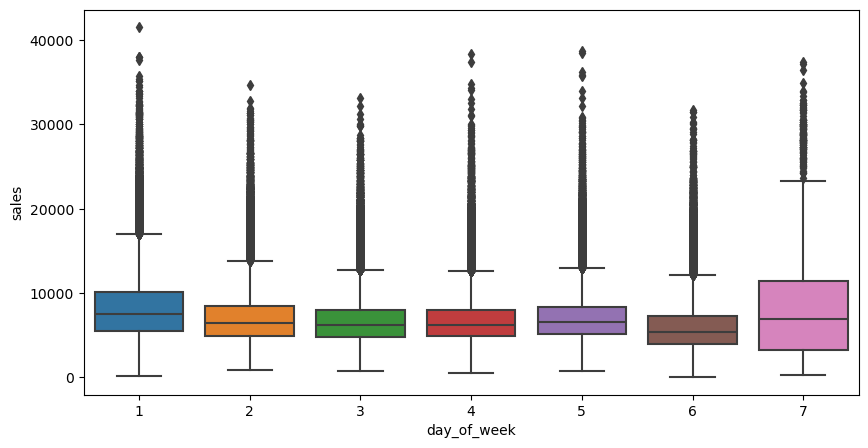

In [25]:
aux1 = df1[ df1['sales'] > 0  ]
plt.figure( figsize=(10, 5) )
sns.boxplot( x='day_of_week', y='sales', data=aux1 );

# table of quantities:
total = aux1.shape[0]
# In average, how many stores are open per weekday?
aux11 = aux1.loc[:, ['day_of_week', 'store', 'store_type']].copy()
aux12 = aux11.groupby(['day_of_week', 'store']).count()
StoresPerDay = aux12.groupby('day_of_week').count().reset_index()
StoresPerDay.columns = [ 'day_of_week', 'num_open_stores' ]

In [26]:
StoresPerDay

day_of_week  num_open_stores
0            1             1115
1            2             1115
2            3             1115
3            4             1115
4            5             1115
5            6             1115
6            7               33

#### Categorical attributes: (II) state holiday & school holiday

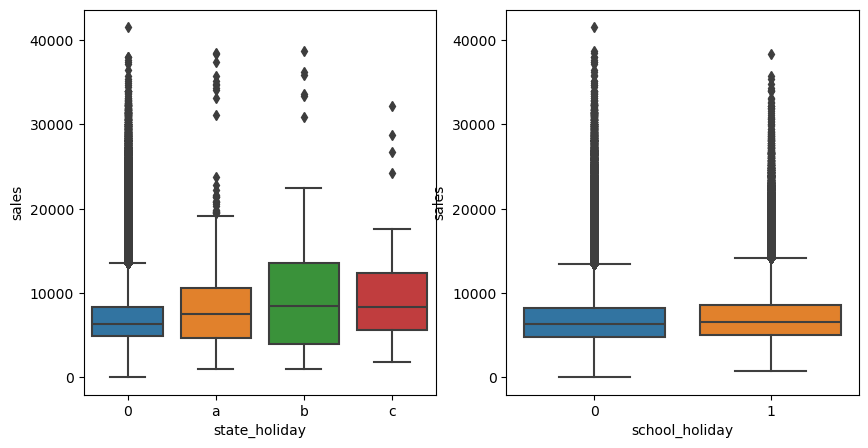

In [27]:
# boxplot
aux1 = df1[ df1['sales'] > 0  ]
plt.figure( figsize=(10, 5) )
plt.subplot( 1, 2, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1 );
plt.subplot( 1, 2, 2)
sns.boxplot( x='school_holiday', y='sales', data=aux1 );

# table of quantities:
total = aux1.shape[0]
aux11 = aux1.loc[:, ['state_holiday', 'store']].copy()
stt_hol = aux11.groupby('state_holiday').count().reset_index()
stt_hol['perc'] = ( 100. * stt_hol['store'] / total ).round(2)
stt_hol.columns = [ 'state_holiday', 'qty', 'qty%' ]

aux11 = aux1.loc[:, ['school_holiday', 'store']].copy()
sch_hol = aux11.groupby('school_holiday').count().reset_index()
sch_hol['perc'] = ( 100. * sch_hol['store'] / total ).round(2)
sch_hol.columns = [ 'school_holiday', 'qty', 'qty%' ]

In [28]:
stt_hol

state_holiday     qty   qty%
0             0  843428  99.89
1             a     694   0.08
2             b     145   0.02
3             c      71   0.01

In [29]:
sch_hol

school_holiday     qty   qty%
0               0  680893  80.64
1               1  163445  19.36

#### Categorical attributes: (III) store_type & assortment

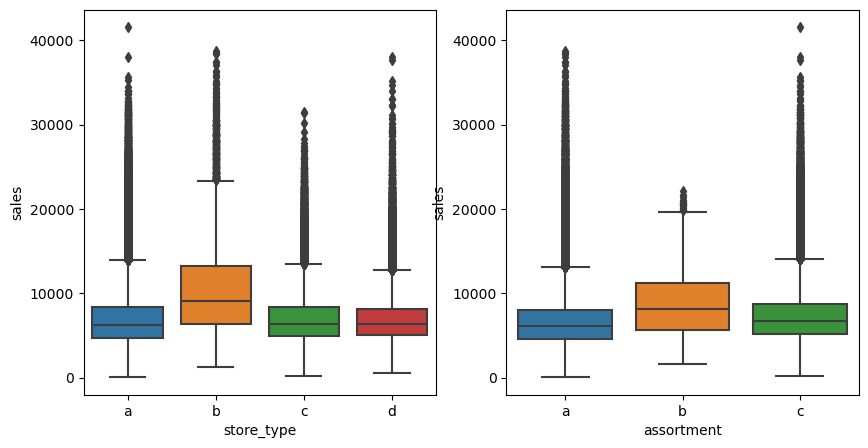

In [30]:
# boxplot
aux1 = df1[ df1['sales'] > 0  ]
plt.figure( figsize=(10, 5) )
plt.subplot( 1, 2, 1)
sns.boxplot( x='store_type', y='sales', data=aux1, order='abcd' );
plt.subplot( 1, 2, 2)
sns.boxplot( x='assortment', y='sales', data=aux1, order='abc' );

# tables of quantities:
total = aux1.shape[0]
aux11 = aux1.loc[:, ['store_type', 'store']].copy()
st_type = aux11.groupby('store_type').count().reset_index()
st_type['perc'] = ( 100. * st_type['store'] / total ).round(2)
st_type.columns = [ 'store_type', 'qty', 'qty%' ]

aux11 = aux1.loc[:, ['assortment', 'store']].copy()
assortm = aux11.groupby('assortment').count().reset_index()
assortm['perc'] = ( 100. * assortm['store'] / total ).round(2)
assortm.columns = [ 'assortment', 'qty', 'qty%' ]

In [31]:
st_type

store_type     qty   qty%
0          a  457042  54.13
1          b   15560   1.84
2          c  112968  13.38
3          d  258768  30.65

In [32]:
assortm

assortment     qty   qty%
0          a  444875  52.69
1          b    8209   0.97
2          c  391254  46.34

#### Categorical attributes: (IV) promo, promo2, promo_interval

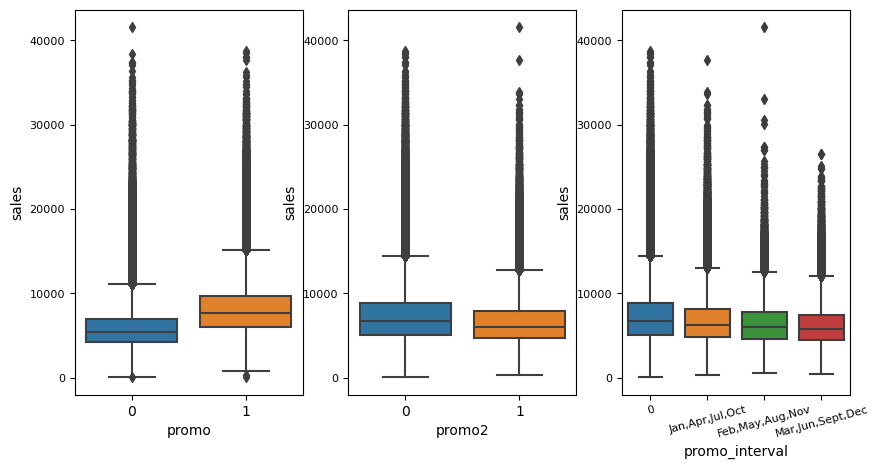

In [33]:
# boxplots
aux1 = df1[ df1['sales'] > 0  ]
plt.figure( figsize=(10, 5) )
plt.subplot( 1, 3, 1)
sns.boxplot( x='promo', y='sales', data=aux1 );
plt.yticks( fontsize=8 );
plt.subplot( 1, 3, 2)
sns.boxplot( x='promo2', y='sales', data=aux1 );
plt.yticks( fontsize=8 );
plt.subplot( 1, 3, 3)
sns.boxplot( x='promo_interval', y='sales', data=aux1 );
plt.xticks( rotation=15, fontsize=8 );
plt.yticks( fontsize=8 );

# table of quantities:
total = aux1.shape[0]
aux11 = aux1.loc[:, ['promo', 'store']].copy()
prm = aux11.groupby('promo').count().reset_index()
prm['perc'] = ( 100. * prm['store'] / total ).round(2)
prm.columns = [ 'promo', 'qty', 'qty%' ]

aux11 = aux1.loc[:, ['promo2', 'store']].copy()
prm2 = aux11.groupby('promo2').count().reset_index()
prm2['perc'] = ( 100. * prm2['store'] / total ).round(2)
prm2.columns = [ 'promo2', 'qty', 'qty%' ]

aux11 = aux1.loc[:, ['promo_interval', 'store']].copy()
prmint = aux11.groupby('promo_interval').count().reset_index()
prmint['perc'] = ( 100. * prmint['store'] / total ).round(2)
prmint.columns = [ 'promo_interval', 'qty', 'qty%' ]

In [34]:
prm

promo     qty   qty%
0      0  467463  55.36
1      1  376875  44.64

In [35]:
prm2

promo2     qty   qty%
0       0  423292  50.13
1       1  421046  49.87

In [36]:
prmint

promo_interval     qty   qty%
0                 0  423292  50.13
1   Feb,May,Aug,Nov   97998  11.61
2   Jan,Apr,Jul,Oct  242397  28.71
3  Mar,Jun,Sept,Dec   80651   9.55

# STEP 2. FEATURE ENGINEERING

## 2.0. Initial Procedure

In [37]:
df2 = df1.copy()

## 2.1. Hypotesis Mind Map

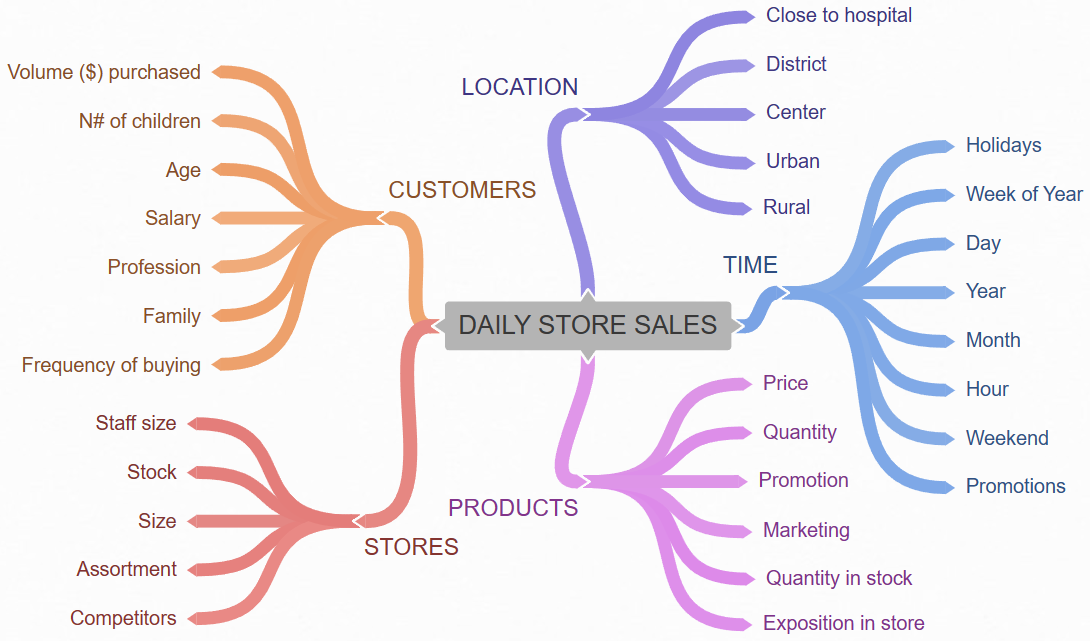

In [38]:
Image('../img/MindMapHypothesisEN.png')

## 2.2. Hypotesis Formulation

### 2.2.1. Hypothesis regarding STORES

**1.** Stores with larger staff should sell more

**2.** Stores with higher stock should sell more

**3.** Bigger stores should sell more

**4.** Stores with higher assortment should sell more

**5.** Stores close to other competitors should sell less

**6.** Stores with long time competitors should sell more


### 2.2.2. Hypothesis regarding PRODUCTS

**1.** The more stores invest in marketing, the more they should sell

**2.** The more stores expose their products, the more they should sell

**3.** Stores with low budget products (like "extra" assortment) sell less than stores with more expensive products (like "extended" assortment).

**4.** Stores with low budget products have more customers and stores with more expensive products have less customers.

**5.** Most of the stores work with low budget products (like "extra" assortment).

**6.** Stores with longer periods of promotional sales should sell more

**7.** The more agressive the promotions, the more stores should sell

**8.** Stores with more days of promotional sales should sell more

**9.** Stores with more consecutive promotional sales should sell more

### 2.2.3. Hypothesis regarding TIME

**1.** Stores should sell more on Mondays, since most of the stores were closed the day before.

**2.** On Sunday, the few stores open (33/1115) should sell more.

**3.** On Saturday, the stores should sell less, due to the reduced working hours.

**4.** Due to Mother's Day, May should be the second best selling month of the year.

**5.** Due to the winter, January and February should sell less.

**6.** Stores should sell more from the last days of the previous month to the first days of the current month, due to the receipt of salaries in the economy.

**7.** Stores should sell less in the middle days of the month.

**8.** Stores open during Christmas Holiday should sell more

**9.** Stores should sell less during school holidays, since there is a reduced number of customers.

**10.** Stores should also sell less during other holidays.

## 2.3. Final List of Hypotesis

Main criteria: data is available (or not).

FINAL HYPOTHESIS LIST:

**1.** Stores with long time competitors should sell more

**2.** Stores close to other competitors should sell less

**3.** Stores with low budget products (like "extra" assortment) sell less than stores with more expensive products (like "extended" assortment).

**4.** Stores with low budget products have more customers and stores with more expensive products have less customers.

**5.** Most of the stores work with low budget products (like "extra" assortment).

**6.** Stores with longer periods of promotional sales should sell more

**7.** Stores with more consecutive promotional sales should sell more

**8.** Stores open during Christmas Holiday should sell more

**9.** Stores should sell less during school holidays, since there is a reduced number of customers.

**10.** Stores should also sell less during other holidays, since there is a reduced number of customers.

**11.** Stores should sell more on Mondays, since most of the stores were closed the day before.

**12.** On Sunday, the few stores open (33/1115) should sell more.

**13.** On Saturday, the stores should sell less, due to the reduced working hours.

**14.** Due to Mother's Day, May should be the second best selling month of the year.

**15.** Due to the winter, January and February should sell less.

**16.** Stores should sell more from the last days of the previous month to the first days of the current month, due to the receipt of salaries in the economy.

**17.** Stores should sell less in the middle days of the month.

## 2.4 Feature Engineering

### 2.4.1 Attributes derived from 'PROMO2'

In [39]:
# Attribute PROMO2: force to ZERO if date < (promo2_since_week + promo2_since_year)
# PS: this is necessary because 'promo2' is originally a STORE.CSV attribute, not a TRAIN.CSV attribute
# Example: STORE-28 started its 'promo2' only in 2015, 6th week. Before this week, promo2 should be ZERO.
df2['promo2aux'] = df2.apply( lambda x: 0 if x['promo2'] == 0 
                                          or x['date'].year < x['promo2_since_year'] 
                                          or (x['date'].year == x['promo2_since_year'] and x['date'].week < x['promo2_since_week']) 
                                          else 1, axis=1 )

# Attribute "IS_PROMO2"
# From "promo2" & "promo_interval", create "is_promo2" attribute

month_map = { 1:'Jan', 2:'Feb', 3:'Mar',   4:'Apr',  5:'May',  6:'Jun', 
              7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec' }

df2['month_map'] = df2['date'].dt.month.map( month_map )

df2['is_promo2'] = (df2[['promo_interval', 'promo2aux', 'month_map']]
                   .apply( lambda x: 0 if x['promo2aux'] == 0 
                                       else 1 if x['month_map'] in x['promo_interval'].split( ',' ) 
                                       else 0, axis=1 ))

# Attribute PROMO2_SINCE
# PS: using features: "promo2", "since_week" and "since_year"
df2['promo2_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo2_since'] = df2['promo2_since'].apply( 
    lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) 
)

# Attribute PROMO2_TIME_WEEK
df2['promo2_time_week'] = ( ( df2['date'] - df2['promo2_since'] )/7 ).apply( lambda x: x.days ).astype( np.int64 )
df2['promo2_time_week'] = df2.apply( lambda x: 0.0 if x['promo2_time_week'] < 0 else x['promo2_time_week'], axis=1 )


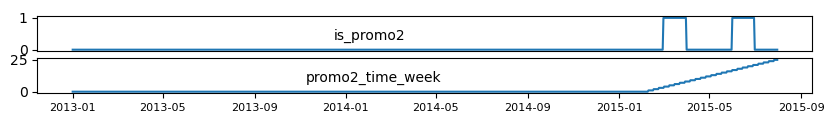

In [40]:
# IS_PROMO2 Example: STORE-28 promo2 after adjusted by promo2_since[week,year]
#                    STORE-28 started its 'promo2' only in 2015, 6th week.
aux = df2.loc[ df2['store']==28 , ['date','promo2_since','is_promo2','promo2_time_week']]
plt.figure( figsize=(10, 1) )
#
plt.subplot( 2, 1, 1)
plt.plot(aux['date'], aux['is_promo2'] );
plt.tick_params( axis='x', which='both', bottom=False, top=False, labelbottom=False);
plt.annotate( 'is_promo2', xy=(240,60), fontsize=10, xycoords='figure points' );
#
plt.subplot( 2, 1, 2)
plt.plot(aux['date'], aux['promo2_time_week'] );
plt.xticks(rotation=0, fontsize=8);
plt.annotate( 'promo2_time_week', xy=(220,30), fontsize=10, xycoords='figure points' );

### 2.4.2 Atributes derived from "Competition"

In [41]:
# Attribute HAS_COMPETITION: =ZERO in the days before CompetitionOpenSince[month/year].
#                            =ONE after that date.
df2['has_competition'] = ( df2
    .apply( lambda x: 0 if x['date'].year < x['competition_open_since_year'] 
                        or (x['date'].year == x['competition_open_since_year'] and x['date'].month < x['competition_open_since_month']) 
                        else 1, axis=1 ) )

# Attribute COMPETITION_DISTANCE
df2['competition_distance'] = (df2
        .apply( lambda x: 200000.0 if x['has_competition'] == 0 
                                 else x['competition_distance'], axis=1 ))

# Attribute COMPETITION_SINCE
# PS: info separated in MONTH & YEAR. Join them and calculate date difference to current date
df2['competition_since'] = df2.apply( 
    lambda x: datetime.datetime( 
        year=x['competition_open_since_year'], 
        month=x['competition_open_since_month'], day=1 ), 
    axis=1 )
df2['competition_time_month'] = (( ( df2['date'] - df2['competition_since'] )/30 )
        .apply( lambda x: x.days ).astype( np.int64 ))
df2['competition_time_month'] = (df2
        .apply( lambda x: 0.0 if x['competition_time_month'] < 0 
                            else x['competition_time_month'], axis=1 ))


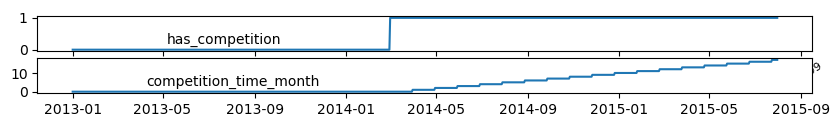

In [42]:
# Example: STORE-14  started to face competition in 2014-march
#          STORE-122 started to face competition in 2013-april
aux = df2.loc[ df2['store']==14 , ['date','sales','has_competition','competition_time_month']]
plt.figure( figsize=(10, 1) )
plt.subplot( 2, 1, 1)
plt.plot(aux['date'], aux['has_competition'] );
plt.annotate( 'has_competition', xy=(120,60), fontsize=10, xycoords='figure points' );
plt.xticks(rotation=30, fontsize=8);

plt.subplot( 2, 1, 2)
plt.plot(aux['date'], aux['competition_time_month'] );
plt.annotate( 'competition_time_month', xy=(105,30), fontsize=10, xycoords='figure points' );


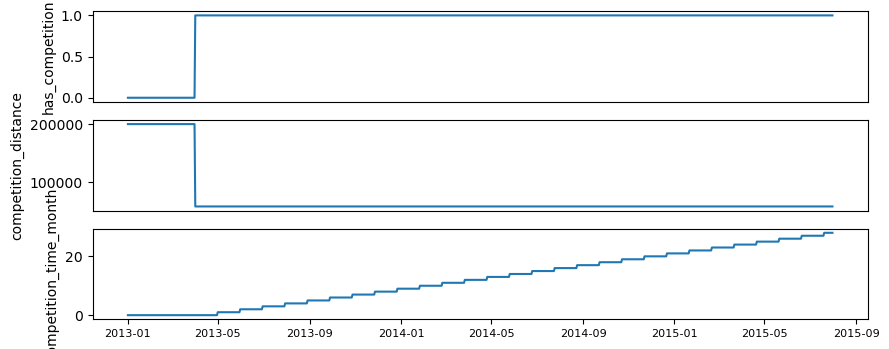

In [43]:
# Example: STORE-122 - competition started in 2013-april
aux = df2.loc[ df2['store']==122 , ['date','has_competition','competition_distance','competition_time_month']]
plt.figure( figsize=(10, 4) )
plt.subplot( 3, 1, 1)
plt.plot(aux['date'], aux['has_competition'] );
plt.tick_params( axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('has_competition');
#
plt.subplot( 3, 1, 2)
plt.plot(aux['date'], aux['competition_distance'] );
plt.tick_params( axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('competition_distance');
#
plt.subplot( 3, 1, 3)
plt.plot(aux['date'], aux['competition_time_month'] );
plt.xticks(rotation=0, fontsize=8);
plt.ylabel('competition_time_month');

### 2.4.3 Attributes: time periodicity

In [44]:
# year
df2['year'] = df2['date'].dt.year.astype( np.int64 )
# month
df2['month'] = df2['date'].dt.month.astype( np.int64 )
# day
df2['day'] = df2['date'].dt.day.astype( np.int64 )
# semester
df2['semester'] = df2['month'].apply( lambda x: 0 if x < 7 else 1 ).astype( np.int64 )
# quarter
df2['quarter'] = df2['month'].apply( lambda x: 1 if x < 4 
                                          else 2 if x < 7 
                                          else 3 if x < 10 
                                          else 4 ).astype( np.int64 )
# two months
df2['2months'] = df2['month'].apply( lambda x: 1 if x < 3 
                                          else 2 if x < 5 
                                          else 3 if x < 7 
                                          else 4 if x < 9 
                                          else 5 if x < 11 
                                          else 6 ).astype( np.int64 )
# fortnight
df2['fortnight_of_year'] = df2.apply( lambda x: (2* x['month']) if x['day'] > 15 
                                           else (2* x['month'] -1), axis=1 ).astype( np.int64 )
df2['fortnight_of_month'] = df2.apply( lambda x: 1 if x['day'] > 15 else 0, axis=1)

# week of year
# "weekofyear" deprecated, in favor of "isocalendar"
# REF: https://pandas.pydata.org/pandas-docs/version/1.5/reference/api/pandas.Series.dt.weekofyear.html
# REF: https://pandas.pydata.org/pandas-docs/version/1.5/reference/api/pandas.Series.dt.isocalendar.html#pandas.Series.dt.isocalendar
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype( np.int64 )

# year week (string)
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

### 2.4.4 Attributes: "assortment" & "state_holiday"

In [45]:
# assortment: a=basic, b=extra, c=extended
df2['assortment'] = (df2['assortment']
                     .apply( lambda x: 'basic' if x == 'a' 
                                  else 'extra' if x == 'b' 
                                  else 'extended' ))
# state holiday
# a=public holiday, b=Easter holiday, c=Christmas, 0=regular working day
df2['state_holiday'] = df2['state_holiday'].apply( 
    lambda x: 'public_holiday' if x == 'a' else 
              'easter_holiday' if x == 'b' else 
              'christmas'      if x == 'c' else 
              'regular_day' )

df2[['store','assortment','state_holiday']].sample(5)

store assortment state_holiday
339865    764   extended   regular_day
492129     85      basic   regular_day
317245    545   extended   regular_day
46737    1023      basic   regular_day
153343    589   extended   regular_day

### 2.4.5 Attribute: "sales_per_customer"

In [46]:
df2['sales_per_customer'] = (df2
                .apply( lambda x: 0 if x['customers'] == 0 
                                  else x['sales'] / x['customers'], axis=1 ))

df2[['store', 'sales', 'customers', 'sales_per_customer']].sample(5)


store  sales  customers  sales_per_customer
811546    612   7524        449           16.757238
543635    301   4721        499            9.460922
125927   1048   7223        562           12.852313
115284    440      0          0            0.000000
172666    957   8594        917            9.371865

# STEP 3. DATA FILTERING

## 3.0. Initial Procedure

In [47]:
df3 = df2.copy()
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'promo2aux', 'month_map',
       'is_promo2', 'promo2_since', 'promo2_time_week', 'has_competition',
       'competition_since', 'competition_time_month', 'year', 'month', 'day',
       'semester', 'quarter', '2months', 'fortnight_of_year',
       'fortnight_of_month', 'week_of_year', 'year_week',
       'sales_per_customer'],
      dtype='object')

## 3.1. Rows Filtering

In [48]:
# If stores are closed (open=0), then SALES=0 and CONSUMERS=0. Let's see:
aux1 = df3.loc[:, ['open', 'sales']].copy()
aux11 = aux1.groupby('open').sum().reset_index()
aux1 = df3.loc[:, ['open', 'customers']].copy()
aux12 = aux1.groupby('open').sum().reset_index()
aux13 = pd.merge( aux11, aux12, how='inner', on='open' )
aux13

open       sales  customers
0     0           0          0
1     1  5873180623  644041755

In [49]:
# 3.1. ROWS FILTERING

df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Columns Selection

In [50]:
# 3.2. COLUMNS SELECTION
#
# DELETE COLUMNS:
# - Del 'OPEN'. After filtering rows, the 'OPEN' column can be deleted.
# - The columns 'PROMO_INTERVAL' and 'MONTH_MAP' are no longer needed, because were transformed in other cols.

cols_drop = [ 'open', 'promo_interval', 'month_map', 'promo2aux' ]
df3 = df3.drop( cols_drop, axis=1 )

# 'CUSTOMERS' & 'SALES_PER_CUSTOMER' Columns:
# - Both columns should be deleted, since 'customers' won't be available during prediction (=business restriction)
# - But it's an important feature in EDA, to evaluate & understand the business
# - Result: it will be deleted after step-4 item 4.2


In [51]:
df3.sample(6).T

641249               644825  \
store                                         910                   26   
day_of_week                                     3                    6   
date                          2013-12-04 00:00:00  2013-11-30 00:00:00   
sales                                        7605                 6462   
customers                                     659                  560   
promo                                           1                    0   
state_holiday                         regular_day          regular_day   
school_holiday                                  0                    0   
store_type                                      d                    d   
assortment                               extended                basic   
competition_distance                      12480.0               2300.0   
competition_open_since_month                   12                   11   
competition_open_since_year                  2013                 2013   
promo2                                          1                    0   
promo2_since_week                               1                   48   
promo2_since_year                            2013                 2013   
is_promo2                                       0                    0   
promo2_since                  2012-12-31 00:00:00  2013-11-25 00:00:00   
promo2_time_week                             48.0                  0.0   
has_competition                                 1                    1   
competition_since             2013-12-01 00:00:00  2013-11-01 00:00:00   
competition_time_month                        0.0                  0.0   
year                                         2013                 2013   
month                                          12                   11   
day                                             4                   30   
semester                                        1                    1   
quarter                                         4                    4   
2months                                         6                    6   
fortnight_of_year                              23                   22   
fortnight_of_month                              0                    1   
week_of_year                                   49                   48   
year_week                                 2013-48              2013-47   
sales_per_customer                      11.540212            11.539286   

                                           754108               557753  \
store                                          39                 1039   
day_of_week                                     6                    1   
date                          2013-08-24 00:00:00  2014-02-17 00:00:00   
sales                                        2833                 9932   
customers                                     422                 1135   
promo                                           0                    1   
state_holiday                         regular_day          regular_day   
school_holiday                                  0                    0   
store_type                                      a                    a   
assortment                                  basic             extended   
competition_distance                        260.0                 70.0   
competition_open_since_month                   10                    6   
competition_open_since_year                  2006                 1990   
promo2                                          1                    1   
promo2_since_week                              31                   22   
promo2_since_year                            2013                 2012   
is_promo2                                       1                    0   
promo2_since                  2013-07-29 00:00:00  2012-05-21 00:00:00   
promo2_time_week                              3.0                 91.0   
has_competition                               

In [52]:
df3.shape

(844338, 33)

# STEP 4. EXPLORATORY DATA ANALYSIS (EDA)

## 4.0. Initial Procedure

In [53]:
df4 = df3.copy()

## 4.1. Univariate Analysis

In [54]:
# Aim: understand the characteristics & behaviour of each feature

### 4.1.0. Define Numerical & Categorical Features (as in 1.8.)

In [55]:
# Manually Separate: numerical features
num_attr = [ 'sales', 'customers', 'sales_per_customer', 'competition_distance', 'promo2_time_week', 'competition_time_month' ]
num_attributes = df4.loc[:, num_attr].copy()

# Categorical features: all the others
cat_attr = []
for a in df4.columns:
    if a in num_attr:
        #print(a)
        continue
    cat_attr.append(a)
cat_attributes = df4.loc[:, cat_attr].copy()

num_attributes.dtypes

sales                       int64
customers                   int64
sales_per_customer        float64
competition_distance      float64
promo2_time_week          float64
competition_time_month    float64
dtype: object

### 4.1.1. Numerical Features

#### Descriptive statistics

In [56]:
# 4.1.1. DESCRIPTIVE STATISTICS - NUMERICAL FEATURES
# Dispersion (variance, standard deviation, max, min, range, skew, kurtosis)
# central tendency (mean, median)

# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate the metrics
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).round(2).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
m

attributes    min        max      range      mean   median  \
0                   sales  46.00   41551.00   41505.00   6955.96  6369.00   
1               customers   8.00    7388.00    7380.00    762.78   676.00   
2      sales_per_customer   2.75      64.96      62.21      9.49     9.25   
3    competition_distance  20.00  200000.00  199980.00  22108.66  2870.00   
4        promo2_time_week   0.00     313.00     313.00     57.12     0.00   
5  competition_time_month   0.00    1407.00    1407.00     42.58    16.00   

        std  skew  kurtosis  
0   3103.81  1.59      4.85  
1    401.19  2.79     13.32  
2      2.20  0.59      2.76  
3  54943.28  2.87      6.42  
4     82.71  1.23      0.21  
5     66.14  7.55    131.81

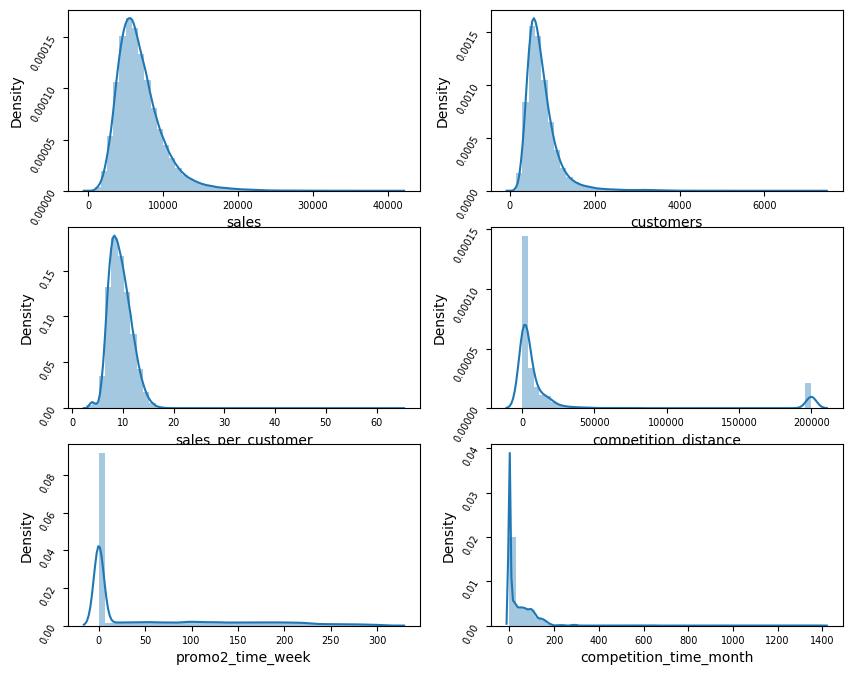

In [57]:
# 4.1.1 Plot Numerical Features
plt.figure( figsize=(10, 8) )
plt.subplot( 3, 2, 1 )
sns.distplot( num_attributes['sales'] );
plt.xticks( rotation=0, fontsize=7 );
plt.yticks( rotation=60, fontsize=7 );
plt.subplot( 3, 2, 2 )
sns.distplot( num_attributes['customers'] );
plt.xticks( rotation=0, fontsize=7 );
plt.yticks( rotation=60, fontsize=7 );
plt.subplot( 3, 2, 3 )
sns.distplot( num_attributes['sales_per_customer'] );
plt.xticks( rotation=0, fontsize=7 );
plt.yticks( rotation=60, fontsize=7 );
plt.subplot( 3, 2, 4 )
sns.distplot( num_attributes['competition_distance'] );
plt.xticks( rotation=0, fontsize=7 );
plt.yticks( rotation=60, fontsize=7 );
plt.subplot( 3, 2, 5 )
sns.distplot( num_attributes['promo2_time_week'] );
plt.xticks( rotation=0, fontsize=7 );
plt.yticks( rotation=60, fontsize=7 );
plt.subplot( 3, 2, 6 )
sns.distplot( num_attributes['competition_time_month'] );
plt.xticks( rotation=0, fontsize=7 );
plt.yticks( rotation=60, fontsize=7 );


#### (i) Sales - Response Variable (original & log)

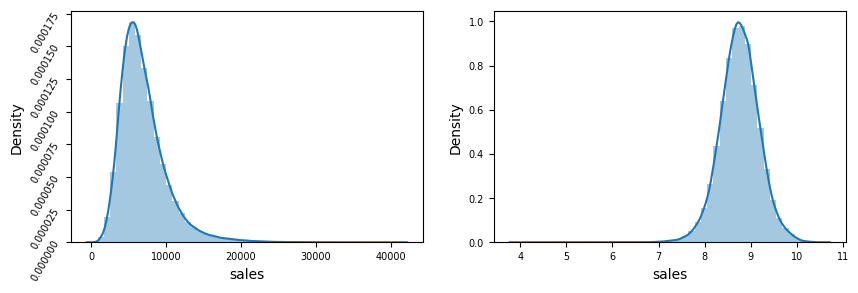

In [58]:
# 4.1 UNIVARIATE ANALYSIS: Response Variable (original & log)
plt.figure( figsize=(10, 3) )
plt.subplot( 1, 2, 1 )
sns.distplot( df4['sales'] );
plt.xticks( fontsize=7 );
plt.yticks( rotation=60, fontsize=7 );
plt.subplot( 1, 2, 2 )
sns.distplot( np.log1p( df4['sales'] ) );
plt.xticks( fontsize=7 );
plt.yticks( fontsize=7 );

#### (ii) Customers

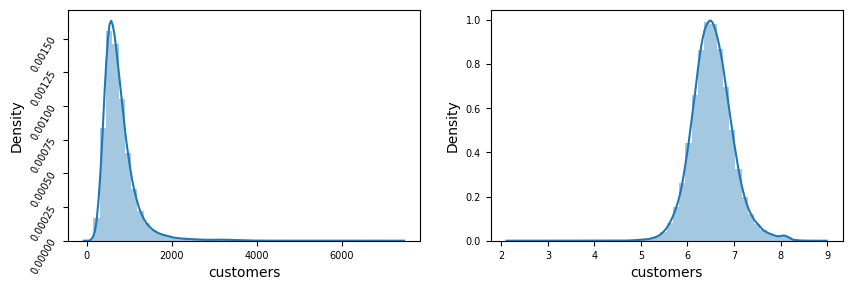

In [59]:
# Competition Distance (original & log)
plt.figure( figsize=(10, 3) )
plt.subplot( 1, 2, 1 )
sns.distplot( num_attributes['customers'] );
plt.xticks( fontsize=7 );
plt.yticks( rotation=60, fontsize=7 );
plt.subplot( 1, 2, 2 )
sns.distplot( np.log1p( num_attributes['customers'] ) );
plt.xticks( fontsize=7 );
plt.yticks( fontsize=7 );

#### (iii) Sales per Customer

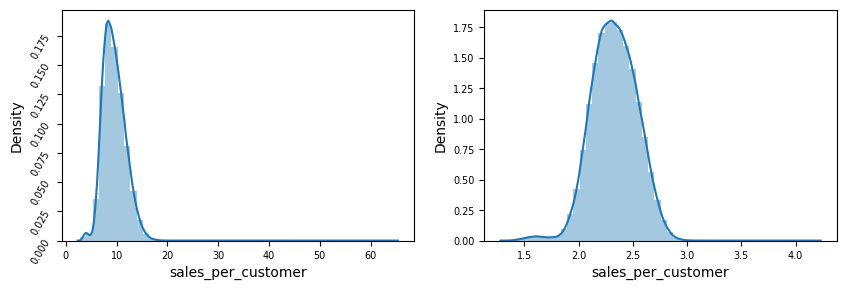

In [60]:
# Competition Distance (original & log)
plt.figure( figsize=(10, 3) )
plt.subplot( 1, 2, 1 )
sns.distplot( num_attributes['sales_per_customer'] );
plt.xticks( fontsize=7 );
plt.yticks( rotation=60, fontsize=7 );
plt.subplot( 1, 2, 2 )
sns.distplot( np.log1p( num_attributes['sales_per_customer'] ) );
plt.xticks( fontsize=7 );
plt.yticks( fontsize=7 );

#### (iv) Competition Distance

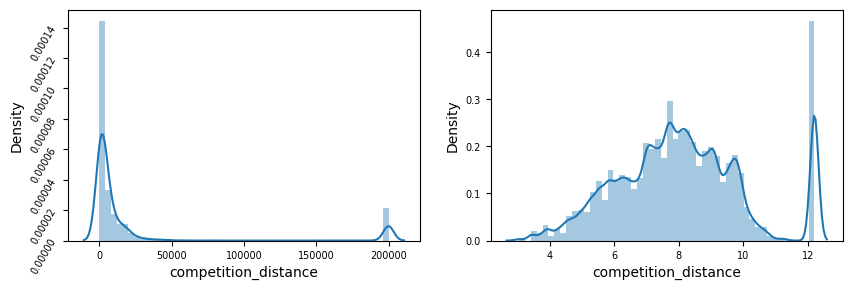

In [61]:
# Competition Distance (original & log)
plt.figure( figsize=(10, 3) )
plt.subplot( 1, 2, 1 )
sns.distplot( num_attributes['competition_distance'] );
plt.xticks( fontsize=7 );
plt.yticks( rotation=60, fontsize=7 );
plt.subplot( 1, 2, 2 )
sns.distplot( np.log1p( num_attributes['competition_distance'] ) );
plt.xticks( fontsize=7 );
plt.yticks( fontsize=7 );

#### (v) promo2_time_week

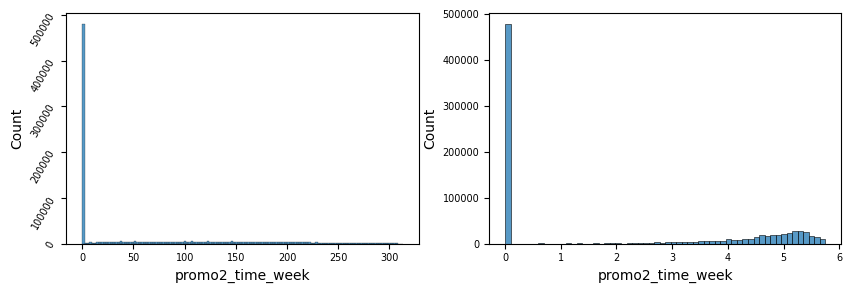

In [62]:
# Competition Distance (original & log)
plt.figure( figsize=(10, 3) )
plt.subplot( 1, 2, 1 )
sns.histplot( num_attributes['promo2_time_week'] );
plt.xticks( fontsize=7 );
plt.yticks( rotation=60, fontsize=7 );
plt.subplot( 1, 2, 2 )
sns.histplot( np.log1p( num_attributes['promo2_time_week'] ) );
plt.xticks( fontsize=7 );
plt.yticks( fontsize=7 );

#### (vi) competition_time_month

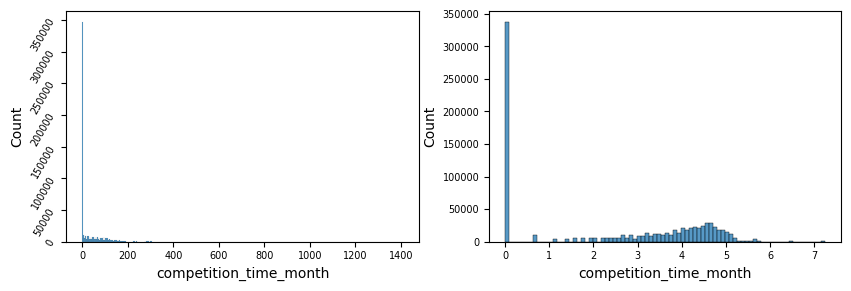

In [63]:
# Competition Distance (original & log)
plt.figure( figsize=(10, 3) )
plt.subplot( 1, 2, 1 )
sns.histplot( num_attributes['competition_time_month'] );
plt.xticks( fontsize=7 );
plt.yticks( rotation=60, fontsize=7 );
plt.subplot( 1, 2, 2 )
sns.histplot( np.log1p( num_attributes['competition_time_month'] ) );
plt.xticks( fontsize=7 );
plt.yticks( fontsize=7 );

### 4.1.2. Categorical Features

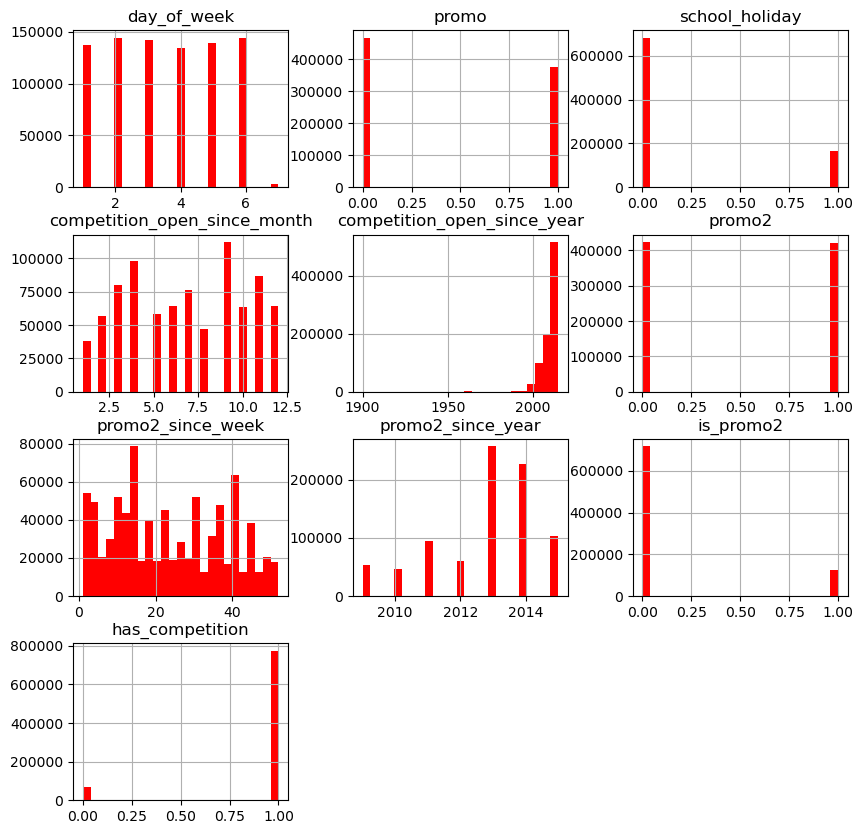

In [64]:
# Plotting categorical features
cols_to_plot = ['day_of_week', 'promo', 'state_holiday', 'school_holiday',
       'store_type', 'assortment', 'competition_open_since_month', 
       'competition_open_since_year', 'promo2', 'promo2_since_week', 
       'promo2_since_year', 'is_promo2', 'has_competition' ]

cat_attributes.hist( column=cols_to_plot, bins=25, figsize=(10,10), color='red' );


In [65]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

store                           1115
day_of_week                        7
date                             942
promo                              2
state_holiday                      4
school_holiday                     2
store_type                         4
assortment                         3
competition_open_since_month      12
competition_open_since_year       23
promo2                             2
promo2_since_week                 52
promo2_since_year                  7
is_promo2                          2
promo2_since                     167
has_competition                    2
competition_since                173
year                               3
month                             12
day                               31
semester                           2
quarter                            4
2months                            6
fortnight_of_year                 24
fortnight_of_month                 2
week_of_year                      52
year_week                        137
d

#### state_holiday

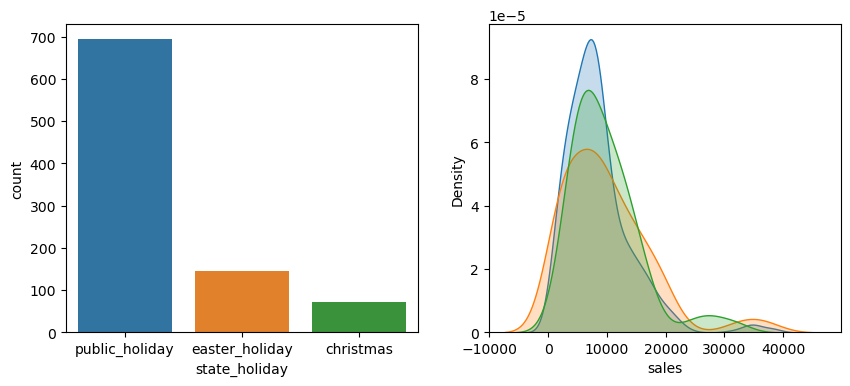

In [66]:
# 4.1.2 Categorical Features Analysis: state_holiday

plt.figure( figsize=(10, 4) )
plt.subplot( 1, 2, 1 )
a = df4[ df4['state_holiday'] != 'regular_day' ]
sns.countplot( x='state_holiday', data=a )

plt.subplot( 1, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True );
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True );
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True );

#### store_type

<Axes: xlabel='sales', ylabel='Density'>

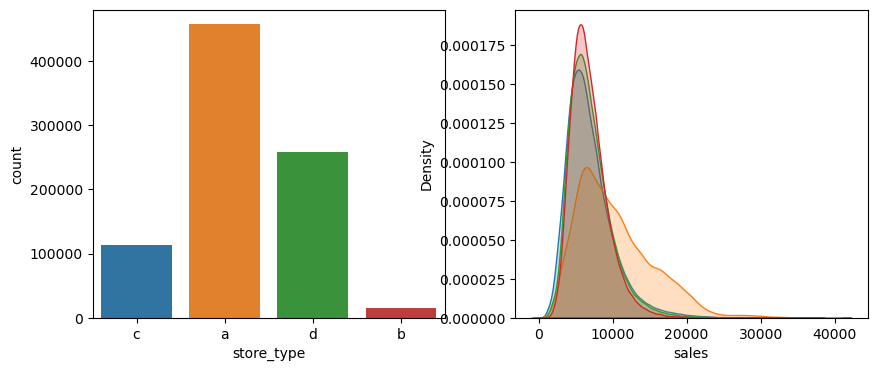

In [67]:
# 4.1.2 Categorical Features Analysis: store_type

plt.figure( figsize=(10, 4) )
plt.subplot( 1, 2, 1 )
sns.countplot( x='store_type', data=df4 )

plt.subplot( 1, 2, 2 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )

#### assortment

In [68]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<Axes: xlabel='sales', ylabel='Density'>

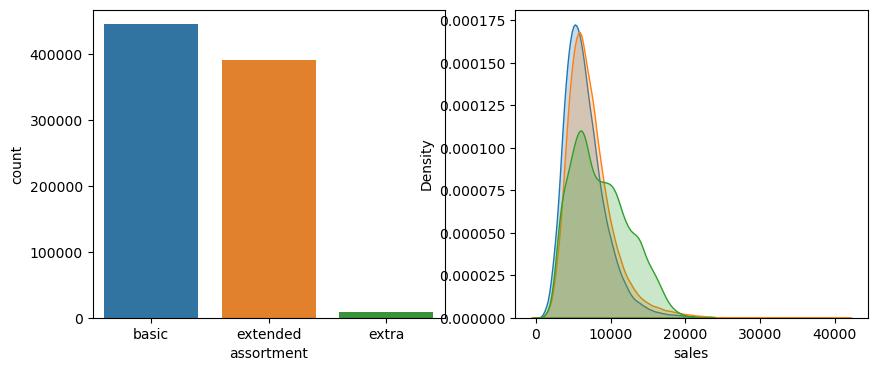

In [69]:
# 4.1.2 Categorical Features Analysis: assortment

plt.figure( figsize=(10, 4) )
plt.subplot( 1, 2, 1 )
sns.countplot( x='assortment', data=df4 )

plt.subplot( 1, 2, 2 )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True )

## 4.2. Bivariate Analysis

In [70]:
# Aim: understand the impact of each attribute to the response variable.

### 4.2.0 Total Daily Averages

In [71]:
avg_Sales_tot = df4.loc[:, 'sales'].mean().round(2)
avg_Customers_tot = df4.loc[:, 'customers'].mean().round(2)
avg_SalesPerCustomer_tot = df4.loc[:, 'sales_per_customer'].mean().round(2)

mdn_Sales_tot = df4.loc[:, 'sales'].median()
mdn_Customers_tot = df4.loc[:, 'customers'].median()
mdn_SalesPerCustomer_tot = df4.loc[:, 'sales_per_customer'].median()

df = pd.DataFrame({
    'avg_Sales_tot':avg_Sales_tot,
    'mdn_Sales_tot':mdn_Sales_tot,
    'avg_Customers_tot':avg_Customers_tot,
    'mdn_Customers_tot':mdn_Customers_tot,
    'avg_SalesPerCustomer_tot':avg_SalesPerCustomer_tot,
    'mdn_SalesPerCustomer_tot':mdn_SalesPerCustomer_tot
}, index=[0])

df.T


0
avg_Sales_tot             6955.96
mdn_Sales_tot             6369.00
avg_Customers_tot          762.78
mdn_Customers_tot          676.00
avg_SalesPerCustomer_tot     9.49
mdn_SalesPerCustomer_tot     9.25

### 4.2.1 Sazonalities

#### Day of Week (important)

The tabulated data and plottings bellow indicate the following:
1. SUNDAYS (weekday=7): differ from the other days, due to havving only 33 stores open. These 33 stores should be prepared to receive a duplicated amount of consumers (in average), and each one willing to buy cheaper products, since just 2/3 of the sales (in median) occur on Sundays.
2. MONDAYS (weekday=1): the selling statistics are stronger, considering the higher total daily sales (in median), the higher number of daily sales per customer (in median), and the second higher number of daily customers (in median).
3. SATURDAYS (weekday=6): the selling statistics are the weakest ones, considering the lowest number in average sales and average number of customers. Nevertheless, that may be due to the reduced working hours, from 9 a.m. to 1 p.m., according to "https://www.bonn.de/microsite/en/services/medical-care/pharmacies.php#:~:text=A%20pharmacy%20in%20Germany%20is,to%201%20p.m.%20on%20Saturdays."

day.of.week  open.stores  avg.sales  mdn.sales  avg.customers  \
0          1.0       1115.0    8216.25     7539.0         855.46   
1          2.0       1115.0    7088.41     6502.0         770.02   
2          3.0       1115.0    6728.79     6210.0         740.67   
3          4.0       1115.0    6768.21     6246.0         755.67   
4          5.0       1115.0    7073.03     6581.0         781.81   
5          6.0       1115.0    5875.08     5425.0         660.21   
6          7.0         33.0    8224.72     6876.0        1441.53   

   mdn.customers  mdn.sales/customer  
0          769.0                9.62  
1          684.0                9.31  
2          658.0                9.24  
3          673.0                9.11  
4          698.0                9.19  
5          573.0                9.13  
6         1262.0                6.19

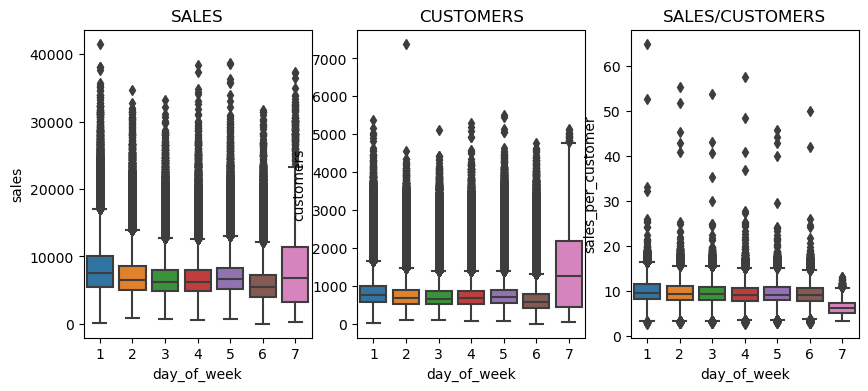

In [72]:
# N# of unique stores open per weekday
num_open_stores = df4.loc[:, ['day_of_week', 'store']].groupby('day_of_week').nunique().reset_index()
# Avg Sales per weekday
Avg_Sales = df4.loc[:, ['day_of_week', 'sales']].groupby('day_of_week').mean().reset_index()
# Median Sales per weekday
Mdn_Sales = df4.loc[:, ['day_of_week', 'sales']].groupby('day_of_week').median().reset_index()
# Avg Customers per weekday
Avg_Customers = df4.loc[:, ['day_of_week', 'customers']].groupby('day_of_week').mean().reset_index()
# Median Customers per weekday
Mdn_Customers = df4.loc[:, ['day_of_week', 'customers']].groupby('day_of_week').median().reset_index()
# Median Sales per Customer per weekday
Mdn_SalesPerCustomer = df4.loc[:, ['day_of_week', 'sales_per_customer']].groupby('day_of_week').median().reset_index()

# drop col
Avg_Sales.drop('day_of_week', inplace=True, axis=1)
Mdn_Sales.drop('day_of_week', inplace=True, axis=1)
Avg_Customers.drop('day_of_week', inplace=True, axis=1)
Mdn_Customers.drop('day_of_week', inplace=True, axis=1)
Mdn_SalesPerCustomer.drop('day_of_week', inplace=True, axis=1)

# Concat metrics
week_metrics = pd.concat( [num_open_stores.T, Avg_Sales.T, Mdn_Sales.T, Avg_Customers.T, Mdn_Customers.T, Mdn_SalesPerCustomer.T] ).round(2).T
week_metrics.columns = [ 'day.of.week', 'open.stores', 'avg.sales', 'mdn.sales', 'avg.customers', 'mdn.customers', 'mdn.sales/customer' ]


# Plottings
plt.figure( figsize=(10, 4) )
plt.subplot( 1, 3, 1)
sns.boxplot( x='day_of_week', y='sales', data=df4 );
plt.title("SALES");
plt.subplot( 1, 3, 2)
sns.boxplot( x='day_of_week', y='customers', data=df4 );
plt.title("CUSTOMERS");
plt.subplot( 1, 3, 3)
sns.boxplot( x='day_of_week', y='sales_per_customer', data=df4 );
plt.title("SALES/CUSTOMERS");

week_metrics

#### Month (important)

The tabulated data and plottings bellow indicate the following:
1. DECEMBER: Revenue impacted by Christmas. The selling statistics are the strongest, considering daily sales, number of customers, and sales per customer.
2. NOVEMBER: Second stronger month, possibly caused by Black Friday Sales.
3. MAY: Third stronger month, probably caused by Mother's Day.
4. SEPTEMBER, JANUARY & FEBRUARY: these months show the lowest selling statistics.

month  avg.Sales  mdn.Sales  avg.Customers  mdn.Customers  \
11   12.0    8608.96     7858.0         886.63          780.0   
10   11.0    7188.55     6691.0         782.67          697.0   
4     5.0    7106.81     6592.0         779.33          691.0   
3     4.0    7046.66     6431.0         774.32          686.0   
5     6.0    7001.40     6365.0         759.32          672.0   
2     3.0    6976.82     6385.0         759.13          673.0   
6     7.0    6953.58     6407.0         752.84          664.0   
7     8.0    6649.23     6124.0         750.41          665.0   
9    10.0    6602.97     6105.0         752.59          669.0   
1     2.0    6589.49     6079.0         731.54          651.0   
0     1.0    6564.30     6062.0         722.58          646.0   
8     9.0    6547.47     6000.0         745.74          665.0   

    avg.Sales/Custm  mdn.Sales/Custm  
11            10.05             9.80  
10             9.60             9.36  
4              9.54             9.32  
3              9.47             9.23  
5              9.60             9.35  
2              9.56             9.31  
6              9.64             9.42  
7              9.25             9.02  
9              9.18             8.92  
1              9.39             9.14  
0              9.45             9.19  
8              9.13             8.89

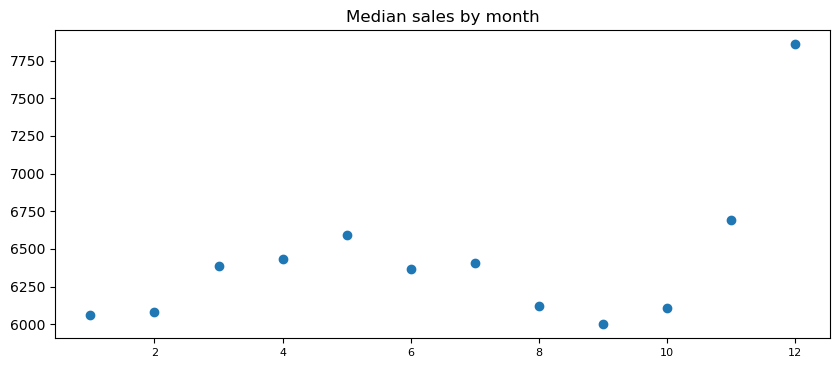

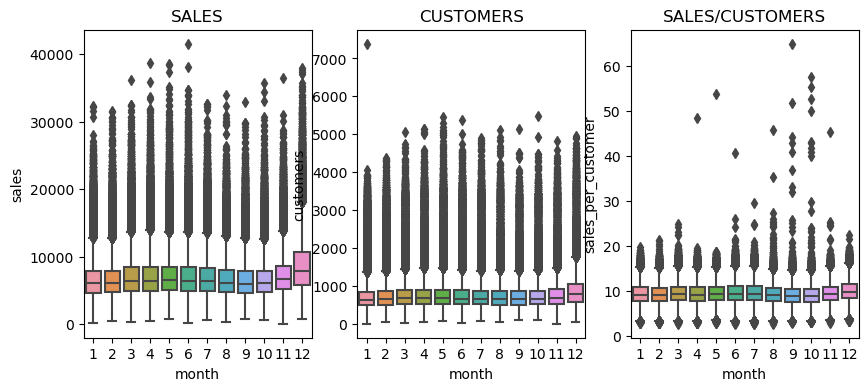

In [73]:
# Avg & Median Sales per month
Avg_Sales_Month = df4.loc[:, ['month','sales']].groupby('month').mean().reset_index()
Mdn_Sales_Month = df4.loc[:, ['month','sales']].groupby('month').median().reset_index()
# Avg & Median Customers per month
Avg_Customers_Month = df4.loc[:, ['month','customers']].groupby('month').mean().reset_index()
Mdn_Customers_Month = df4.loc[:, ['month','customers']].groupby('month').median().reset_index()
# Avg & Median Customers per Sales per month
Avg_SalesPerCustomer_Month = df4.loc[:, ['month','sales_per_customer']].groupby('month').mean().reset_index()
Mdn_SalesPerCustomer_Month = df4.loc[:, ['month','sales_per_customer']].groupby('month').median().reset_index()
# drop col...
Mdn_Sales_Month.drop('month', inplace=True, axis=1)
Avg_Customers_Month.drop('month', inplace=True, axis=1)
Mdn_Customers_Month.drop('month', inplace=True, axis=1)
Avg_SalesPerCustomer_Month.drop('month', inplace=True, axis=1)
Mdn_SalesPerCustomer_Month.drop('month', inplace=True, axis=1)
# Concat metrics
month_metrics = pd.concat([Avg_Sales_Month.T, Mdn_Sales_Month.T, 
                           Avg_Customers_Month.T, Mdn_Customers_Month.T, 
                           Avg_SalesPerCustomer_Month.T, Mdn_SalesPerCustomer_Month.T]).round(2).T
month_metrics.columns = ['month','avg.Sales','mdn.Sales','avg.Customers','mdn.Customers','avg.Sales/Custm','mdn.Sales/Custm']

# plotting
plt.figure( figsize=(10, 4) )
plt.scatter(month_metrics['month'], month_metrics['mdn.Sales'] );
plt.xticks(rotation=0, fontsize=8);
plt.title('Median sales by month');

# Boxplot
plt.figure( figsize=(10, 4) )
plt.subplot( 1, 3, 1)
sns.boxplot( x='month', y='sales', data=df4 );
plt.title("SALES");
plt.subplot( 1, 3, 2)
sns.boxplot( x='month', y='customers', data=df4 );
plt.title("CUSTOMERS");
plt.subplot( 1, 3, 3)
sns.boxplot( x='month', y='sales_per_customer', data=df4 );
plt.title("SALES/CUSTOMERS");

# Table
month_metrics.sort_values('avg.Sales', ascending=False)

#### Day (important)

The tabulated data and plottings bellow indicate the following:
1. There is a clear seasonal behaviour, showing two periods of peak and two periods of valey.
2. The strongest peak occur from the 29th up to the 4th or 5th of the following month, possibly due to salary payments in the economy.
3. Another peak occur in the 3rd week, between the 16th and 19th
4. The weakest periods occur between the 10th and 13th, and again in two weeks, between the 24th and 26th.

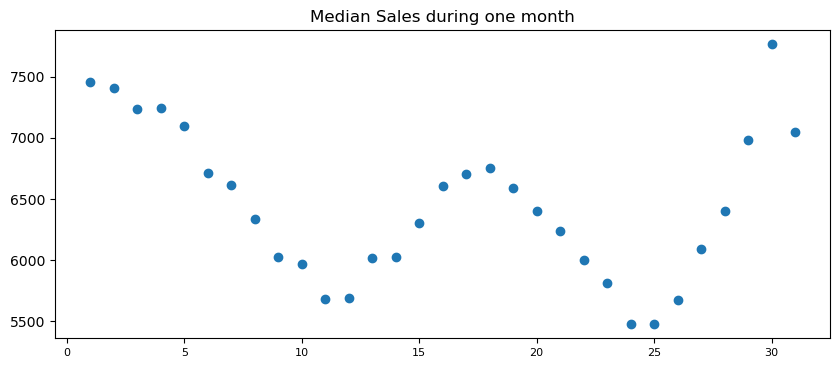

In [74]:
# Find the mean & sum of Sales per days
AvgSales = df4.loc[:, ['day', 'sales']].groupby('day').mean().reset_index()
AvgSales.columns = [ 'day', 'avg_sales' ]
MdnSales = df4.loc[:, ['day', 'sales']].groupby('day').median().reset_index()
MdnSales.columns = [ 'day', 'median_sales' ]
# Join it all
df_sales_day = pd.merge( AvgSales, MdnSales, how='inner', on='day' ).sort_values('median_sales', ascending=False).round(0)
# plotting
plt.figure( figsize=(10, 4) )
plt.scatter(df_sales_day['day'], df_sales_day['median_sales'] );
plt.xticks(rotation=0, fontsize=8);
plt.title('Median Sales during one month');

#### Week of Year

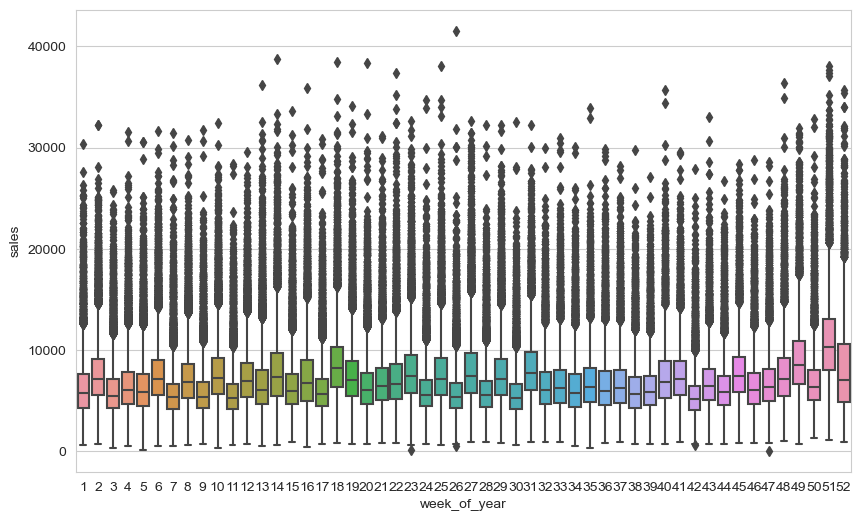

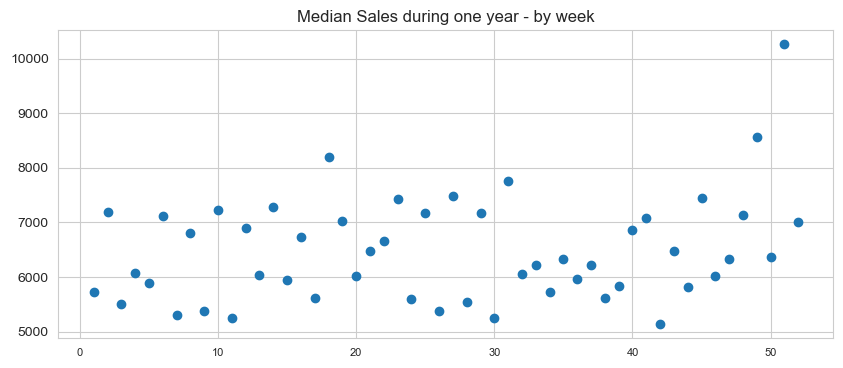

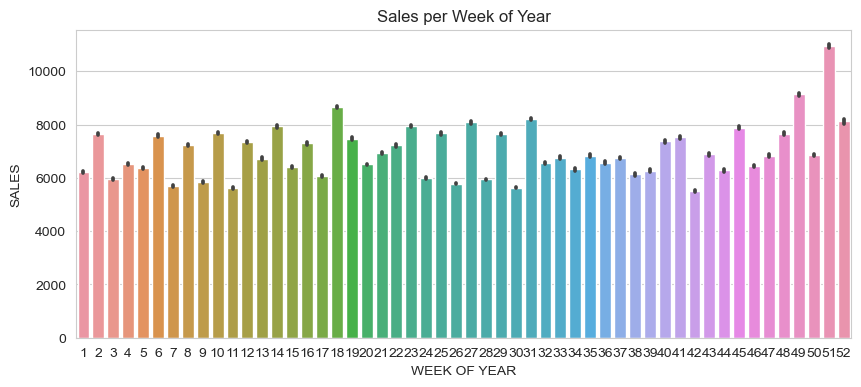

In [75]:
# Find the mean & sum of Sales per week_of_year
aux11 = df4.loc[:, ['week_of_year', 'sales']].copy()
AvgSales = aux11.groupby('week_of_year').mean().reset_index()
AvgSales.columns = [ 'week_of_year', 'avg_sales' ]
MdnSales = aux11.groupby('week_of_year').median().reset_index()
MdnSales.columns = [ 'week_of_year', 'median_sales' ]
SumSales = aux11.groupby('week_of_year').sum().reset_index()
SumSales.columns = [ 'week_of_year', 'sum_sales' ]

# Join it all
df_sales_weekyear = pd.merge( AvgSales, MdnSales, how='inner', on='week_of_year' )
df_sales_weekyear = pd.merge( df_sales_weekyear, SumSales, how='inner', on='week_of_year' ).sort_values('median_sales', ascending=False).round(0)

# Boxplot
plt.figure( figsize=(10, 6) )
sns.set_style("whitegrid")
sns.boxplot( x='week_of_year', y='sales', data=df4 );

# Scatter Plotting
plt.figure( figsize=(10, 4) )
plt.scatter(df_sales_weekyear['week_of_year'], df_sales_weekyear['median_sales'] );
plt.xticks(rotation=0, fontsize=8);
plt.title('Median Sales during one year - by week');

# Barplot
plt.figure(figsize=(10,4))
sns.barplot(df4, x='week_of_year', y='sales');
plt.title('Sales per Week of Year');
plt.xlabel("WEEK OF YEAR");
plt.ylabel("SALES");

#### Quarter

The tabulated data and plottings bellow indicate the following:
1. The 4th quarter shows the strongest sales, which is probably related to the occurences of Christmas and Black Friday.
2. The 2nd quarter is the second best of the year, being probably related to Mother's Day.

quarter  avg_sales  median_sales   sum_sales
3        4     7449.0        6764.0  1155208758
1        2     7051.0        6465.0  1723256287
2        3     6757.0        6214.0  1299420538
0        1     6713.0        6172.0  1695295040

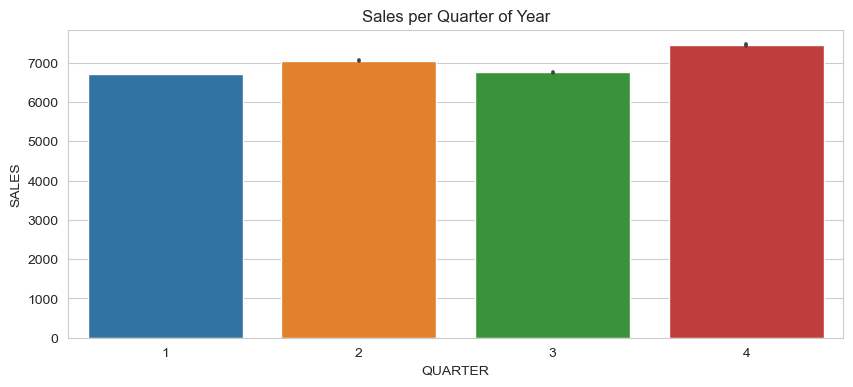

In [76]:
# Find the mean & sum of Sales per Quarter
aux11 = df4.loc[:, ['quarter', 'sales']].copy()
AvgSales = aux11.groupby('quarter').mean().reset_index()
AvgSales.columns = [ 'quarter', 'avg_sales' ]
MdnSales = aux11.groupby('quarter').median().reset_index()
MdnSales.columns = [ 'quarter', 'median_sales' ]
SumSales = aux11.groupby('quarter').sum().reset_index()
SumSales.columns = [ 'quarter', 'sum_sales' ]
# Join it all
df_sales_quarter = pd.merge( AvgSales, MdnSales, how='inner', on='quarter' )
df_sales_quarter = pd.merge( df_sales_quarter, SumSales, how='inner', on='quarter' ).sort_values('median_sales', ascending=False).round(0)

# Plotting
plt.figure(figsize=(10,4))
sns.barplot(df4, x='quarter', y='sales');
plt.title('Sales per Quarter of Year');
plt.xlabel("QUARTER");
plt.ylabel("SALES");

df_sales_quarter

#### Semester

semester  avg_sales  median_sales   sum_sales
1         1     7066.0        6452.0  2454629296
0         0     6879.0        6315.0  3418551327

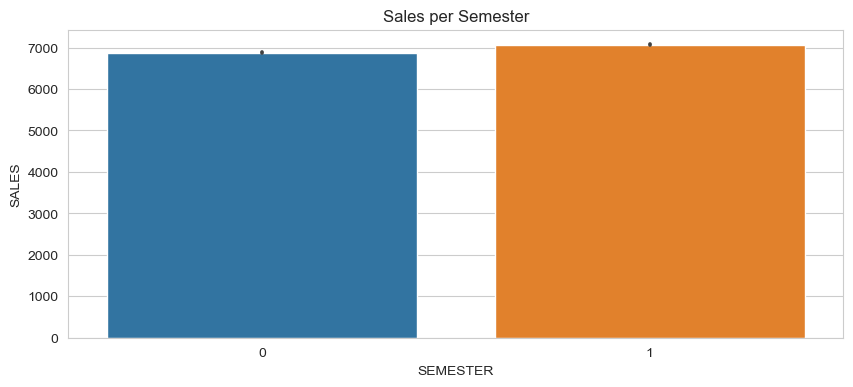

In [77]:
# Find the mean & sum of Sales per semester
aux11 = df4.loc[:, ['semester', 'sales']].copy()
AvgSales = aux11.groupby('semester').mean().reset_index()
AvgSales.columns = [ 'semester', 'avg_sales' ]
MdnSales = aux11.groupby('semester').median().reset_index()
MdnSales.columns = [ 'semester', 'median_sales' ]
SumSales = aux11.groupby('semester').sum().reset_index()
SumSales.columns = [ 'semester', 'sum_sales' ]
# Join it all
df_sales_semester = pd.merge( AvgSales, MdnSales, how='inner', on='semester' )
df_sales_semester = pd.merge( df_sales_semester, SumSales, how='inner', on='semester' ).sort_values('median_sales', ascending=False).round(0)

# Plotting
plt.figure(figsize=(10,4))
sns.barplot(df4, x='semester', y='sales')
plt.title('Sales per Semester')
plt.xlabel("SEMESTER")
plt.ylabel("SALES")

df_sales_semester

#### Two Months

2months  avg_sales  median_sales   sum_sales
5        6     7892.0        7181.0   803330030
2        3     7053.0        6480.0  1147360992
1        2     7011.0        6407.0  1175727201
3        4     6835.0        6299.0   956850407
0        1     6576.0        6070.0  1095463134
4        5     6575.0        6053.0   694448859

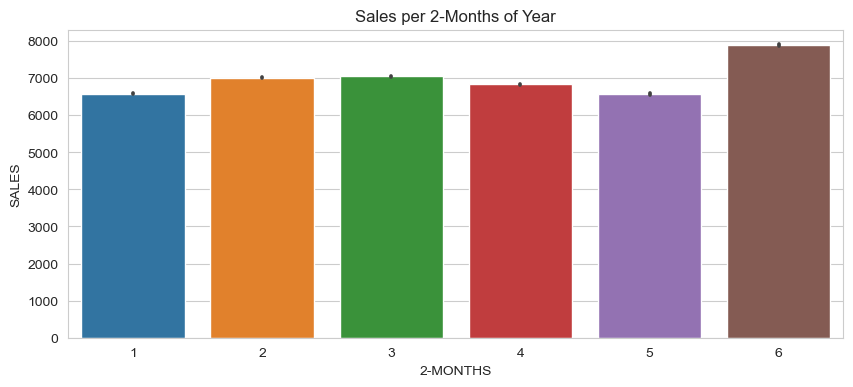

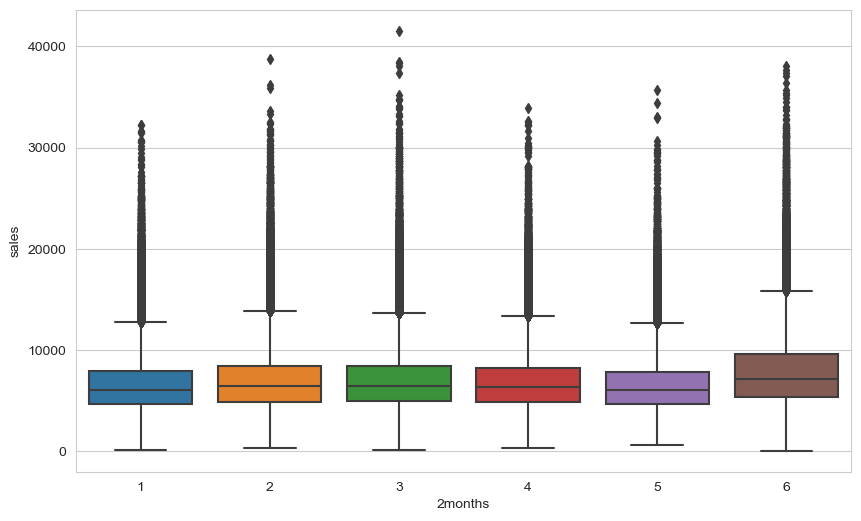

In [78]:
# Find the mean & sum of Sales per 2months
aux11 = df4.loc[:, ['2months', 'sales']].copy()
AvgSales = aux11.groupby('2months').mean().reset_index()
AvgSales.columns = [ '2months', 'avg_sales' ]
MdnSales = aux11.groupby('2months').median().reset_index()
MdnSales.columns = [ '2months', 'median_sales' ]
SumSales = aux11.groupby('2months').sum().reset_index()
SumSales.columns = [ '2months', 'sum_sales' ]
# Join it all
df_sales_2month = pd.merge( AvgSales, MdnSales, how='inner', on='2months' )
df_sales_2month = pd.merge( df_sales_2month, SumSales, how='inner', on='2months' ).sort_values('median_sales', ascending=False).round(0)

# Plotting
plt.figure(figsize=(10,4))
sns.barplot(df4, x='2months', y='sales');
plt.title('Sales per 2-Months of Year');
plt.xlabel("2-MONTHS");
plt.ylabel("SALES");

# Boxplot
plt.figure( figsize=(10, 6) )
sns.set_style("whitegrid")
sns.boxplot( x='2months', y='sales', data=df4 );

df_sales_2month

#### Fortnight of Year

- No big benefit, compared to monthly sales

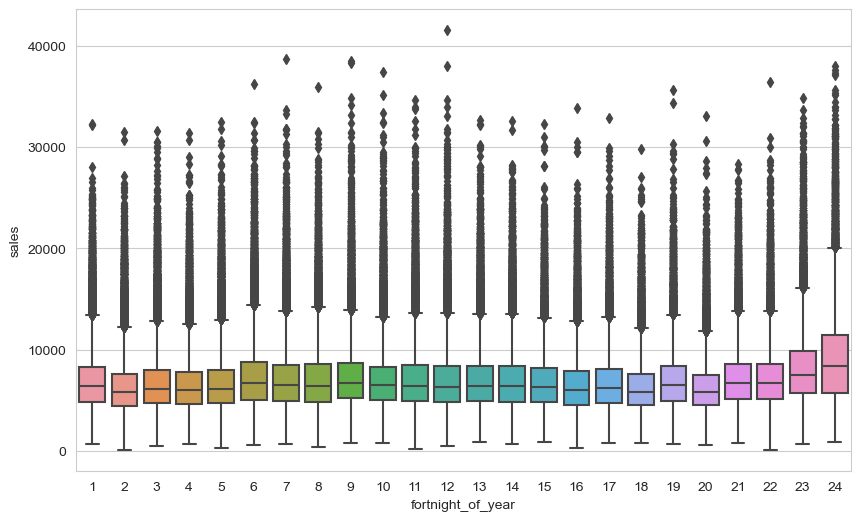

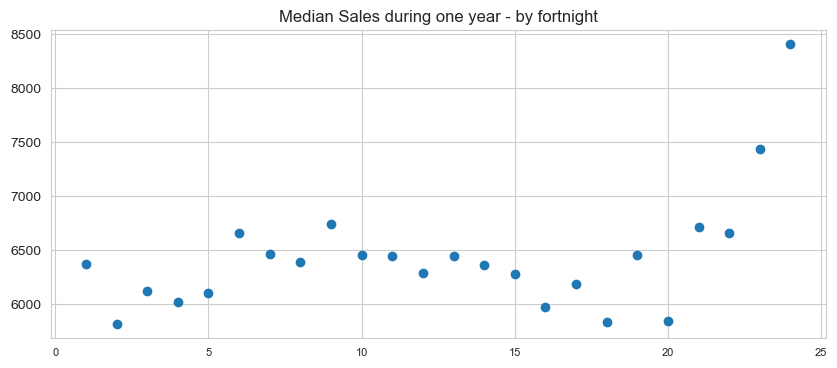

In [79]:
# Find the mean & sum of Sales per fortnight_of_year
aux11 = df4.loc[:, ['fortnight_of_year', 'sales']].copy()
AvgSales = aux11.groupby('fortnight_of_year').mean().reset_index()
AvgSales.columns = [ 'fortnight_of_year', 'avg_sales' ]
MdnSales = aux11.groupby('fortnight_of_year').median().reset_index()
MdnSales.columns = [ 'fortnight_of_year', 'median_sales' ]
SumSales = aux11.groupby('fortnight_of_year').sum().reset_index()
SumSales.columns = [ 'fortnight_of_year', 'sum_sales' ]

# Join it all
df_sales_fortny = pd.merge( AvgSales, MdnSales, how='inner', on='fortnight_of_year' )
df_sales_fortny = pd.merge( df_sales_fortny, SumSales, how='inner', on='fortnight_of_year' ).sort_values('median_sales', ascending=False).round(0)

# Boxplot
plt.figure( figsize=(10, 6) )
sns.set_style("whitegrid")
sns.boxplot( x='fortnight_of_year', y='sales', data=df4 );

# Scatter Plotting
plt.figure( figsize=(10, 4) )
plt.scatter(df_sales_fortny['fortnight_of_year'], df_sales_fortny['median_sales'] );
plt.xticks(rotation=0, fontsize=8);
plt.title('Median Sales during one year - by fortnight');

#### Fortnight of Month

- No strong information.

In [80]:
# Find the mean & sum of Sales per fortnight_of_month
aux11 = df4.loc[:, ['fortnight_of_month', 'sales']].copy()
AvgSales = aux11.groupby('fortnight_of_month').mean().reset_index()
AvgSales.columns = [ 'fortnight_of_month', 'avg_sales' ]
MdnSales = aux11.groupby('fortnight_of_month').median().reset_index()
MdnSales.columns = [ 'fortnight_of_month', 'median_sales' ]
SumSales = aux11.groupby('fortnight_of_month').sum().reset_index()
SumSales.columns = [ 'fortnight_of_month', 'sum_sales' ]

# Join it all
df_sales_fortnm = pd.merge( AvgSales, MdnSales, how='inner', on='fortnight_of_month' )
df_sales_fortnm = pd.merge( df_sales_fortnm, SumSales, how='inner', on='fortnight_of_month' ).sort_values('median_sales', ascending=False).round(0)
df_sales_fortnm

fortnight_of_month  avg_sales  median_sales   sum_sales
0                   0     7011.0        6446.0  2895721225
1                   1     6903.0        6293.0  2977459398

### 4.2.2. Store Type (important)

#### (1) Total Base Indicators (important)

The table information & plottings bellow indicate that:
1. TYPE-B Store: these 17 units can be called POPUPAR STORES, since they are prepared to receive more than 2.000 customers a day, about 2,5x the frequency of customers the other units attend. Besides that, the value of the products purchased by customers in TYPE-B stores is almost half the value occurred on the other stores, indicating these TYPE-B stores deal with less expensive products (or: popular products)
2. TYPE-D: these 348 units can be called SOFISTICATED STORES, since they deal with most expensive products.
3. TYPES A & C: these 750 units can be called NORMAL STORES, due to the higher number of these stores and the medium priced products they deal. On the other hand, the dataset information does not allow us to differentiate stores A & C.

0   1    2    3
store_type    a   b    c    d
Qtty        602  17  148  348

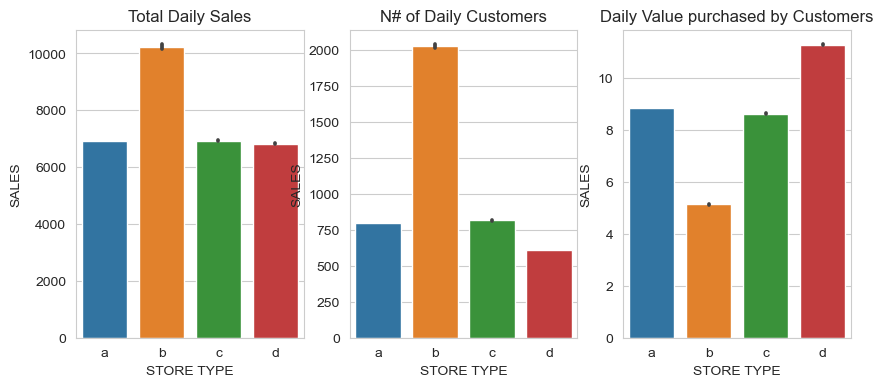

In [81]:
plt.figure(figsize=(10,4))
# Sales vs Store-type
plt.subplot(1,3,1)
sns.barplot(df4, x='store_type', y='sales', order='abcd');
plt.title('Total Daily Sales');
plt.xlabel("STORE TYPE");
plt.ylabel("SALES");
# Customers per Store-type
plt.subplot(1,3,2)
sns.barplot(df4, x='store_type', y='customers', order='abcd');
plt.title('N# of Daily Customers');
plt.xlabel("STORE TYPE");
plt.ylabel("SALES");
# Sales/Customer per Store-type
plt.subplot(1,3,3)
sns.barplot(df4, x='store_type', y='sales_per_customer', order='abcd');
plt.title('Daily Value purchased by Customers');
plt.xlabel("STORE TYPE");
plt.ylabel("SALES");

# N# of unique stores per type
num_stores_type = df4.loc[:, ['store_type', 'store']].groupby('store_type').nunique().reset_index()
num_stores_type.columns = ['store_type', 'Qtty']
num_stores_type.T

#### (2) Store-Types on Sundays

The table information & plottings bellow indicate that:
1. All 17 TYPE-B stores are open on sundays, receiving the same number of costumers (in average).

0   1  2
store_type   a   b  d
Qtty        13  17  3

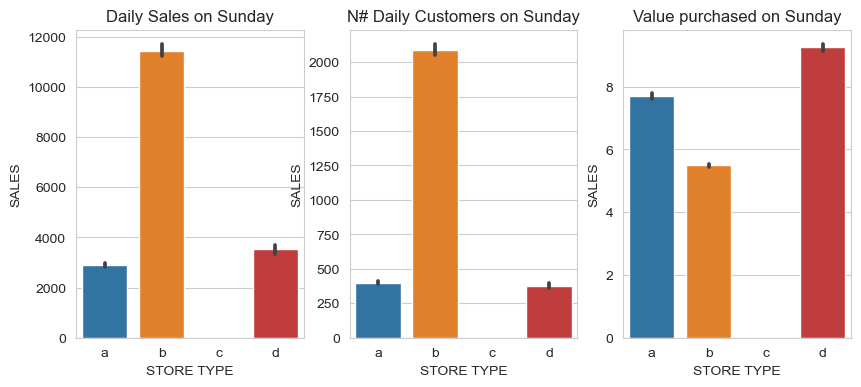

In [82]:
aux = df4.loc[ df4['day_of_week']==7 ].copy()
plt.figure(figsize=(10,4))
# Sales vs Store-type
plt.subplot(1,3,1)
sns.barplot(aux, x='store_type', y='sales', order='abcd');
plt.title('Daily Sales on Sunday');
plt.xlabel("STORE TYPE");
plt.ylabel("SALES");
# Customers per Store-type
plt.subplot(1,3,2)
sns.barplot(aux, x='store_type', y='customers', order='abcd');
plt.title('N# Daily Customers on Sunday');
plt.xlabel("STORE TYPE");
plt.ylabel("SALES");
# Sales/Customer per Store-type
plt.subplot(1,3,3)
sns.barplot(aux, x='store_type', y='sales_per_customer', order='abcd');
plt.title('Value purchased on Sunday');
plt.xlabel("STORE TYPE");
plt.ylabel("SALES");

# N# of unique stores per type
num_stores_type = aux.loc[:, ['store_type', 'store']].groupby('store_type').nunique().reset_index()
num_stores_type.columns = ['store_type', 'Qtty']
num_stores_type.T

#### (3) Store-Types from September to December

- The table information & plottings bellow indicate that, from september (weak month) to december (strong month) all types of stores have increments on SALES, N# OF CUSTOMERS and VALUE PURCHASED.

0   1    2    3
store_type    a   b    c    d
Qtty        602  17  148  348

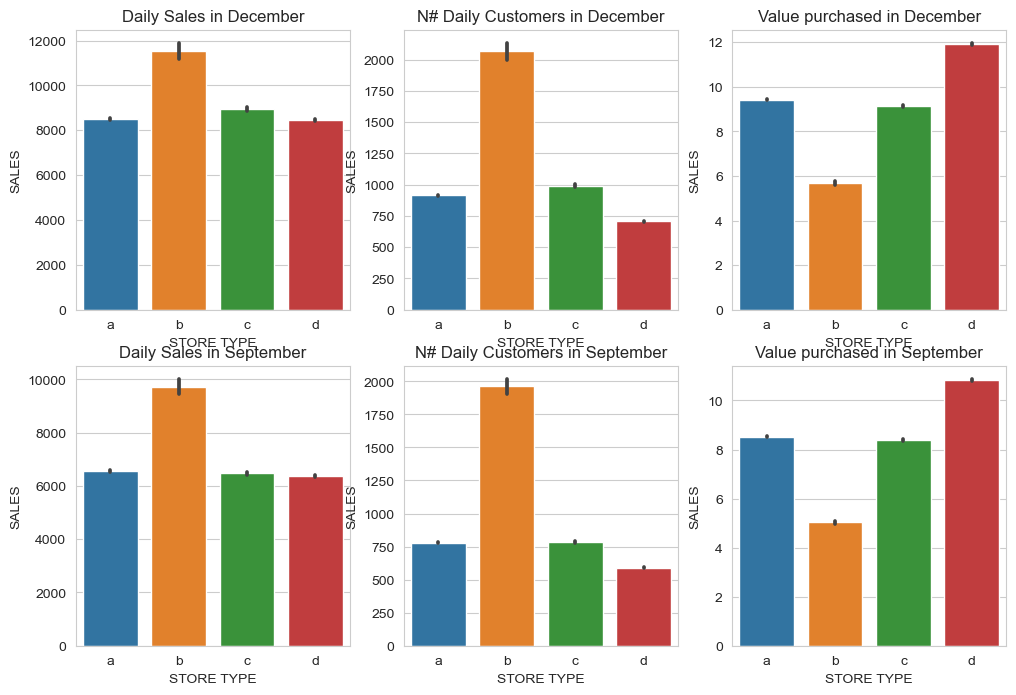

In [83]:
aux = df4.loc[ df4['month']==12 ].copy()
plt.figure(figsize=(12,8))
# Sales vs Store-type
plt.subplot(2,3,1)
sns.barplot(aux, x='store_type', y='sales', order='abcd');
plt.title('Daily Sales in December');
plt.xlabel("STORE TYPE");
plt.ylabel("SALES");
# Customers per Store-type
plt.subplot(2,3,2)
sns.barplot(aux, x='store_type', y='customers', order='abcd');
plt.title('N# Daily Customers in December');
plt.xlabel("STORE TYPE");
plt.ylabel("SALES");
# Sales/Customer per Store-type
plt.subplot(2,3,3)
sns.barplot(aux, x='store_type', y='sales_per_customer', order='abcd');
plt.title('Value purchased in December');
plt.xlabel("STORE TYPE");
plt.ylabel("SALES");

aux = df4.loc[ df4['month']==9 ].copy()
# Sales vs Store-type
plt.subplot(2,3,4)
sns.barplot(aux, x='store_type', y='sales', order='abcd');
plt.title('Daily Sales in September');
plt.xlabel("STORE TYPE");
plt.ylabel("SALES");
# Customers per Store-type
plt.subplot(2,3,5)
sns.barplot(aux, x='store_type', y='customers', order='abcd');
plt.title('N# Daily Customers in September');
plt.xlabel("STORE TYPE");
plt.ylabel("SALES");
# Sales/Customer per Store-type
plt.subplot(2,3,6)
sns.barplot(aux, x='store_type', y='sales_per_customer', order='abcd');
plt.title('Value purchased in September');
plt.xlabel("STORE TYPE");
plt.ylabel("SALES");

# N# of unique stores per type
num_stores_type = aux.loc[:, ['store_type', 'store']].groupby('store_type').nunique().reset_index()
num_stores_type.columns = ['store_type', 'Qtty']
num_stores_type.T

### 4.2.3. Assortment (important)

#### (1) Total Base Indicators (important)

The table information & plottings bellow indicate that:
1. Basic-Assortment & Extended-Assortment Stores represent more than 99% of total units.
2. Extended-Assortment Stores: represent 46% of the total units. Each unit sells to ~752 customers per day (in average), each sell costing ~ 10 euros.
3. Basic-Assortment Stores: represent 53% of the total units. Each unit sells to ~748 customers per day (in average), each sell costing ~ 9 euros.
4. Extra-Assortment Stores: represent less than 1% of the total units. Each of its 9 units sells to ~2.068 customers per day (in average), each sell costing ~ 4 euros.

0         1      2
assortment  basic  extended  extra
Qtty          593       513      9

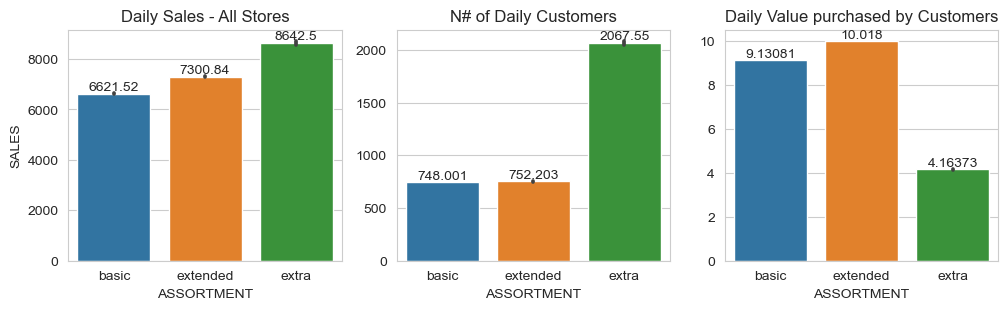

In [84]:
plt.figure(figsize=(12,3))
# Sales vs Assortment
plt.subplot(1,3,1)
b1 = sns.barplot(df4, x='assortment', y='sales');
for i in b1.containers:
    b1.bar_label(i,)
plt.title('Daily Sales - All Stores');
plt.xlabel("ASSORTMENT");
plt.ylabel("SALES");
# Customers per Assortment
plt.subplot(1,3,2)
b2 = sns.barplot(df4, x='assortment', y='customers');
for i in b2.containers:
    b2.bar_label(i,)
plt.title('N# of Daily Customers');
plt.xlabel("ASSORTMENT");
plt.ylabel(" ");
# Sales/Customer per Assortment
plt.subplot(1,3,3)
b3 = sns.barplot(df4, x='assortment', y='sales_per_customer');
for i in b3.containers:
    b3.bar_label(i,)
plt.title('Daily Value purchased by Customers');
plt.xlabel("ASSORTMENT");
plt.ylabel(" ");

assortment = df4.loc[:, ['assortment', 'store']].groupby('assortment').nunique().reset_index()
assortment.columns = ['assortment', 'Qtty']
assortment.T

#### (2) Assortment & Store-Type (important)

The table information & plottings bellow indicate that:
1. BASIC-ASSORTMENT STORES: for types A, C & D basic-assortment stores, the values of purchases per customer are (in average) reduced by less than 2%, compared to the result of all stores. On the other hand, the 7 type-B basic-assortment stores have purchases per customer 22,4% higher, compared to the results of all stores.
2. EXTENDED-ASSORTMENT STORES: all these 513 stores have average daily sales ~5,8% higher than the other stores. All them have higher purchases per customer, compared to the results of the whole company.
3. There is only one Type-B Extended-Assortment Store (n# 562). It sells to ~3.105 customers per day (in average), each buying ~ 5,76 euros (average).
4. EXTRA-ASSORTMENT STORES: these 9 units are all "Type-B" Stores. They represent less than 1% of the total units. They sell to ~2.068 customers per day (in average), each customer buying ~ 4,16 euros (average). PS: They all open on Sundays.

assortment  Store-A  Store-B  Store-C  Store-D  Total
0      basic    381.0        7     77.0    128.0    593
1   extended    221.0        1     71.0    220.0    513
2      extra      0.0        9      0.0      0.0      9
3      Total    602.0       17    148.0    348.0   1115

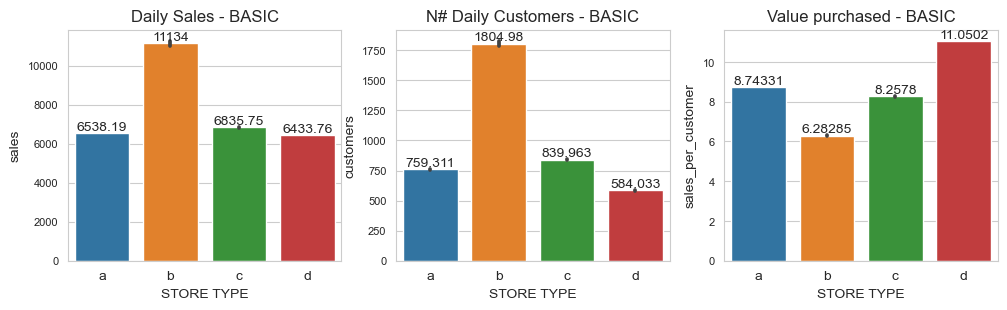

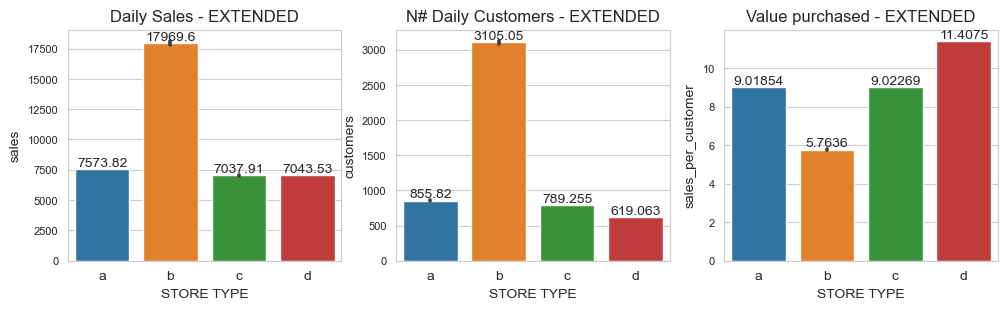

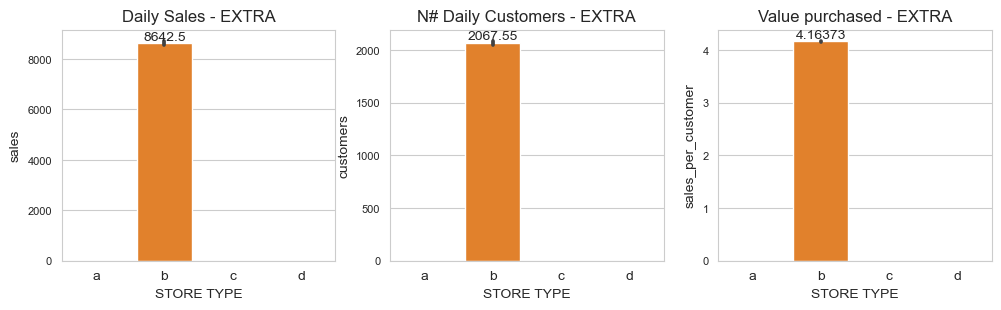

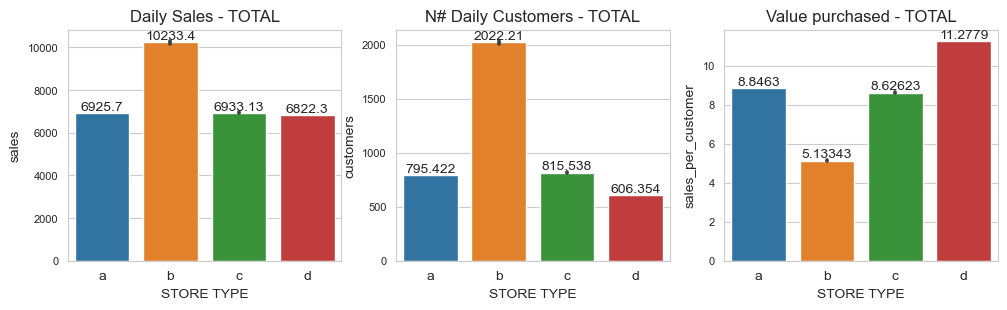

In [85]:
def plot_assortment( inAssortment: str, df4 ):
    if inAssortment=='':
        aux = df4.copy()
        strName = "TOTAL"
    else:
        aux = df4.loc[ df4['assortment']==inAssortment ].copy()
        strName = inAssortment.upper()
    plt.figure(figsize=(12,3))
    # Sales vs Store-type
    plt.subplot(1,3,1)
    b1 = sns.barplot(aux, x='store_type', y='sales', order='abcd');
    for i in b1.containers:
        b1.bar_label(i,)
    plt.title('Daily Sales - '+strName);
    plt.xlabel("STORE TYPE");
    plt.yticks( fontsize=8 );
    # Customers per Store-type
    plt.subplot(1,3,2)
    b2 = sns.barplot(aux, x='store_type', y='customers', order='abcd');
    for i in b2.containers:
        b2.bar_label(i,)
    plt.title('N# Daily Customers - '+strName);
    plt.yticks( fontsize=8 );
    plt.xlabel("STORE TYPE");
    # Sales/Customer per Store-type
    plt.subplot(1,3,3)
    b3 = sns.barplot(aux, x='store_type', y='sales_per_customer', order='abcd');
    for i in b3.containers:
        b3.bar_label(i,)
    plt.title('Value purchased - '+strName);
    plt.yticks( fontsize=8 );
    plt.xlabel("STORE TYPE");

ta = df4.loc[ df4['store_type']=='a' , ['assortment', 'store']].groupby('assortment').nunique().reset_index()
tb = df4.loc[ df4['store_type']=='b' , ['assortment', 'store']].groupby('assortment').nunique().reset_index()
tc = df4.loc[ df4['store_type']=='c' , ['assortment', 'store']].groupby('assortment').nunique().reset_index()
td = df4.loc[ df4['store_type']=='d' , ['assortment', 'store']].groupby('assortment').nunique().reset_index()
tot = df4.loc[ : , ['assortment', 'store']].groupby('assortment').nunique().reset_index()
ta.columns = ['assortment', 'Store-A']
tb.columns = ['assortment', 'Store-B']
tc.columns = ['assortment', 'Store-C']
td.columns = ['assortment', 'Store-D']
tot.columns = ['assortment', 'Total']
abcd = pd.merge( ta, tb, how='right', on='assortment' )
abcd = pd.merge( abcd, tc, how='left', on='assortment' )
abcd = pd.merge( abcd, td, how='left', on='assortment' )
abcd = pd.merge( abcd, tot, how='inner', on='assortment' )
abcd.fillna( 0, inplace=True )
abcd.loc[len(abcd.index)] = abcd.sum()
abcd.iloc[3, 0] = "Total"
# Plotting
plot_assortment( 'basic', df4 )
plot_assortment( 'extended', df4 )
plot_assortment( 'extra', df4 )
# Plotting totals
plot_assortment( '', df4 )
# Table
abcd

### 4.2.4. Periodic Promotions - promo2

In [86]:
# How many stores take part in PROMO2 or not?
# Answer: 571 stores are in PROMO2 and the other 544 are not.
aux = df4.loc[:, ['promo2','store'] ].groupby('promo2').nunique().reset_index()
aux

promo2  store
0       0    544
1       1    571

#### IS_PROMO2 & days of a week

The plottings bellow indicate that:
1. The best days to run a promotion are Wednewsday & Thrusday.
2. On the other days, promotional price reduction results in less income.

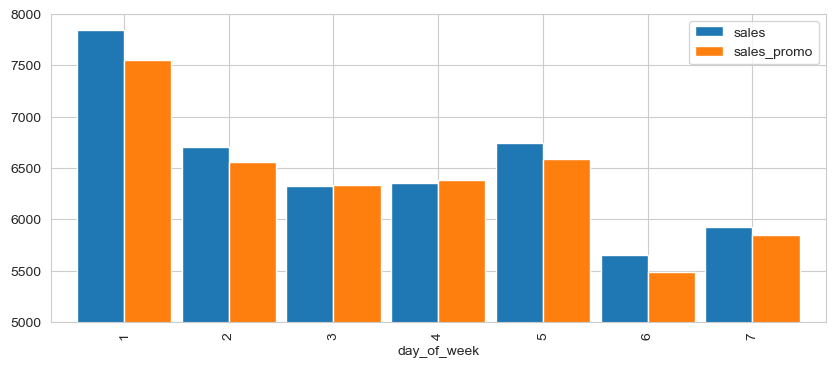

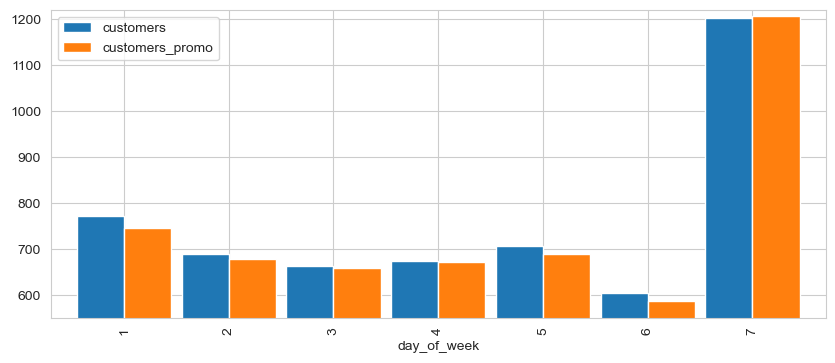

In [87]:
# PROMO2: Promotions & its effect on sales during the days of a month
sales0  = df4.loc[ (df4['promo2'] == 1)&(df4['is_promo2'] == 0), ['sales','day_of_week'] ].groupby('day_of_week').mean().reset_index()
custom0 = df4.loc[ (df4['promo2'] == 1)&(df4['is_promo2'] == 0), ['customers','day_of_week'] ].groupby('day_of_week').mean().reset_index()
sales1  = df4.loc[ (df4['promo2'] == 1)&(df4['is_promo2'] == 1), ['sales','day_of_week'] ].groupby('day_of_week').mean().reset_index()
custom1 = df4.loc[ (df4['promo2'] == 1)&(df4['is_promo2'] == 1), ['customers','day_of_week'] ].groupby('day_of_week').mean().reset_index()
sales1.columns = ['day_of_week','sales_promo']
custom1.columns = ['day_of_week','customers_promo']

res_day = pd.merge( sales0, sales1, how='inner', on='day_of_week' )
res_day = pd.merge( res_day, custom0, how='inner', on='day_of_week' )
res_day = pd.merge( res_day, custom1, how='inner', on='day_of_week' )

res_day['sales_promo_dif'] = res_day['sales_promo'] - res_day['sales']
res_day['customers_promo_dif'] = res_day['customers_promo'] - res_day['customers']
dif = res_day.loc[:, ['day_of_week','sales_promo_dif','customers_promo_dif']]

ax = res_day.plot( kind='bar', x='day_of_week', y=['sales','sales_promo'], figsize=(10,4), width=0.9 );
ax.set_ylim(5000, 8000);
ax = res_day.plot( kind='bar', x='day_of_week', y=['customers','customers_promo'], figsize=(10,4), width=0.9 );
ax.set_ylim(550, 1220);

#### IS_PROMO2 & days of a month

The plottings bellow indicate that:
1. During one month of promotion (promo2), the increment in sales occur only from 6th to 15th day.
2. During the days of strong sales, from 29th to 5th day and from 16th to 20th day, promotional price reduction results in less income.
3. It's recomended to restrict promotions to the period from 6th to 15th day of each month.

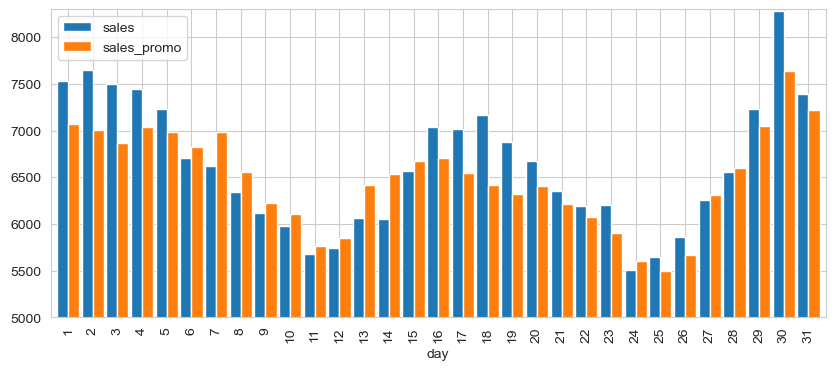

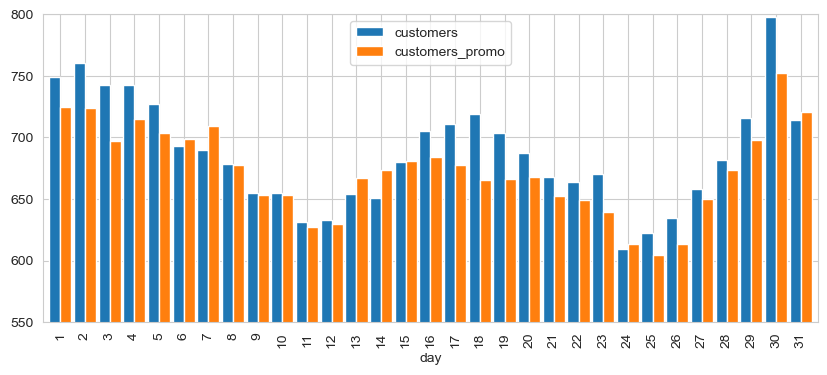

In [88]:
# PROMO2: Promotions & its effect on sales during the days of a month
sales0  = df4.loc[ (df4['promo2'] == 1)&(df4['is_promo2'] == 0), ['sales','day'] ].groupby('day').mean().reset_index()
custom0 = df4.loc[ (df4['promo2'] == 1)&(df4['is_promo2'] == 0), ['customers','day'] ].groupby('day').mean().reset_index()
sales1  = df4.loc[ (df4['promo2'] == 1)&(df4['is_promo2'] == 1), ['sales','day'] ].groupby('day').mean().reset_index()
custom1 = df4.loc[ (df4['promo2'] == 1)&(df4['is_promo2'] == 1), ['customers','day'] ].groupby('day').mean().reset_index()
sales1.columns = ['day','sales_promo']
custom1.columns = ['day','customers_promo']

res_day = pd.merge( sales0, sales1, how='inner', on='day' )
res_day = pd.merge( res_day, custom0, how='inner', on='day' )
res_day = pd.merge( res_day, custom1, how='inner', on='day' )

ax = res_day.plot( kind='bar', x='day', y=['sales','sales_promo'], figsize=(10,4), width=0.9 );
ax.set_ylim(5000, 8300);
ax = res_day.plot( kind='bar', x='day', y=['customers','customers_promo'], figsize=(10,4), width=0.9 );
ax.set_ylim(550, 800);

#### IS_PROMO2 & months of the year

The plottings bellow indicate that:
1. The best months to run a promotion are January, April, July & October
2. On the other months, promotional price reduction results in less income.

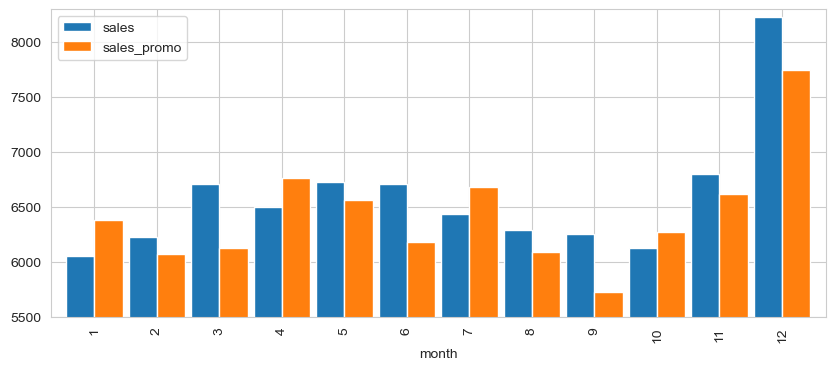

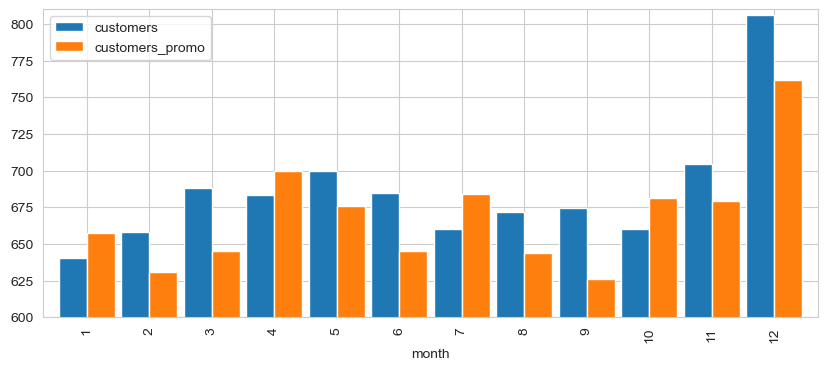

In [89]:
# PROMO2: Promotions & its effect on sales during the months of a year
sales0  = df4.loc[ (df4['promo2'] == 1)&(df4['is_promo2'] == 0), ['sales','month'] ].groupby('month').mean().reset_index()
custom0 = df4.loc[ (df4['promo2'] == 1)&(df4['is_promo2'] == 0), ['customers','month'] ].groupby('month').mean().reset_index()
sales1  = df4.loc[ (df4['promo2'] == 1)&(df4['is_promo2'] == 1), ['sales','month'] ].groupby('month').mean().reset_index()
custom1 = df4.loc[ (df4['promo2'] == 1)&(df4['is_promo2'] == 1), ['customers','month'] ].groupby('month').mean().reset_index()
sales1.columns = ['month','sales_promo']
custom1.columns = ['month','customers_promo']

res_day = pd.merge( sales0, sales1, how='inner', on='month' )
res_day = pd.merge( res_day, custom0, how='inner', on='month' )
res_day = pd.merge( res_day, custom1, how='inner', on='month' )

ax = res_day.plot( kind='bar', x='month', y=['sales','sales_promo'], figsize=(10,4), width=0.9 );
ax.set_ylim(5500, 8300);
ax = res_day.plot( kind='bar', x='month', y=['customers','customers_promo'], figsize=(10,4), width=0.9 );
ax.set_ylim(600, 810);

### 4.2.5. Eventual 1-day Promotions - promo

promo    date
0      0  467463
1      1  376875

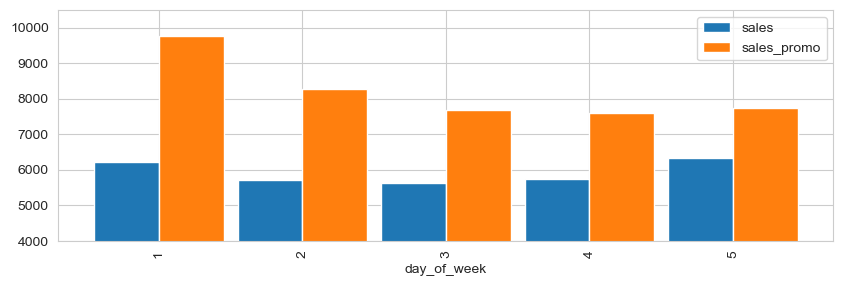

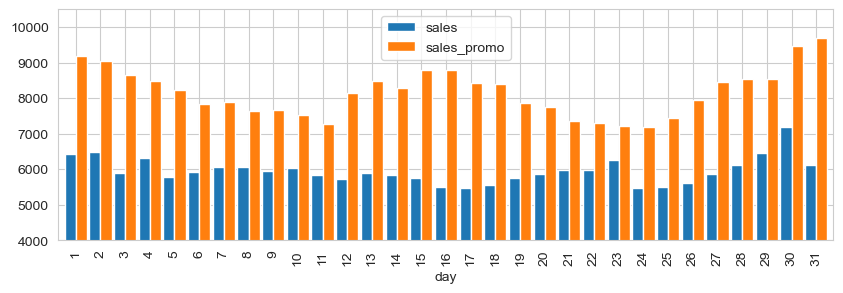

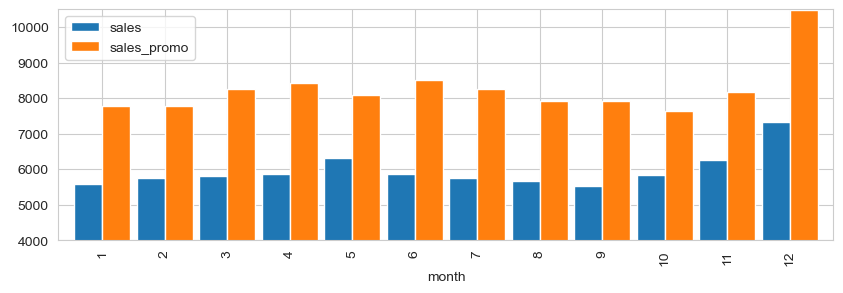

In [90]:
# For each store, one day may be promotional and the other not.
# Number of regular days. . : 467.463 (55%)
# Number of promotional days: 376.875 (45%) [ps: many promotions !!]
promo_table = df4.loc[:, ['promo','date'] ].groupby('promo').count().reset_index()

# PROMO & days of a week
sales0  = df4.loc[ df4['promo'] == 0, ['sales','day_of_week'] ].groupby('day_of_week').mean().reset_index()
sales1  = df4.loc[ df4['promo'] == 1, ['sales','day_of_week'] ].groupby('day_of_week').mean().reset_index()
sales1.columns = ['day_of_week','sales_promo']
res_day = pd.merge( sales0, sales1, how='inner', on='day_of_week' )
res_day['sales_promo_dif'] = res_day['sales_promo'] - res_day['sales']
ax = res_day.plot( kind='bar', x='day_of_week', y=['sales','sales_promo'], figsize=(10,3), width=0.9 );
ax.set_ylim(4000, 10500);

# PROMO & days of a month
sales0  = df4.loc[ df4['promo'] == 0, ['sales','day'] ].groupby('day').mean().reset_index()
sales1  = df4.loc[ df4['promo'] == 1, ['sales','day'] ].groupby('day').mean().reset_index()
sales1.columns = ['day','sales_promo']
res_day = pd.merge( sales0, sales1, how='inner', on='day' )
res_day['sales_promo_dif'] = res_day['sales_promo'] - res_day['sales']
ax = res_day.plot( kind='bar', x='day', y=['sales','sales_promo'], figsize=(10,3), width=0.9 );
ax.set_ylim(4000, 10500);

# PROMO & months of the year
sales0  = df4.loc[ df4['promo'] == 0, ['sales','month'] ].groupby('month').mean().reset_index()
sales1  = df4.loc[ df4['promo'] == 1, ['sales','month'] ].groupby('month').mean().reset_index()
sales1.columns = ['month','sales_promo']
res_day = pd.merge( sales0, sales1, how='inner', on='month' )
res_day['sales_promo_dif'] = res_day['sales_promo'] - res_day['sales']
ax = res_day.plot( kind='bar', x='month', y=['sales','sales_promo'], figsize=(10,3), width=0.9 );
ax.set_ylim(4000, 10500);

promo_table

### 4.2.6. Holidays

#### SCHOOL_HOLIDAY

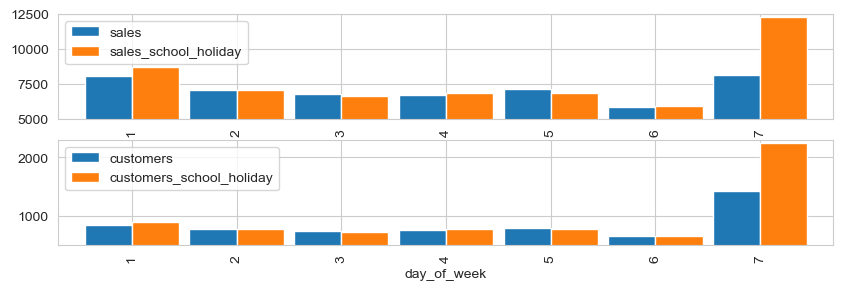

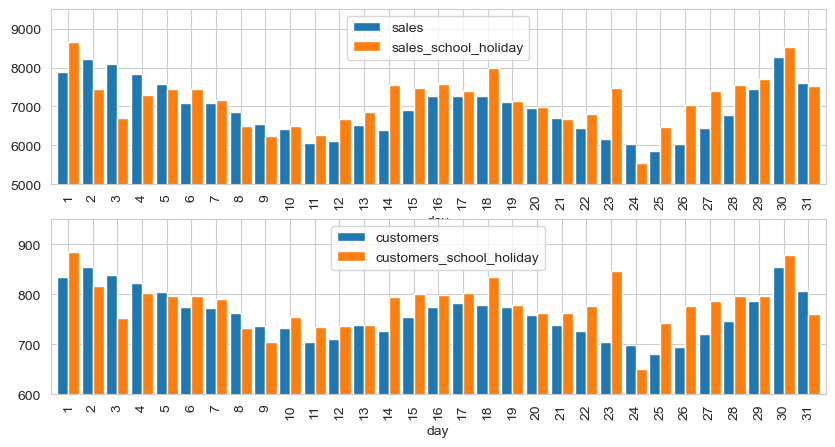

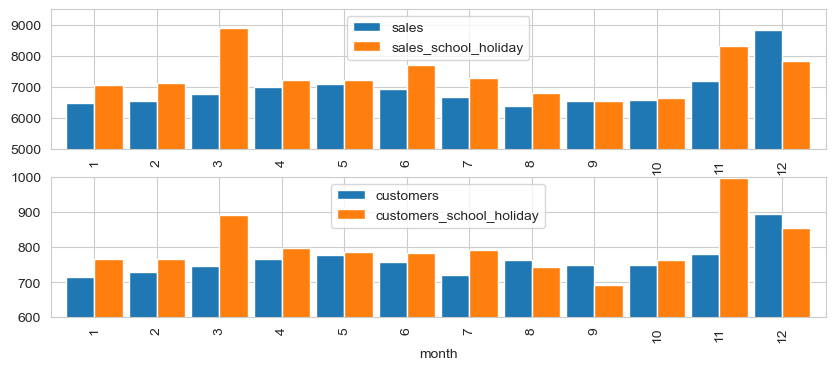

In [91]:
# SCHOOL HOLIDAYS & days of week
sales0  = df4.loc[ df4['school_holiday'] == 0, ['sales','day_of_week'] ].groupby('day_of_week').mean().reset_index()
custom0 = df4.loc[ df4['school_holiday'] == 0, ['customers','day_of_week'] ].groupby('day_of_week').mean().reset_index()
sales1  = df4.loc[ df4['school_holiday'] == 1, ['sales','day_of_week'] ].groupby('day_of_week').mean().reset_index()
custom1 = df4.loc[ df4['school_holiday'] == 1, ['customers','day_of_week'] ].groupby('day_of_week').mean().reset_index()
sales1.columns  = ['day_of_week','sales_school_holiday']
custom1.columns = ['day_of_week','customers_school_holiday']
res = pd.merge( sales0, sales1, how='inner', on='day_of_week' )
res = pd.merge( res, custom0, how='inner', on='day_of_week' )
res = pd.merge( res, custom1, how='inner', on='day_of_week' )
fig, axes = plt.subplots( nrows=2, ncols=1)
ax1 = res.plot( ax=axes[0], kind='bar', x='day_of_week', y=['sales','sales_school_holiday'], figsize=(10,3), width=0.9 );
ax1.set_ylim(5000, 12500);
ax2 = res.plot( ax=axes[1], kind='bar', x='day_of_week', y=['customers','customers_school_holiday'], figsize=(10,3), width=0.9 );
ax2.set_ylim(500, 2300);

# SCHOOL HOLIDAYS & days of the month
sales0  = df4.loc[ df4['school_holiday'] == 0, ['sales','day'] ].groupby('day').mean().reset_index()
custom0 = df4.loc[ df4['school_holiday'] == 0, ['customers','day'] ].groupby('day').mean().reset_index()
sales1  = df4.loc[ df4['school_holiday'] == 1, ['sales','day'] ].groupby('day').mean().reset_index()
custom1 = df4.loc[ df4['school_holiday'] == 1, ['customers','day'] ].groupby('day').mean().reset_index()
sales1.columns  = ['day','sales_school_holiday']
custom1.columns = ['day','customers_school_holiday']
res = pd.merge( sales0, sales1, how='inner', on='day' )
res = pd.merge( res, custom0, how='inner', on='day' )
res = pd.merge( res, custom1, how='inner', on='day' )
fig, axes = plt.subplots( nrows=2, ncols=1)
ax1 = res.plot( ax=axes[0], kind='bar', x='day', y=['sales','sales_school_holiday'], figsize=(10,5), width=0.9 );
ax1.set_ylim(5000, 9500);
ax2 = res.plot( ax=axes[1], kind='bar', x='day', y=['customers','customers_school_holiday'], figsize=(10,5), width=0.9 );
ax2.set_ylim(600, 950);

# SCHOOL HOLIDAYS & months of the year
sales0  = df4.loc[ df4['school_holiday'] == 0, ['sales','month'] ].groupby('month').mean().reset_index()
custom0 = df4.loc[ df4['school_holiday'] == 0, ['customers','month'] ].groupby('month').mean().reset_index()
sales1  = df4.loc[ df4['school_holiday'] == 1, ['sales','month'] ].groupby('month').mean().reset_index()
custom1 = df4.loc[ df4['school_holiday'] == 1, ['customers','month'] ].groupby('month').mean().reset_index()
sales1.columns  = ['month','sales_school_holiday']
custom1.columns = ['month','customers_school_holiday']
res = pd.merge( sales0, sales1, how='inner', on='month' )
res = pd.merge( res, custom0, how='inner', on='month' )
res = pd.merge( res, custom1, how='inner', on='month' )
fig, axes = plt.subplots( nrows=2, ncols=1)
ax1 = res.plot( ax=axes[0], kind='bar', x='month', y=['sales','sales_school_holiday'], figsize=(10,4), width=0.9 );
ax1.set_ylim(5000, 9500);
ax2 = res.plot( ax=axes[1], kind='bar', x='month', y=['customers','customers_school_holiday'], figsize=(10,4), width=0.9 );
ax2.set_ylim(600, 1000);


#### STATE_HOLIDAY

In [92]:
# Days of holiday
days_of_holiday  = df4.loc[ df4['state_holiday'] != 'regular_day', ['sales','month','day'] ].groupby(['month','day']).count().reset_index()
days_of_holiday.columns = ['month','day','occurrence']
days_of_holiday

month  day  occurrence
0       1    1          53
1       1    6           8
2       3   29          16
3       4    1          31
4       4    3          17
5       4    6          32
6       4   18          17
7       4   21          32
8       5    1          58
9       5    9          30
10      5   14          32
11      5   20          33
12      5   25          33
13      5   29          31
14      5   30          85
15      6    4          87
16      6    9          34
17      6   19          85
18      8   15          26
19     10    3          79
20     10   31           7
21     11    1          13
22     12   25          33
23     12   26          38

state_holiday     qty   qty%
3     regular_day  843428  99.89
2  public_holiday     694   0.08
1  easter_holiday     145   0.02
0       christmas      71   0.01

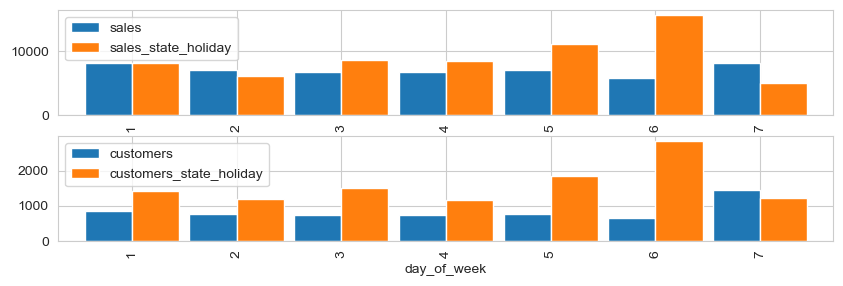

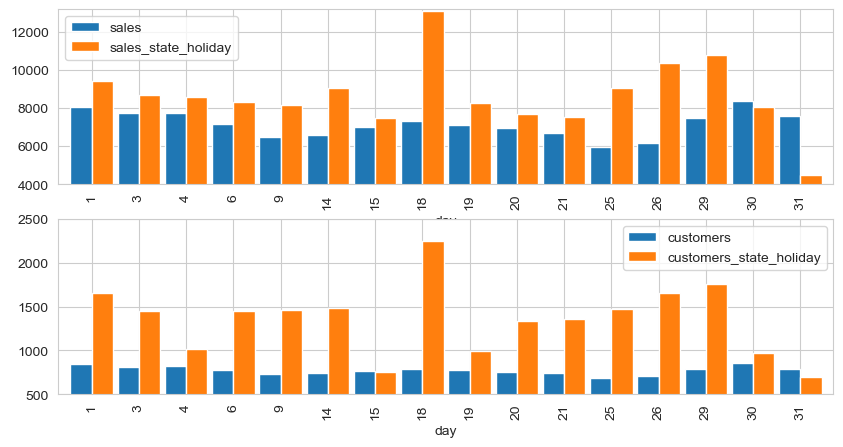

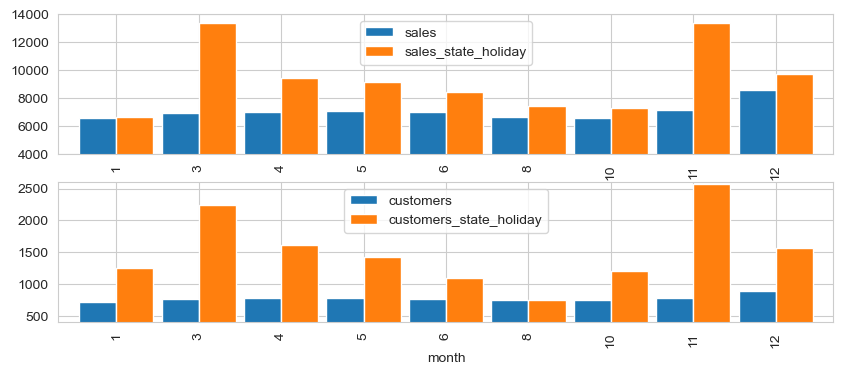

In [93]:
# STATE HOLIDAYS & days of week
sales0  = df4.loc[ df4['state_holiday'] == 'regular_day', ['sales','day_of_week'] ].groupby('day_of_week').mean().reset_index()
custom0 = df4.loc[ df4['state_holiday'] == 'regular_day', ['customers','day_of_week'] ].groupby('day_of_week').mean().reset_index()
sales1  = df4.loc[ df4['state_holiday'] != 'regular_day', ['sales','day_of_week'] ].groupby('day_of_week').mean().reset_index()
custom1 = df4.loc[ df4['state_holiday'] != 'regular_day', ['customers','day_of_week'] ].groupby('day_of_week').mean().reset_index()
sales1.columns  = ['day_of_week','sales_state_holiday']
custom1.columns = ['day_of_week','customers_state_holiday']
res = pd.merge( sales0, sales1, how='inner', on='day_of_week' )
res = pd.merge( res, custom0, how='inner', on='day_of_week' )
res = pd.merge( res, custom1, how='inner', on='day_of_week' )
fig, axes = plt.subplots( nrows=2, ncols=1)
ax1 = res.plot( ax=axes[0], kind='bar', x='day_of_week', y=['sales','sales_state_holiday'], figsize=(10,3), width=0.9 );
#ax1.set_ylim(4000, 16000);
ax2 = res.plot( ax=axes[1], kind='bar', x='day_of_week', y=['customers','customers_state_holiday'], figsize=(10,3), width=0.9 );
#ax2.set_ylim(300, 3000);

# STATE HOLIDAYS & days of the month
sales0  = df4.loc[ df4['state_holiday'] == 'regular_day', ['sales','day'] ].groupby('day').mean().reset_index()
custom0 = df4.loc[ df4['state_holiday'] == 'regular_day', ['customers','day'] ].groupby('day').mean().reset_index()
sales1  = df4.loc[ df4['state_holiday'] != 'regular_day', ['sales','day'] ].groupby('day').mean().reset_index()
days_of_holiday = sales1
custom1 = df4.loc[ df4['state_holiday'] != 'regular_day', ['customers','day'] ].groupby('day').mean().reset_index()
sales1.columns  = ['day','sales_state_holiday']
custom1.columns = ['day','customers_state_holiday']
res = pd.merge( sales0, sales1, how='inner', on='day' )
res = pd.merge( res, custom0, how='inner', on='day' )
res = pd.merge( res, custom1, how='inner', on='day' )
fig, axes = plt.subplots( nrows=2, ncols=1)
ax1 = res.plot( ax=axes[0], kind='bar', x='day', y=['sales','sales_state_holiday'], figsize=(10,5), width=0.9 );
ax1.set_ylim(4000, 13200);
ax2 = res.plot( ax=axes[1], kind='bar', x='day', y=['customers','customers_state_holiday'], figsize=(10,5), width=0.9 );
ax2.set_ylim(500, 2500);

# STATE HOLIDAYS & days of week
sales0  = df4.loc[ df4['state_holiday'] == 'regular_day', ['sales','month'] ].groupby('month').mean().reset_index()
custom0 = df4.loc[ df4['state_holiday'] == 'regular_day', ['customers','month'] ].groupby('month').mean().reset_index()
sales1  = df4.loc[ df4['state_holiday'] != 'regular_day', ['sales','month'] ].groupby('month').mean().reset_index()
custom1 = df4.loc[ df4['state_holiday'] != 'regular_day', ['customers','month'] ].groupby('month').mean().reset_index()
sales1.columns  = ['month','sales_state_holiday']
custom1.columns = ['month','customers_state_holiday']
res = pd.merge( sales0, sales1, how='inner', on='month' )
res = pd.merge( res, custom0, how='inner', on='month' )
res = pd.merge( res, custom1, how='inner', on='month' )
fig, axes = plt.subplots( nrows=2, ncols=1)
ax1 = res.plot( ax=axes[0], kind='bar', x='month', y=['sales','sales_state_holiday'], figsize=(10,4), width=0.9 );
ax1.set_ylim(4000, 14000);
ax2 = res.plot( ax=axes[1], kind='bar', x='month', y=['customers','customers_state_holiday'], figsize=(10,4), width=0.9 );
ax2.set_ylim(400, 2600);

# table of quantities:
total = df4.shape[0]
aux11 = df4.loc[:, ['state_holiday', 'store']].copy()
stt_hol = aux11.groupby('state_holiday').count().reset_index()
stt_hol['perc'] = ( 100. * stt_hol['store'] / total ).round(2)
stt_hol.columns = [ 'state_holiday', 'qty', 'qty%' ]
stt_hol.sort_values('qty', ascending=False)

# Days of holiday


### 4.2.7. Competition

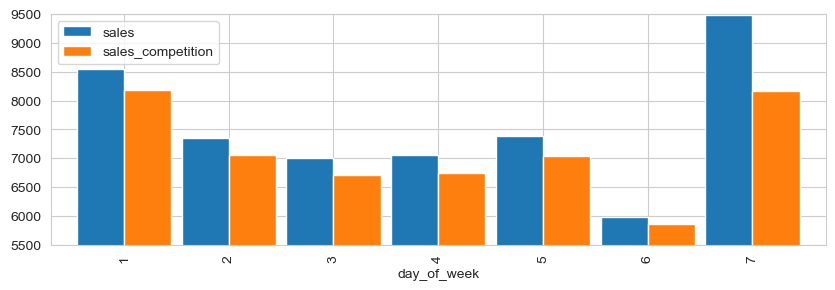

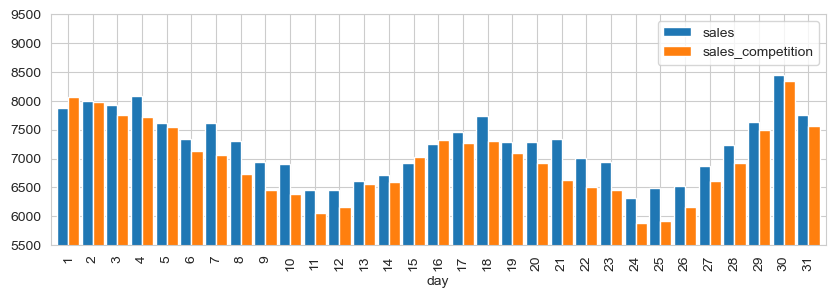

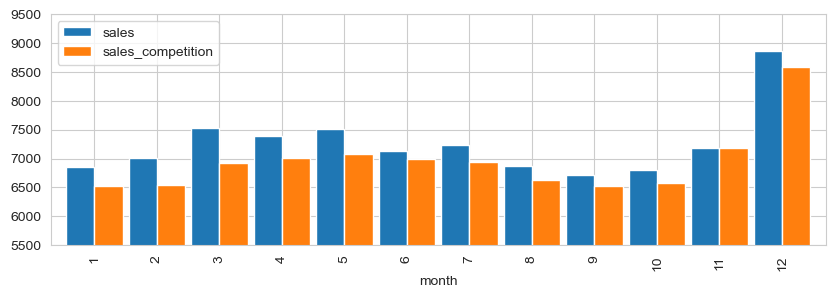

In [94]:
# COMPETITION & days of a week
sales0  = df4.loc[ df4['has_competition'] == 0, ['sales','day_of_week'] ].groupby('day_of_week').mean().reset_index()
sales1  = df4.loc[ df4['has_competition'] == 1, ['sales','day_of_week'] ].groupby('day_of_week').mean().reset_index()
sales1.columns = ['day_of_week','sales_competition']
res_day = pd.merge( sales0, sales1, how='inner', on='day_of_week' )
ax = res_day.plot( kind='bar', x='day_of_week', y=['sales','sales_competition'], figsize=(10,3), width=0.9 );
ax.set_ylim(5500, 9500);

# COMPETITION & days of a month
sales0  = df4.loc[ df4['has_competition'] == 0, ['sales','day'] ].groupby('day').mean().reset_index()
sales1  = df4.loc[ df4['has_competition'] == 1, ['sales','day'] ].groupby('day').mean().reset_index()
sales1.columns = ['day','sales_competition']
res_day = pd.merge( sales0, sales1, how='inner', on='day' )
ax = res_day.plot( kind='bar', x='day', y=['sales','sales_competition'], figsize=(10,3), width=0.9 );
ax.set_ylim(5500, 9500);

# COMPETITION & months of the year
sales0  = df4.loc[ df4['has_competition'] == 0, ['sales','month'] ].groupby('month').mean().reset_index()
sales1  = df4.loc[ df4['has_competition'] == 1, ['sales','month'] ].groupby('month').mean().reset_index()
sales1.columns = ['month','sales_competition']
res_day = pd.merge( sales0, sales1, how='inner', on='month' )
ax = res_day.plot( kind='bar', x='month', y=['sales','sales_competition'], figsize=(10,3), width=0.9 );
ax.set_ylim(5500, 9500);


### 4.2.8. Testing Hypotesis

#### H1. Stores with long time competitors should sell more
**FALSE hypothesis** Stores with long time competitors SELL LESS

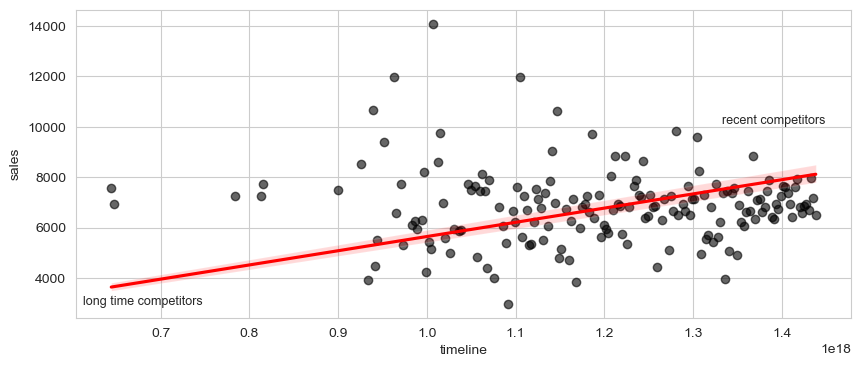

In [95]:
# Plotting avg(SALES) x COMPETITION_SINCE
# Result: more recent COMPETITION-starting-point implies higher sales - H1 false.
aux1 = df4[['competition_since', 'sales']].groupby( 'competition_since' ).mean().reset_index()
aux1['timeline'] = aux1['competition_since'].astype( np.int64 )
aux2 = aux1[ aux1['timeline']>0 ].copy()
plt.figure( figsize=(10, 4) )
sns.regplot( x='timeline', y='sales', data=aux2, scatter_kws={'color': 'black', 'alpha': 0.6}, line_kws={'color': 'red'}, ci=99 );
plt.annotate( 'long time competitors', xy=(60,45), fontsize=9, xycoords='figure points' );
plt.annotate( 'recent competitors', xy=(520,175), fontsize=9, xycoords='figure points' );

#### H2. Stores close to other competitors should sell less
**INCONCLUSIVE**: in average, competition distance does not affect sales

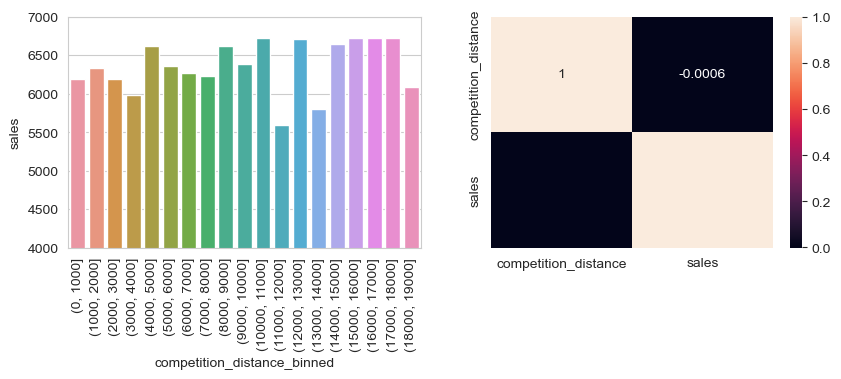

In [96]:
# Hypothesis-2: Stores close to other competitors should sell less
# Answer: the graphics indicates FALSE hypothesis.

aux1 = df4.loc[ df4['has_competition'] == 1 , ['competition_distance', 'sales']].groupby( 'competition_distance' ).median().reset_index()
bins = list( np.arange( 0, 20000, 1000 ) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).median().reset_index()

plt.figure( figsize=(10, 3) )
plt.subplot( 1, 2, 1 )
ax = sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
ax.set_ylim(4000, 7000);
plt.xticks( rotation=90 );

plt.subplot( 1, 2, 2 )
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).mean().reset_index()
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### H3. Stores with low budget products (like "extra" assortment) sell less than stores with more expensive products (like "extended" assortment).
**FALSE hypothesis**: Stores with low budget products SELL MORE.

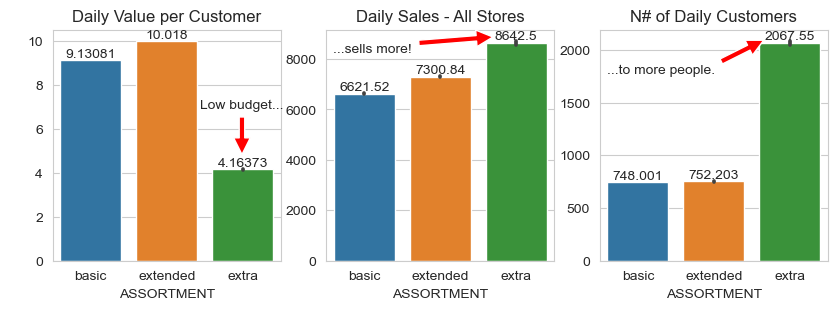

In [97]:
# Hypothesis-3: Stores with low budget products (like "extra" assortment) sell less...
#               ...than stores with more expensive products (like "extended" assortment).
# Answer: the graphics indicates FALSE hypothesis.

plt.figure(figsize=(10,3))
# Sales vs Assortment
plt.subplot(1,3,2)
b1 = sns.barplot(df4, x='assortment', y='sales');
for i in b1.containers:
    b1.bar_label(i,)
plt.title('Daily Sales - All Stores');
plt.xlabel("ASSORTMENT");
plt.ylabel("SALES");
plt.annotate( '...sells more!', xy=(0.75, 0.97), xycoords='axes fraction', 
              xytext=(0.20, 0.94), textcoords='axes fraction', 
              arrowprops=dict(facecolor='red', shrink=0.05),
              horizontalalignment='center', verticalalignment='top' );
# Customers per Assortment
plt.subplot(1,3,3)
b2 = sns.barplot(df4, x='assortment', y='customers');
for i in b2.containers:
    b2.bar_label(i,)
plt.title('N# of Daily Customers');
plt.xlabel("ASSORTMENT");
plt.ylabel(" ");
plt.annotate( '...to more people.', xy=(0.73, 0.96), xycoords='axes fraction', 
              xytext=(0.27, 0.85), textcoords='axes fraction', 
              arrowprops=dict(facecolor='red', shrink=0.05),
              horizontalalignment='center', verticalalignment='top' );
# Sales/Customer per Assortment
plt.subplot(1,3,1)
b3 = sns.barplot(df4, x='assortment', y='sales_per_customer');
for i in b3.containers:
    b3.bar_label(i,)
plt.title('Daily Value per Customer');
plt.xlabel("ASSORTMENT");
plt.ylabel(" ");
plt.annotate( 'Low budget...', xy=(0.83, 0.45), xycoords='axes fraction', 
              xytext=(0.83, 0.70), textcoords='axes fraction',
              arrowprops=dict(facecolor='red', shrink=0.05),
              horizontalalignment='center', verticalalignment='top' );


#### H4. Stores with low budget products have more customers and stores with more expensive products have less customers.
**TRUE hypothesis**: low budget products (like "extra" assortment) attract 2.75x more customers than the others

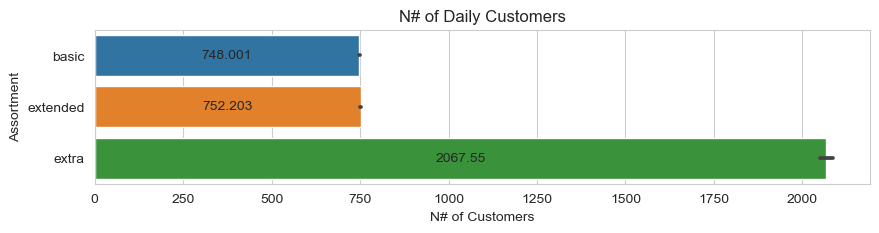

In [98]:
plt.figure(figsize=(10,2))
# Customers per Assortment
b2 = sns.barplot(df4, y='assortment', x='customers', orient='h');
for i in b2.containers:
    b2.bar_label(i, label_type='center')
plt.title('N# of Daily Customers');
plt.xlabel("N# of Customers");
plt.ylabel("Assortment");


#### H5. Most of the stores work with low budget products (like "extra" assortment).
**FALSE hypothesis**: Out of 1115, only 9 stores (**0,81%**) work with "extra"assortment.

In [99]:
assortment = df4.loc[:, ['assortment', 'store']].groupby('assortment').nunique().reset_index()
assortment.columns = ['assortment', 'Qtty']
assortment.T

0         1      2
assortment  basic  extended  extra
Qtty          593       513      9

#### H6. Stores with longer periods of promotional sales should sell more
**FALSE hypothesis** In average, stores with longer periods of promotional sales SELL LESS.
- Besides that, it can be observed that:
1. During one month of promotion (promo2), the increment in sales occur only from 6th to 15th day.
2. During the days of strong sales, from 29th to 5th day and from 16th to 20th day, promotional price reduction results in less income.
3. The best months to run a promotion are January, April, July & October
4. On the other months, promotional price reduction results in less income.
5. It's recomended to restrict promotions to periods of lower demand.

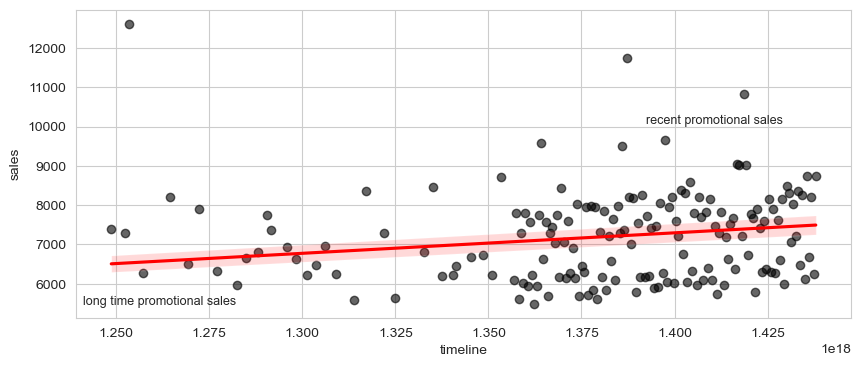

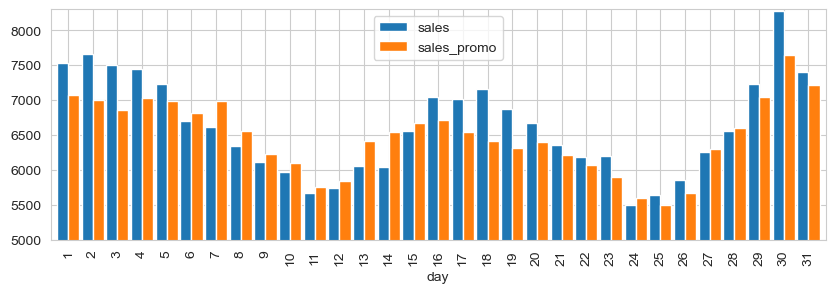

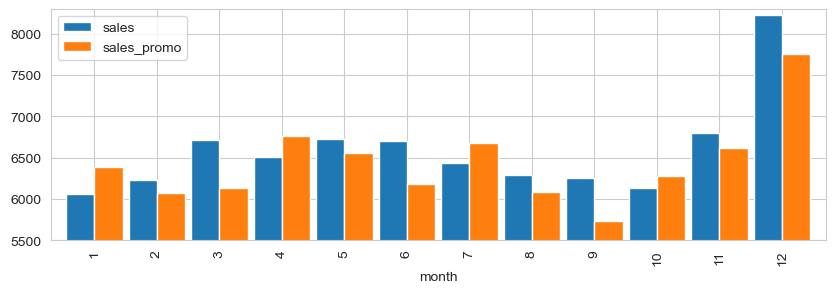

In [100]:
# Plotting avg(SALES) x PROMO2_SINCE
# Result: more recent PROMO2-starting-point implies higher sales - H4 false.
aux1 = df4[['promo2_since', 'sales']].groupby( 'promo2_since' ).mean().reset_index()
aux1['timeline'] = aux1['promo2_since'].astype( np.int64 )
plt.figure( figsize=(10, 4) )
sns.regplot( x='timeline', y='sales', data=aux1, scatter_kws={'color': 'black', 'alpha': 0.6}, line_kws={'color': 'red'}, ci=99 );
plt.annotate( 'long time promotional sales', xy=(60,45), fontsize=9, xycoords='figure points' );
plt.annotate( 'recent promotional sales', xy=(465,175), fontsize=9, xycoords='figure points' );

# PROMO2: Promotions & its effect on sales during the days of a month
sales0  = df4.loc[ (df4['promo2'] == 1)&(df4['is_promo2'] == 0), ['sales','day'] ].groupby('day').mean().reset_index()
sales1  = df4.loc[ (df4['promo2'] == 1)&(df4['is_promo2'] == 1), ['sales','day'] ].groupby('day').mean().reset_index()
sales1.columns = ['day','sales_promo']
res_day = pd.merge( sales0, sales1, how='inner', on='day' )
ax = res_day.plot( kind='bar', x='day', y=['sales','sales_promo'], figsize=(10,3), width=0.9 );
ax.set_ylim(5000, 8300);

# PROMO2: Promotions & its effect on sales during the months of a year
sales0  = df4.loc[ (df4['promo2'] == 1)&(df4['is_promo2'] == 0), ['sales','month'] ].groupby('month').mean().reset_index()
sales1  = df4.loc[ (df4['promo2'] == 1)&(df4['is_promo2'] == 1), ['sales','month'] ].groupby('month').mean().reset_index()
sales1.columns = ['month','sales_promo']
res_day = pd.merge( sales0, sales1, how='inner', on='month' )
ax = res_day.plot( kind='bar', x='month', y=['sales','sales_promo'], figsize=(10,3), width=0.9 );
ax.set_ylim(5500, 8300);

#### H7. Stores with more consecutive promotional sales should sell more
**FALSE hypothesis** Stores with more consecutive promotional sales sell LESS, in average.

In [101]:
# Hypothesis-7: Stores with more consecutive promotional sales should sell more.
# Stores which took part in PROMO2 finished selling LESS, in average.
df4[['promo', 'promo2', 'sales' ]].groupby( ['promo', 'promo2'] ).mean().sort_values('sales', ascending=True).reset_index().round(1)

promo  promo2   sales
0      0       1  5529.6
1      0       0  6328.2
2      1       1  7836.7
3      1       0  8618.5

#### H8. Stores open during Christmas Holiday should sell more
**TRUE hypotesis**: In average, during Christmas Holiday, stores sell more than in regular days, even in December.

month state_holiday  sales_in_december
0     12     christmas             9744.0
1     12   regular_day             8607.0

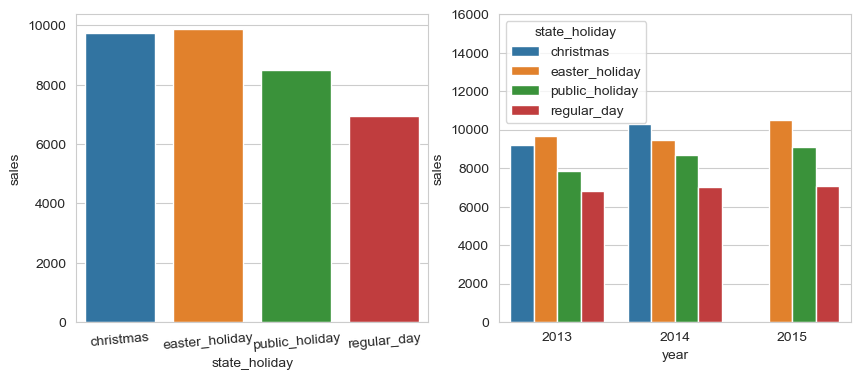

In [102]:
# Hypothesis-8: Stores selling during Christmas should sell more.
# Answer: FALSE
plt.figure( figsize=(10, 4) )
plt.subplot( 1, 2, 1 )
aux1 = df4[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );
plt.xticks(rotation=5, fontsize=10);
plt.subplot( 1, 2, 2 )
aux2 = df4[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).mean().reset_index()
ax = sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );
ax.set_ylim(0, 16000);
# ...even in December:
aux1 = df4.loc[ (df4['month']==12) & ( (df4['state_holiday']=='christmas') | (df4['state_holiday']=='regular_day') ), 
               ['month', 'state_holiday', 'sales']].copy()
aux2 = aux1[['month', 'state_holiday', 'sales']].groupby( ['month', 'state_holiday'] ).mean().reset_index()
aux2.columns = ['month','state_holiday','sales_in_december']
aux2.round(0)

#### H9. Stores should sell less during school holidays, since there is a reduced number of customers.
**FALSE hypothesis**: Stores SELL MORE during school holidays, except in December, when they do sell less.

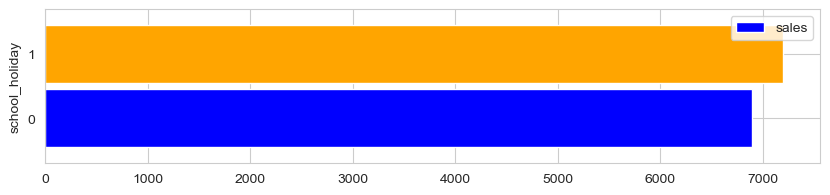

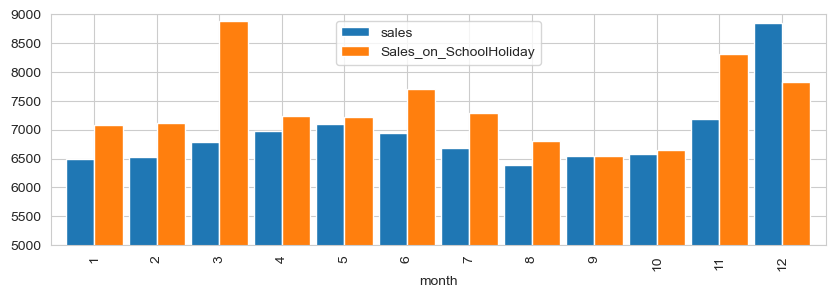

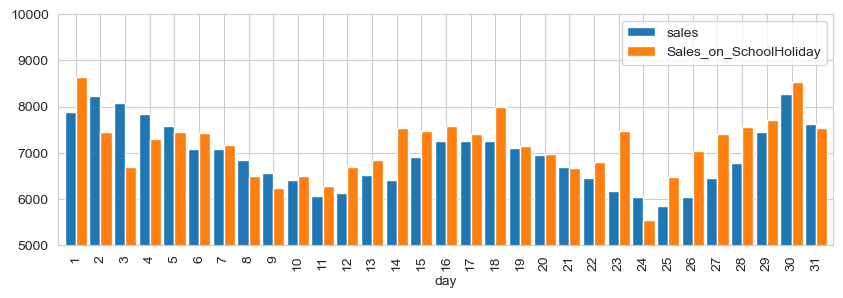

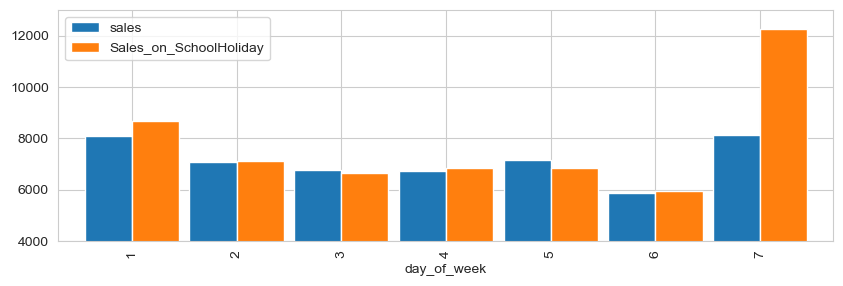

In [103]:
# Hypothesis-9: Stores should sell less during school holidays.
# Answer: FALSE.
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()
aux1.plot( kind='barh', y='sales', x='school_holiday', figsize=(10,2), width=0.9, color=['blue','orange'] );

# SCHOOL HOLIDAYS & months of the year
holiday0  = df4.loc[ df4['school_holiday'] == 0, ['sales','month'] ].groupby('month').mean().reset_index()
holiday1  = df4.loc[ df4['school_holiday'] == 1, ['sales','month'] ].groupby('month').mean().reset_index()
holiday1.columns = ['month','Sales_on_SchoolHoliday']
res = pd.merge( holiday0, holiday1, how='inner', on='month' )
ax = res.plot( kind='bar', x='month', y=['sales','Sales_on_SchoolHoliday'], figsize=(10,3), width=0.9 );
ax.set_ylim(5000, 9000);

# SCHOOL HOLIDAYS & days of a month
holiday0  = df4.loc[ df4['school_holiday'] == 0, ['sales','day'] ].groupby('day').mean().reset_index()
holiday1  = df4.loc[ df4['school_holiday'] == 1, ['sales','day'] ].groupby('day').mean().reset_index()
holiday1.columns = ['day','Sales_on_SchoolHoliday']
res = pd.merge( holiday0, holiday1, how='inner', on='day' )
ax = res.plot( kind='bar', x='day', y=['sales','Sales_on_SchoolHoliday'], figsize=(10,3), width=0.9 );
ax.set_ylim(5000, 10000);

# SCHOOL HOLIDAYS & days of a week
holiday0 = df4.loc[ df4['school_holiday'] == 0, ['sales','day_of_week'] ].groupby('day_of_week').mean().reset_index()
holiday1 = df4.loc[ df4['school_holiday'] == 1, ['sales','day_of_week'] ].groupby('day_of_week').mean().reset_index()
holiday1.columns = ['day_of_week','Sales_on_SchoolHoliday']
res = pd.merge( holiday0, holiday1, how='inner', on='day_of_week' )
ax = res.plot( kind='bar', x='day_of_week', y=['sales','Sales_on_SchoolHoliday'], figsize=(10,3), width=0.9 );
ax.set_ylim(4000, 13000);

#### H10. Stores should also sell less during other holidays.
**FALSE hypothesis**: Stores open in holidays SELL MORE then in regular days.

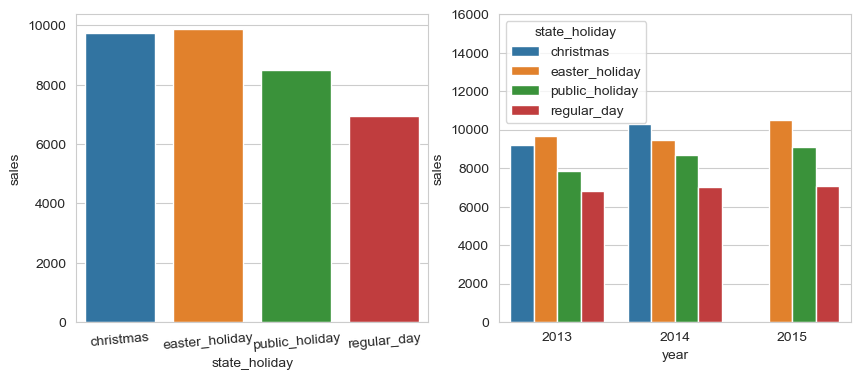

In [104]:
# Hypothesis-8: Stores selling during Christmas should sell more.
# Answer: FALSE
plt.figure( figsize=(10, 4) )
plt.subplot( 1, 2, 1 )
aux1 = df4[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );
plt.xticks(rotation=5, fontsize=10);
plt.subplot( 1, 2, 2 )
aux2 = df4[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).mean().reset_index()
ax = sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );
ax.set_ylim(0, 16000);

#### H11. Stores should sell more on Mondays, since most of the stores were closed the day before.
**TRUE hypothesis**: In median, stores SELL MORE on Mondays than on the other days. On Monday, it can also be observed:
- higher total sales.
- higher number of sales per customer.
- high number of customers.

In [105]:
week_metrics

day.of.week  open.stores  avg.sales  mdn.sales  avg.customers  \
0          1.0       1115.0    8216.25     7539.0         855.46   
1          2.0       1115.0    7088.41     6502.0         770.02   
2          3.0       1115.0    6728.79     6210.0         740.67   
3          4.0       1115.0    6768.21     6246.0         755.67   
4          5.0       1115.0    7073.03     6581.0         781.81   
5          6.0       1115.0    5875.08     5425.0         660.21   
6          7.0         33.0    8224.72     6876.0        1441.53   

   mdn.customers  mdn.sales/customer  
0          769.0                9.62  
1          684.0                9.31  
2          658.0                9.24  
3          673.0                9.11  
4          698.0                9.19  
5          573.0                9.13  
6         1262.0                6.19

#### H12. On Sunday, the few stores open (33/1115) should sell more.
**TRUE hypothesis**: In average, stores SELL MORE on Sundays. It can also be observed that:
- Stores receive a duplicated amount of consumers.
- Each consumer buy cheaper products (costing $6,19)

In [106]:
week_metrics

day.of.week  open.stores  avg.sales  mdn.sales  avg.customers  \
0          1.0       1115.0    8216.25     7539.0         855.46   
1          2.0       1115.0    7088.41     6502.0         770.02   
2          3.0       1115.0    6728.79     6210.0         740.67   
3          4.0       1115.0    6768.21     6246.0         755.67   
4          5.0       1115.0    7073.03     6581.0         781.81   
5          6.0       1115.0    5875.08     5425.0         660.21   
6          7.0         33.0    8224.72     6876.0        1441.53   

   mdn.customers  mdn.sales/customer  
0          769.0                9.62  
1          684.0                9.31  
2          658.0                9.24  
3          673.0                9.11  
4          698.0                9.19  
5          573.0                9.13  
6         1262.0                6.19

#### H13. On Saturday, the stores should sell less, due to the reduced working hours.
**TRUE hypothesis**: In average, Saturdays have the weakest sales of the week.
- PS: the results may be due to the reduced working hours, from 9 a.m. to 1 p.m., according to "https://www.bonn.de/microsite/en/services/medical-care/pharmacies.php#:~:text=A%20pharmacy%20in%20Germany%20is,to%201%20p.m.%20on%20Saturdays."

In [107]:
week_metrics

day.of.week  open.stores  avg.sales  mdn.sales  avg.customers  \
0          1.0       1115.0    8216.25     7539.0         855.46   
1          2.0       1115.0    7088.41     6502.0         770.02   
2          3.0       1115.0    6728.79     6210.0         740.67   
3          4.0       1115.0    6768.21     6246.0         755.67   
4          5.0       1115.0    7073.03     6581.0         781.81   
5          6.0       1115.0    5875.08     5425.0         660.21   
6          7.0         33.0    8224.72     6876.0        1441.53   

   mdn.customers  mdn.sales/customer  
0          769.0                9.62  
1          684.0                9.31  
2          658.0                9.24  
3          673.0                9.11  
4          698.0                9.19  
5          573.0                9.13  
6         1262.0                6.19

#### H14. Due to Mother's Day, May should present the second best selling month of the year.
**FALSE hypothesis**: In average, May is the third best month.
- Plotting indicates:
1. DECEMBER: Best seller month. Revenue impacted by Christmas.
2. NOVEMBER: Second stronger month, possibly caused by black friday sales.
3. MAY: Third stronger month, probably caused by Mother's Day.
4. SEPTEMBER, JANUARY & FEBRUARY: these months show the lowest selling statistics.

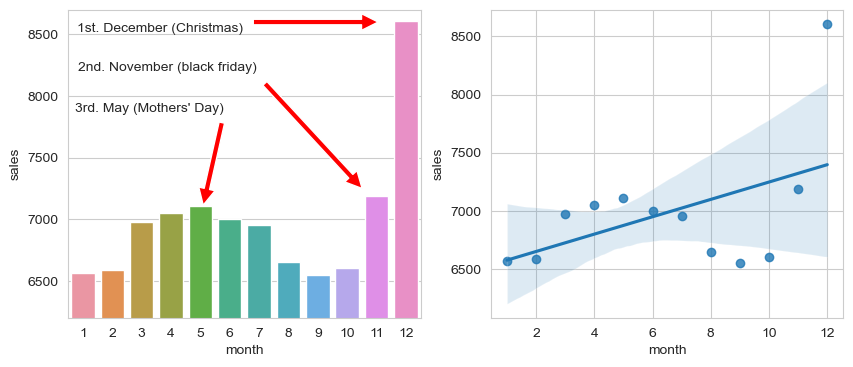

In [108]:
# Hypothesis-14: Due to Mother's Day, May should present the...
#               ...second best selling month of the year.
# Answer: TRUE
Avg_Sales_Month = df4.loc[:, ['month','sales']].groupby('month').mean().reset_index()
plt.figure( figsize=(10, 4) )
plt.subplot( 1, 2, 1 )
ax = sns.barplot( x='month', y='sales', data=Avg_Sales_Month );
ax.set_ylim(6200, 8700);
plt.annotate( '1st. December (Christmas)', xy=(0.90, 0.96), xycoords='axes fraction', 
              xytext=(0.26, 0.96), textcoords='axes fraction', 
              arrowprops=dict(facecolor='red', shrink=0.05),
              horizontalalignment='center', verticalalignment='top' );
plt.annotate( '2nd. November (black friday)', xy=(0.85, 0.40), xycoords='axes fraction', 
              xytext=(0.28, 0.83), textcoords='axes fraction', 
              arrowprops=dict(facecolor='red', shrink=0.05),
              horizontalalignment='center', verticalalignment='top' );
plt.annotate( '3rd. May (Mothers\' Day)', xy=(0.38, 0.35), xycoords='axes fraction', 
              xytext=(0.23, 0.70), textcoords='axes fraction', 
              arrowprops=dict(facecolor='red', shrink=0.05),
              horizontalalignment='center', verticalalignment='top' );
plt.subplot( 1, 2, 2 )
sns.regplot( x='month', y='sales', data=Avg_Sales_Month );


#### H15. Due to the winter, January and February should sell less.
**TRUE hypothesis**: January and February, along with September, are the worst selling months.

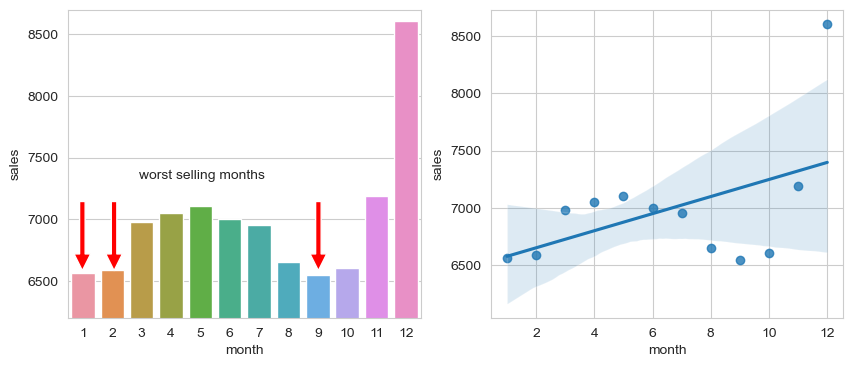

In [109]:
# Hypothesis-15: Due to the winter, January and February should sell less.
# Answer: TRUE
Avg_Sales_Month = df4.loc[:, ['month','sales']].groupby('month').mean().reset_index()
plt.figure( figsize=(10, 4) )
plt.subplot( 1, 2, 1 )
ax = sns.barplot( x='month', y='sales', data=Avg_Sales_Month );
ax.set_ylim(6200, 8700);
plt.annotate( 'worst selling months', xy=(0.20, 0.45), xycoords='axes fraction' )
plt.annotate( ' ', xy=(0.13, 0.14), xycoords='axes fraction', 
              xytext=(0.13, 0.44), textcoords='axes fraction', 
              arrowprops=dict(facecolor='red', shrink=0.05),
              horizontalalignment='center', verticalalignment='top' );
plt.annotate( ' ', xy=(0.71, 0.14), xycoords='axes fraction', 
              xytext=(0.71, 0.44), textcoords='axes fraction', 
              arrowprops=dict(facecolor='red', shrink=0.05),
              horizontalalignment='center', verticalalignment='top' );
plt.annotate( ' ', xy=(0.04, 0.14), xycoords='axes fraction', 
              xytext=(0.04, 0.44), textcoords='axes fraction', 
              arrowprops=dict(facecolor='red', shrink=0.05),
              horizontalalignment='center', verticalalignment='top' );
plt.subplot( 1, 2, 2 )
sns.regplot( x='month', y='sales', data=Avg_Sales_Month );

#### H16. Stores should sell more from the last days of the previous month to the first days of the current month, due to the effect of salaries in the economy.
**TRUE hypothesis**: Stores SELL MORE from the last days of the previous month to the first days of the current month.
- The strongest peak of sales occur from the 29th up to the 4th or 5th of the following month.

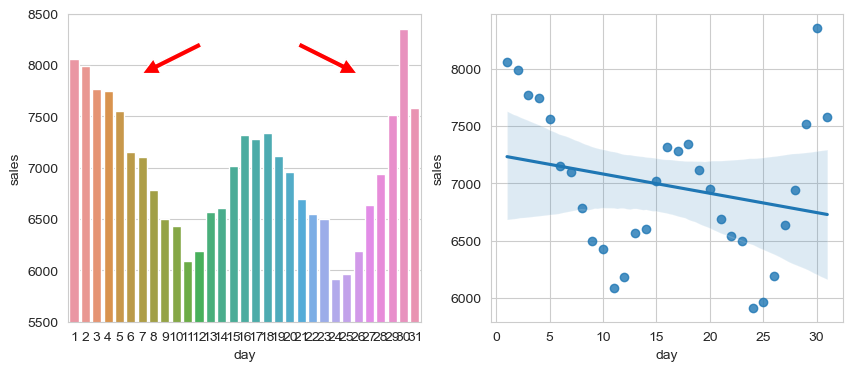

In [110]:
# Hypothesis-16: 
# Answer: TRUE
Avg_Sales_Month = df4.loc[:, ['day','sales']].groupby('day').mean().reset_index()
plt.figure( figsize=(10, 4) )
plt.subplot( 1, 2, 1 )
ax = sns.barplot( x='day', y='sales', data=Avg_Sales_Month );
ax.set_ylim(5500, 8500);
plt.annotate( ' ', xy=(0.83, 0.80), xycoords='axes fraction', 
              xytext=(0.63, 0.95), textcoords='axes fraction', 
              arrowprops=dict(facecolor='red', shrink=0.05),
              horizontalalignment='center', verticalalignment='top' );
plt.annotate( ' ', xy=(0.20, 0.80), xycoords='axes fraction', 
              xytext=(0.40, 0.95), textcoords='axes fraction', 
              arrowprops=dict(facecolor='red', shrink=0.05),
              horizontalalignment='center', verticalalignment='top' );
plt.subplot( 1, 2, 2 )
sns.regplot( x='day', y='sales', data=Avg_Sales_Month );

#### H17. Stores should sell less in the middle days of the month.
**FALSE hypothesis**: Another peak occurs in the 3rd week, between the 16th and 19th
- There is a clear seasonal behaviour, showing two periods of peak and two periods of valey.
- The weakest periods occur between the 10th and 13th, and again in two weeks, between the 24th and 26th.

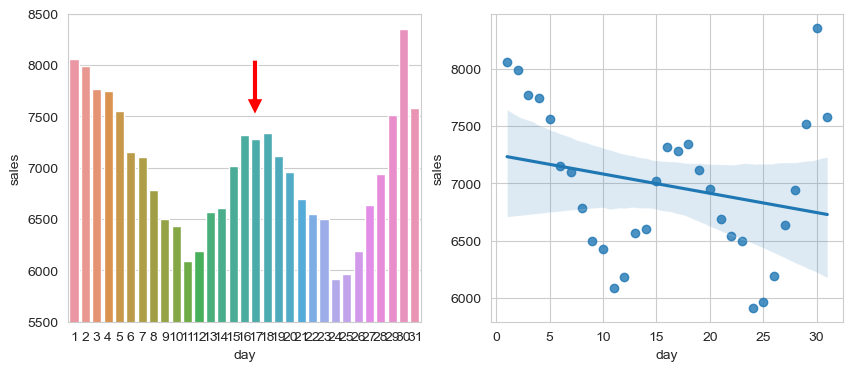

In [111]:
# Hypothesis-17: 
# Answer: FALSE
Avg_Sales_Month = df4.loc[:, ['day','sales']].groupby('day').mean().reset_index()
plt.figure( figsize=(10, 4) )
plt.subplot( 1, 2, 1 )
ax = sns.barplot( x='day', y='sales', data=Avg_Sales_Month );
ax.set_ylim(5500, 8500);
plt.annotate( ' ', xy=(0.53, 0.66), xycoords='axes fraction', 
              xytext=(0.53, 0.91), textcoords='axes fraction', 
              arrowprops=dict(facecolor='red', shrink=0.05),
              horizontalalignment='center', verticalalignment='top' );
plt.subplot( 1, 2, 2 )
sns.regplot( x='day', y='sales', data=Avg_Sales_Month );

### 4.2.9. Summary of Hypothesis

In [112]:
# 4.2.1. RESUMO DAS HIPÓTESES
# Tabulação dos resultados
tab = [
    ['Hipóteses', 'Conclusão', 'Relevância', 'Feature'],
    ['H1',  'Falsa', 'Média', 'competition_since'],
    ['H2',  '-', 'Baixa', 'competition_distance'],
    ['H3',  'Falsa', 'Alta', 'assortment'],
    ['H4',  'Verdadeira', 'Média', 'assortment'],
    ['H5',  'Falsa', 'Média', 'assortment'],
    ['H6',  'Falsa', 'Média', 'promo2_since'],
    ['H7',  'Falsa', 'Média', 'promo/promo2'],
    ['H8',  'Verdadeira', 'Alta', 'state_holiday/christmas'],
    ['H9', 'Falsa', 'Alta', 'school_holiday'],
    ['H10', 'Falsa', 'Alta', 'state_holiday'],
    ['H11', 'Verdadeira', 'Baixa', 'day_of_week'],
    ['H12', 'Verdadeira', 'Média', 'day_of_week'],
    ['H13', 'Verdadeira', 'Alta', 'day_of_week'],
    ['H14', 'Falsa', 'Alta', 'month/state_holiday'],
    ['H15', 'Verdadeira', 'Alta', 'month'],
    ['H16', 'Verdadeira', 'Alta', 'day'],
    ['H17', 'Falsa', 'Alta', 'day']
]
print( tabulate( tab, headers='firstrow' ) )


Hipóteses    Conclusão    Relevância    Feature
-----------  -----------  ------------  -----------------------
H1           Falsa        Média         competition_since
H2           -            Baixa         competition_distance
H3           Falsa        Alta          assortment
H4           Verdadeira   Média         assortment
H5           Falsa        Média         assortment
H6           Falsa        Média         promo2_since
H7           Falsa        Média         promo/promo2
H8           Verdadeira   Alta          state_holiday/christmas
H9           Falsa        Alta          school_holiday
H10          Falsa        Alta          state_holiday
H11          Verdadeira   Baixa         day_of_week
H12          Verdadeira   Média         day_of_week
H13          Verdadeira   Alta          day_of_week
H14          Falsa        Alta          month/state_holiday
H15          Verdadeira   Alta          month
H16          Verdadeira   Alta          day
H17          Falsa        Alta 

## 4.3. Multivariate Analysis

In [113]:
# Aim: discover relation among attributes.

In [114]:
# DELETE 'CUSTOMERS' & 'SALES_PER_CUSTOMER' COLUMNS:
# - According to section 3.2
# - Del 'customers' since it won't be available during prediction (=business restriction)
# - Del 'sales_per_customer', since 'customers' was deleted.
cols_drop = [ 'customers', 'sales_per_customer' ]
df4 = df4.drop( cols_drop, axis=1 )

### 4.3.1. Numerical Attributes

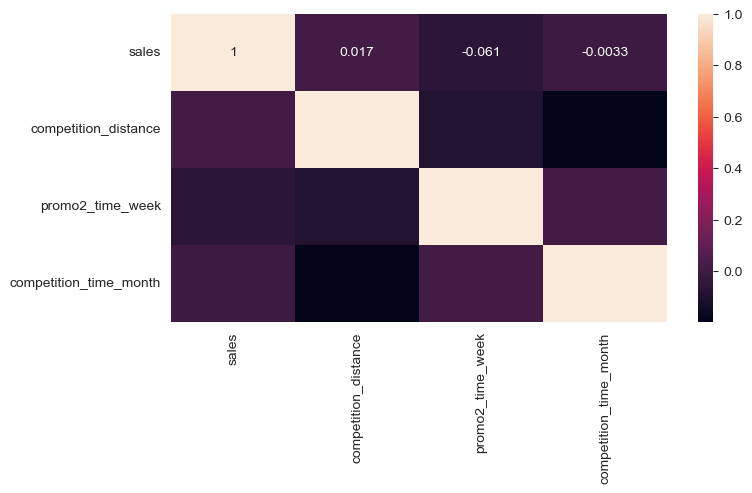

In [115]:
# 4.3.1. MULTIVARIATE ANALYSIS - Numerical Attributes
# Select numerical attributes for correlation
# PS: excluding "CUSTOMERS" & "SALES PER CUSTOMER", due to business restriction.
num_attributes = num_attributes.loc[:,
                   ['sales',
                    'competition_distance',
                    'promo2_time_week',
                    'competition_time_month']]

num_vars = len(num_attributes.columns)
correlation_matrix = np.zeros((num_vars, num_vars))

correlation = num_attributes.corr( method='pearson' )
plt.figure( figsize=(8, 4) );
sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes

In [116]:
# 4.3.1. MULTIVARIATE ANALYSIS - Categorical Attributes
# Assembling 'correlation' matrix for categorical attributes

# Select categorical features to apply CRAMER'S V function
df_cramer = df4.loc[:,
       ['store',              'sales',              'date',              'school_holiday',
        'state_holiday',      'year',               'semester',          'quarter',
        '2months',            'month',              'fortnight_of_year', 'fortnight_of_month',
        'day',                'day_of_week',        'week_of_year',      'year_week',
        'promo',              'promo2',             'is_promo2',         'promo2_since',
        'promo2_since_week',  'promo2_since_year',  'store_type',        'assortment',
        'has_competition',    'competition_open_since_month',            'competition_open_since_year',
        'competition_since' ]]

num_vars = len(df_cramer.columns)
correlation_matrix = np.zeros((num_vars, num_vars))

# Create correlation matrix using CRAMER'S V function
for i in range(num_vars):
    for j in range(num_vars):
        if i != j:
            corr = cramer_v(df_cramer.iloc[:, i], df_cramer.iloc[:, j])
            correlation_matrix[i, j] = corr

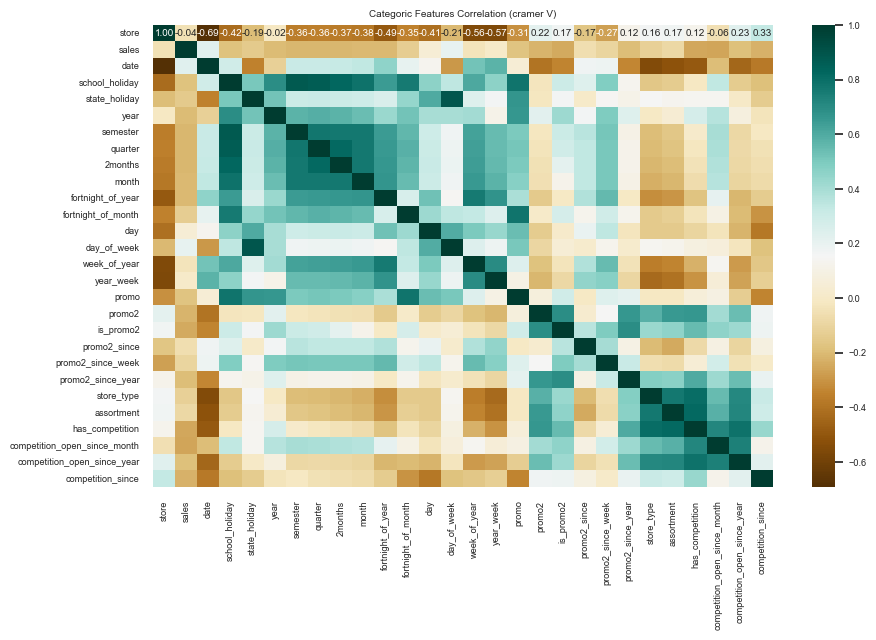

In [117]:
plt.figure(figsize=(10,6))

correlation_df = pd.DataFrame(correlation_matrix, columns=df_cramer.columns, index=df_cramer.columns)
sns.set(font_scale=0.6)
sns.heatmap(correlation_df.corr(), annot=True, fmt='.2f', cmap='BrBG');
plt.title("Categoric Features Correlation (cramer V)");


# STEP 5. DATA PREPARATION

## 5.0. Initial Procedure

In [118]:
df5 = df4.copy()

rs = RobustScaler()
mms = MinMaxScaler()


## 5.1. Normalizing

### 5.1.1 Response Variable Normalization

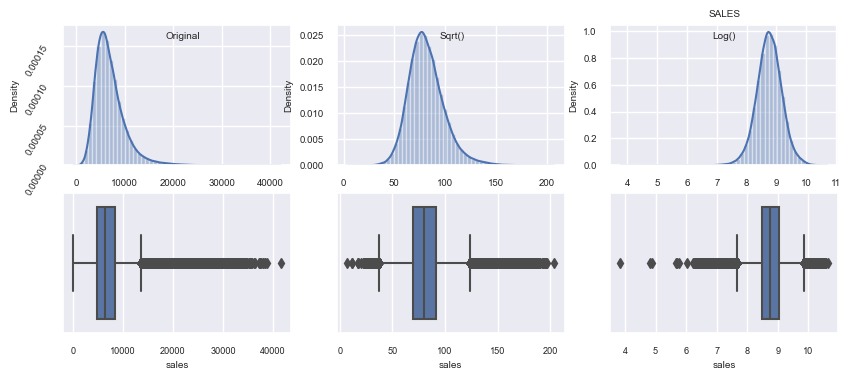

In [119]:
# 5.1.1 Response Variable Normalization
plt.figure(figsize=(10, 4))
plt.subplot(2,3,1)
sns.distplot( df5['sales'] );
plt.xticks( fontsize=7 );
plt.yticks( rotation=60, fontsize=7 );
plt.annotate( 'Original', xy=(0.45, 0.9), xycoords='axes fraction' )
#
plt.subplot(2,3,2)
sns.distplot( np.sqrt(df5['sales']) );
plt.xticks( fontsize=7 );
plt.yticks( fontsize=7 );
plt.annotate( 'Sqrt()', xy=(0.45, 0.9), xycoords='axes fraction' )
#
plt.subplot(2,3,3)
sns.distplot( np.log1p(df5['sales']) );
plt.xticks( fontsize=7 );
plt.yticks( fontsize=7 );
plt.annotate( 'Log()', xy=(0.45, 0.9), xycoords='axes fraction' )
plt.title('SALES')
# Boxplot
plt.subplot(2,3,4)
bp = sns.boxplot( x='sales', data=df5 );
#
plt.subplot(2,3,5)
bp = sns.boxplot( x=np.sqrt(df5['sales']) );

# THE TRANSFORMATION !!
df5['sales'] = np.log1p( df5['sales'] )

plt.subplot(2,3,6)
bp = sns.boxplot( x='sales', data=df5 )

## 5.2. Rescaling

In [120]:
# Numerical variables (see 4.1.1): promo2_time_week, Competition Distance & competition_time_month
# Géron, pg.76: "...before you scale the feature, you should first transform it to shrink the heavy tail"

### 5.2.1 Rescaling: promo2_time_week

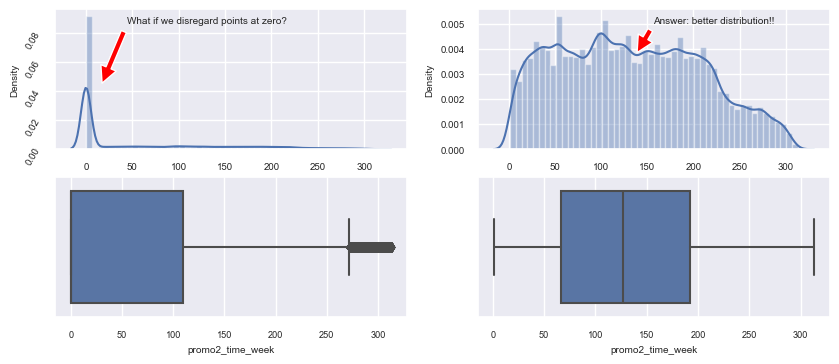

In [121]:
# 5.2 Rescaling: promo2_time_week
# Just apply min-max scaling
plt.figure(figsize=(10, 4))
plt.subplot(2,2,1)
sns.distplot( df5['promo2_time_week'] );
plt.xticks( fontsize=7 );
plt.yticks( rotation=60, fontsize=7 );
plt.annotate( 'What if we disregard points at zero?', xy=(0.13, 0.45), xycoords='axes fraction', 
              xytext=(0.43, 0.95), textcoords='axes fraction',
              arrowprops=dict(facecolor='red', shrink=0.05),
              horizontalalignment='center', verticalalignment='top' );
plt.subplot(2,2,3)
bp = sns.boxplot( x='promo2_time_week', data=df5 );
# Compare to Non-Zero Points
aux = df5.loc[ df5['promo2_time_week']>0 , :].copy()
plt.subplot(2,2,2)
sns.distplot( aux['promo2_time_week'] );
plt.xticks( fontsize=7 );
plt.yticks( fontsize=7 );
plt.annotate( 'Answer: better distribution!!', xy=(0.45, 0.68), xycoords='axes fraction', 
              xytext=(0.67, 0.95), textcoords='axes fraction',
              arrowprops=dict(facecolor='red', shrink=0.05),
              horizontalalignment='center', verticalalignment='top' );
plt.subplot(2,2,4)
bp = sns.boxplot( x='promo2_time_week', data=aux )

# promo_time_week
df5['promo2_time_week'] = mms.fit_transform( df5[['promo2_time_week']].values )
pickle.dump( rs, open( '../webapp/parameter/promo_time_week_scaler.pkl', 'wb' ) )

### 5.2.2 Rescaling: competition_distance

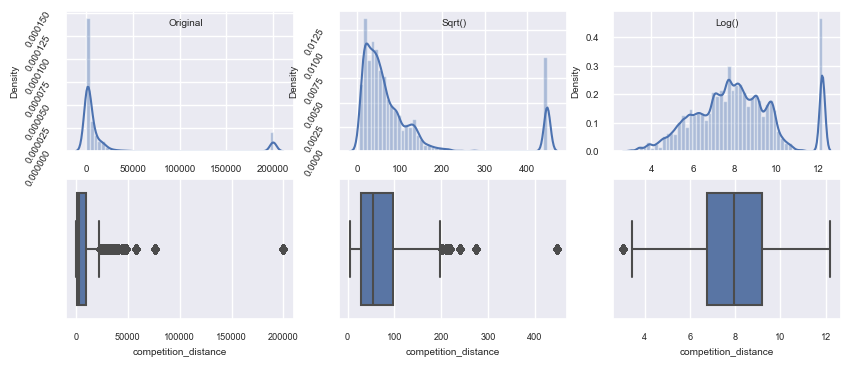

In [122]:
# 5.2 Rescaling: competition_distance
# Apply log, then apply min-max scaling
plt.figure(figsize=(10, 4))
#
plt.subplot(2,3,1)
sns.distplot( df5['competition_distance'] );
plt.xticks( fontsize=7 );
plt.yticks( rotation=60, fontsize=7 );
plt.annotate( 'Original', xy=(0.45, 0.9), xycoords='axes fraction' )
# 
plt.subplot(2,3,2)
sns.distplot( np.sqrt( df5['competition_distance'] ) );
plt.xticks( fontsize=7 );
plt.yticks( rotation=60, fontsize=7 );
plt.annotate( 'Sqrt()', xy=(0.45, 0.9), xycoords='axes fraction' )
#
plt.subplot(2,3,3)
sns.distplot( np.log1p(df5['competition_distance']) );
plt.xticks( fontsize=7 );
plt.yticks( fontsize=7 );
plt.annotate( 'Log()', xy=(0.45, 0.9), xycoords='axes fraction' )
# Boxplot
plt.subplot(2,3,4)
bp = sns.boxplot( x='competition_distance', data=df5 );
#
plt.subplot(2,3,5)
bp = sns.boxplot( x=np.sqrt( df5['competition_distance'] ) );

# Apply LOG
df5['competition_distance'] = np.log1p( df5['competition_distance'] )

plt.subplot(2,3,6)
bp = sns.boxplot( x='competition_distance', data=df5 )

# Then apply MIN-MAX scaling
df5['competition_distance'] = mms.fit_transform( df5[['competition_distance']].values )
pickle.dump( mms, open( '../webapp/parameter/competition_distance_scaler.pkl', 'wb' ) )
#pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb' ) )


### 5.2.3 Rescaling: competition_time_month

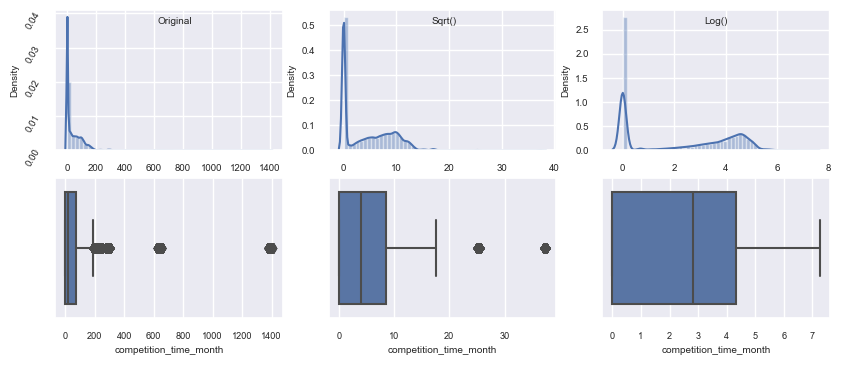

In [123]:
# 5.2 Rescaling: competition_time_month
# Apply log, then apply min-max scaling

# let's disregard zeroes
aux = df5.loc[ df5['competition_time_month']>0 , :].copy()

plt.figure(figsize=(10, 4))
plt.subplot(2,3,1)
sns.distplot( df5['competition_time_month'] );
plt.xticks( fontsize=7 );
plt.yticks( rotation=60, fontsize=7 );
plt.annotate( 'Original', xy=(0.45, 0.9), xycoords='axes fraction' )
#
plt.subplot(2,3,2)
sns.distplot( np.sqrt( df5['competition_time_month'] ) );
plt.xticks( fontsize=7 );
plt.yticks( fontsize=7 );
plt.annotate( 'Sqrt()', xy=(0.45, 0.9), xycoords='axes fraction' )
#
plt.subplot(2,3,3)
sns.distplot( np.log1p(df5['competition_time_month']) );
plt.xticks( fontsize=7 );
plt.yticks( fontsize=7 );
plt.annotate( 'Log()', xy=(0.45, 0.9), xycoords='axes fraction' )
# Boxplot
plt.subplot(2,3,4)
bp = sns.boxplot( x='competition_time_month', data=df5 );
#
plt.subplot(2,3,5)
bp = sns.boxplot( x=np.sqrt( df5['competition_time_month'] ) );
#
plt.subplot(2,3,6)
bp = sns.boxplot( x=np.log1p( df5['competition_time_month'] ) )

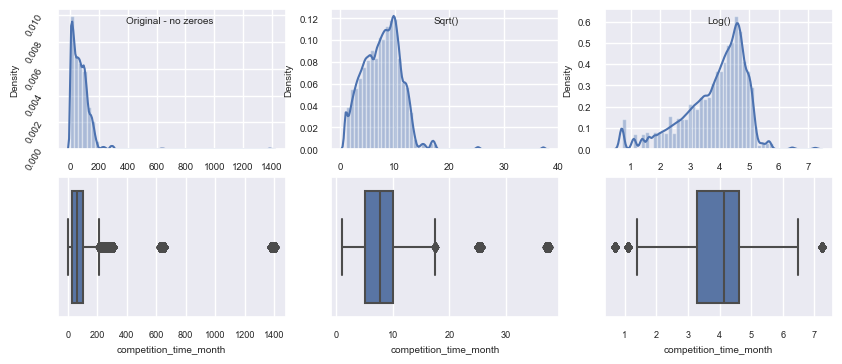

In [124]:
# Plot again, no zeroes
plt.figure(figsize=(10, 4))
plt.subplot(2,3,1)
sns.distplot( aux['competition_time_month'] );
plt.xticks( fontsize=7 );
plt.yticks( rotation=60, fontsize=7 );
plt.annotate( 'Original - no zeroes', xy=(0.30, 0.9), xycoords='axes fraction' )
#
plt.subplot(2,3,2)
sns.distplot( np.sqrt( aux['competition_time_month'] ) );
plt.xticks( fontsize=7 );
plt.yticks( fontsize=7 );
plt.annotate( 'Sqrt()', xy=(0.45, 0.9), xycoords='axes fraction' )
#
plt.subplot(2,3,3)
sns.distplot( np.log1p(aux['competition_time_month']) );
plt.xticks( fontsize=7 );
plt.yticks( fontsize=7 );
plt.annotate( 'Log()', xy=(0.45, 0.9), xycoords='axes fraction' )
# Boxplot
plt.subplot(2,3,4)
bp = sns.boxplot( x='competition_time_month', data=aux );
#
plt.subplot(2,3,5)
bp = sns.boxplot( x=np.sqrt( aux['competition_time_month'] ) );

# Apply LOG to aux
aux['competition_time_month'] = np.log1p( aux['competition_time_month'] )

plt.subplot(2,3,6)
bp = sns.boxplot( x='competition_time_month', data=aux )

In [125]:
# Apply LOG
df5['competition_time_month'] = np.log1p( df5['competition_time_month'] )

# Then apply MIN-MAX scaling
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( '../webapp/parameter/competition_time_month_scaler.pkl', 'wb' ) )

## 5.3. Transformation

### 5.3.1 Encoding

In [126]:
# 5.3.1 Encoding

# Categorical feature: STATE_HOLIDAY - one hot encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# Categorical feature: STORE_TYPE - label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] ).astype( np.int64 )
pickle.dump( le, open( '../webapp/parameter/store_type_scaler.pkl', 'wb' ) )

# Categorical feature: ASSORTMENT (basic, extra, extended) - Ordinal encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 Cyclical Features Encoding (Nature Transformation)

In [127]:
# 5.3.3 Nature Transformation
# FEATURES WITH CYCLIC NATURE:

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( '../webapp/parameter/year_scaler.pkl', 'wb' ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/31 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/31 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52.5 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52.5 ) ) )

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# quarter
df5['quarter_sin'] = df5['quarter'].apply( lambda x: np.sin( x * ( 2. * np.pi/4 ) ) )
df5['quarter_cos'] = df5['quarter'].apply( lambda x: np.cos( x * ( 2. * np.pi/4 ) ) )

# 2-months
df5['2months_sin'] = df5['2months'].apply( lambda x: np.sin( x * ( 2. * np.pi/6 ) ) )
df5['2months_cos'] = df5['2months'].apply( lambda x: np.cos( x * ( 2. * np.pi/6 ) ) )

# fortnight_of_year
df5['fortnight_of_year_sin'] = df5['fortnight_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/4 ) ) )
df5['fortnight_of_year_cos'] = df5['fortnight_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/4 ) ) )


# ATENÇÃO: acho que deveria ter alguma transformação também para...
# 
#    'competition_open_since_month',
#    'competition_open_since_year',
# 
#    'promo2_since_week',
#    'promo2_since_year',
#
# Decisão: deixaremos para uma próxima rodada do CRISP



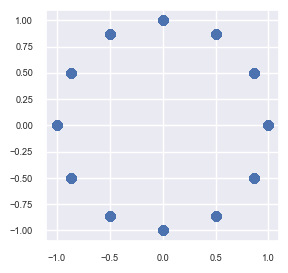

In [128]:
plt.figure(figsize=(3, 3));
plt.scatter( df5['month_sin'], df5['month_cos'] );

In [129]:
df5.sample(6).T

686449               532596  \
store                                         395                  412   
day_of_week                                     4                    2   
date                          2013-10-24 00:00:00  2014-03-11 00:00:00   
sales                                    8.210124              8.84087   
promo                                           1                    0   
school_holiday                                  1                    0   
store_type                                      0                    3   
assortment                                      1                    3   
competition_distance                      0.56213             0.584901   
competition_open_since_month                    2                    3   
competition_open_since_year                  2013                 2014   
promo2                                          0                    1   
promo2_since_week                              43                   39   
promo2_since_year                            2013                 2010   
is_promo2                                       0                    0   
promo2_since                  2013-10-21 00:00:00  2010-09-20 00:00:00   
promo2_time_week                              0.0             0.578275   
has_competition                                 1                    1   
competition_since             2013-02-01 00:00:00  2014-03-01 00:00:00   
competition_time_month                  -0.147305            -0.656218   
year                                          0.0                  0.5   
month                                          10                    3   
day                                            24                   11   
semester                                        1                    0   
quarter                                         4                    1   
2months                                         5                    2   
fortnight_of_year                              20                    5   
fortnight_of_month                              1                    0   
week_of_year                                   43                   11   
year_week                                 2013-42              2014-10   
state_holiday_christmas                     False                False   
state_holiday_easter_holiday                False                False   
state_holiday_public_holiday                False                False   
state_holiday_regular_day                    True                 True   
month_sin                               -0.866025                  1.0   
month_cos                                     0.5                  0.0   
day_sin                                 -0.988468             0.790776   
day_cos                                  0.151428            -0.612106   
week_of_year_sin                        -0.907359             0.967835   
week_of_year_cos                         0.420357             0.251587   
day_of_week_sin                         -0.433884             0.974928   
day_of_week_cos                         -0.900969            -0.222521   
quarter_sin                                  -0.0                  1.0   
quarter_cos                                   1.0                  0.0   
2months_sin                             -0.866025             0.866025   
2months_cos                                   0.5                 -0.5   
fortnight_of_year_sin                        -0.0                  1.0   
fortnight_of_year_cos                         1.0                  0.0   

                                           38326                332060  \
store                                         417                  372   
day_of_week                                     6                    6   
date                          2015-06-27 00:00:00  2014-09-20 00:00:00   
sales                                    8.452548             8.900958   
promo                                         

# STEP 6. FEATURE SELECTION

## 6.0. Initial Procedure

In [130]:
df6 = df5.copy()
df6.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'school_holiday',
       'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo2', 'promo2_since',
       'promo2_time_week', 'has_competition', 'competition_since',
       'competition_time_month', 'year', 'month', 'day', 'semester', 'quarter',
       '2months', 'fortnight_of_year', 'fortnight_of_month', 'week_of_year',
       'year_week', 'state_holiday_christmas', 'state_holiday_easter_holiday',
       'state_holiday_public_holiday', 'state_holiday_regular_day',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos', 'quarter_sin',
       'quarter_cos', '2months_sin', '2months_cos', 'fortnight_of_year_sin',
       'fortnight_of_year_cos'],
      dtype='object')

## 6.1. Split Train & Test sets

In [131]:
# 6.1. Split dataframe into training and test set

# First, before splitting, delete features already transformed to others

# ATENÇÃO: isso já teria sido feito no passo 3 DATA CLEANING - VERIFICAR ISSO !!!

cols_drop = [
    'day', 'month', 
    'week_of_year', 
    'day_of_week',
    'quarter', '2months',
    'fortnight_of_year',
    'promo2_since', 
    'competition_since', 
    'year_week']


df6 = df6.drop( cols_drop, axis=1 )

In [132]:
# SPLIT DATA: in time series analysis, do not split randomly, but split to test...
# ...data from last six weeks.

# TOTAL DATA: from 2013-jan-01 to 2015-jul-31

# Limit-date: beginning of last six weeks = 2015-06-19
print( df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7) )

# Training dataset: total data minus six weeks, or: from 2013-jan-01 to 2015-06-18
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Test dataset: last six weeks, or: from 2015-06-19 to 2015-07-31
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )


2015-06-19 00:00:00
Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Running BORUTA as Feature Selection

### 6.2.1. Run Boruta

In [133]:
# 6.2. Running BORUTA as Feature Selection

# In case of error running BORUTA.FIT (module 'numpy' has no attribute 'int'), take a look at:
# https://discuss.python.org/t/boruta-fit-error/23954/4
# To downgrade NumPy from 1.26.0, USE: pip install --upgrade numpy==1.23.1
# Or, alternatively, make np.int = np.int32 and np.float = np.float64 and np.bool = np.bool_
# https://github.com/scikit-learn-contrib/boruta_py/issues/122

# training and test dataset for Boruta (array)
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta [jump next line to avoid N hours waiting...]
if BOL_RUN_BORUTA:
    np.int = np.int32
    np.float = np.float64
    np.bool = np.bool_
    boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	18


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	18


### 6.2.2. Best Features from Boruta

In [134]:
# 6.2.1. Best Features from Boruta

if BOL_RUN_BORUTA:

    # Select features BORUTA found as most relevants
    cols_selected = boruta.support_.tolist()

    # best features
    X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
    cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
    print( cols_selected_boruta )

    # COLS_SELECTED_BORUTA:
    # ['store', 'promo', 'store_type', 'assortment',
    #  'competition_distance', 'competition_open_since_month', 'competition_open_since_year',
    #  'promo2', 'promo2_since_week', 'promo2_since_year', 'promo2_time_week',
    #  'competition_time_month', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_cos',
    #  'day_of_week_sin', 'day_of_week_cos']

    # not selected by boruta
    cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )
    print( cols_not_selected_boruta )

    # COLS_NOT_SELECTED_BORUTA:
    # ['is_promo2', '2months_sin', '2months_cos',
    # 'fortnight_of_month', 'fortnight_of_year_sin', 'fortnight_of_year_cos',
    # 'has_competition', 'quarter_sin', 'quarter_cos', 'semester', 'year',
    # 'school_holiday', 'state_holiday_christmas', 'state_holiday_easter_holiday', 
    # 'state_holiday_public_holiday', 'state_holiday_regular_day' ]


['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo2_time_week', 'competition_time_month', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos']
['2months_cos', '2months_sin', 'fortnight_of_month', 'fortnight_of_year_cos', 'fortnight_of_year_sin', 'has_competition', 'is_promo2', 'month_sin', 'quarter_cos', 'quarter_sin', 'school_holiday', 'semester', 'state_holiday_christmas', 'state_holiday_easter_holiday', 'state_holiday_public_holiday', 'state_holiday_regular_day', 'week_of_year_sin', 'year']


## 6.3. Manual Feature Selection

In [135]:
## 6.3. Manual Feature Selection

# Compare features from BORUTA and from BIVARIATE ANALYSIS (4.2.9)

# Features from Boruta
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo2_time_week',
    'month_sin',  # we added this one
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin', # we added this one
    'week_of_year_cos',
    'day_of_week_sin',
    'day_of_week_cos'
 ]

 # Columns to add
feat_to_add = ['date','sales']

# Full dataset, to use in Module 7 - class 33
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )


In [136]:
cols_not_selected_boruta = [
    'is_promo2',
    '2months_sin',
    '2months_cos',
    'fortnight_of_month',
    'fortnight_of_year_sin',
    'fortnight_of_year_cos',
    'has_competition',
    'quarter_sin',
    'quarter_cos',
    'semester',
#    'month_sin',
    'school_holiday',
    'state_holiday_christmas',
    'state_holiday_easter_holiday',
    'state_holiday_public_holiday',
    'state_holiday_regular_day',
#    'week_of_year_sin',
    'year'
]


In [137]:
# Features from Bivariate Analysis (4.2.1)
print( tabulate( tab, headers='firstrow' ) )

Hipóteses    Conclusão    Relevância    Feature
-----------  -----------  ------------  -----------------------
H1           Falsa        Média         competition_since
H2           -            Baixa         competition_distance
H3           Falsa        Alta          assortment
H4           Verdadeira   Média         assortment
H5           Falsa        Média         assortment
H6           Falsa        Média         promo2_since
H7           Falsa        Média         promo/promo2
H8           Verdadeira   Alta          state_holiday/christmas
H9           Falsa        Alta          school_holiday
H10          Falsa        Alta          state_holiday
H11          Verdadeira   Baixa         day_of_week
H12          Verdadeira   Média         day_of_week
H13          Verdadeira   Alta          day_of_week
H14          Falsa        Alta          month/state_holiday
H15          Verdadeira   Alta          month
H16          Verdadeira   Alta          day
H17          Falsa        Alta 

In [138]:
# From Buvariate Analysis, the important hipothesys are H3, H8, H9, H10, H13, H14, H15, H16, H17

# H3  - assortment           [boruta considered relevant]
# H8  - christmas            [NOT relevant to boruta]
# H9  - school_holiday       [NOT relevant to boruta]
# H10 - state_holiday        [NOT relevant to boruta]
# H13 - day_of_week          [boruta considered relevant]
# H14 - month/state_holiday
# H15 - month                [boruta just considered month_cos]
# H16 - day                  [boruta considered relevant]
# H17 - day


# STEP 7. MACHINE LEARNING MODELS

In [139]:
# Models are tested with their default hyperparameters.
# The best performing model is used for 'fine tuning'

## 7.0. Initial Procedure

In [140]:
# 7.0 PROCEDIMENTOS INICIAIS

# Get features from BORUTA, excluding 'data' & 'sales'
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

## 7.1. Average Model

In [141]:
# 7.1 AVERAGE MODEL

baseline_result = 0

if BOL_RUN_MLMODELS:

    aux1 = x_test.copy()
    aux1['sales'] = y_test.copy()

    # prediction
    aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns={'sales': 'predictions'} )
    aux1 = pd.merge( aux1, aux2, how='left', on='store' )
    yhat_baseline = aux1['predictions']

    # performance
    # PS: in 5.3.2 we made LOG(sales). Undoing now...
    baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )

baseline_result

Model Name          MAE    MAPE         RMSE
0  Average Model  1354.800353  0.2064  1835.135542

## 7.2. Linear Regression Model

In [142]:
# 7.2 LINEAR REGRESSION MODEL

lr_result = 0

if BOL_RUN_MLMODELS:

    # model
    lr = LinearRegression().fit( x_train, y_train )

    # prediction
    yhat_lr = lr.predict( x_test )

    # performance
    lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )

lr_result

Model Name          MAE      MAPE         RMSE
0  Linear Regression  1871.765032  0.297166  2659.116264

## 7.3. Linear Regression Regularized Model - Lasso

In [143]:
# 7.3. Linear Regression Regularized Model - Lasso

lrr_result = 0

if BOL_RUN_MLMODELS:

    # model
    lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

    # prediction
    yhat_lrr = lrr.predict( x_test )

    # performance
    lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )

lrr_result

Model Name          MAE      MAPE         RMSE
0  Linear Regression - Lasso  1891.158379  0.289409  2746.043979

## 7.4. Random Forest Regressor

In [144]:
# 7.4. Random Forest Regressor

rf_result = 0

if BOL_RUN_MLMODELS:

    # model
    rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

    # prediction
    yhat_rf = rf.predict( x_test )

    # performance
    rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )

rf_result

Model Name         MAE      MAPE         RMSE
0  Random Forest Regressor  667.062128  0.098706  1015.272934

## 7.5. XGBoost Regressor

In [145]:
# 7.5. XGBOOST REGRESSOR

xgb_result = 0

if BOL_RUN_MLMODELS:

    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                n_estimators=100, 
                                #eta=0.01,
                                max_depth=10,
                                subsample=0.7,
                                colsample_bytee=0.9 ).fit( x_train, y_train )

    # prediction
    yhat_xgb = model_xgb.predict( x_test )

    # performance
    xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )

xgb_result

[12:40:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.



Model Name         MAE      MAPE         RMSE
0  XGBoost Regressor  712.572804  0.102872  1029.746942

## 7.6. Compare Models' Performance

In [146]:
# 7.6 COMPARE MODELS' PERFORMANCE

# PS: this result is not as reliable as "cross-validation"

modelling_result = 0

if BOL_RUN_MLMODELS:
    modelling_result = pd.concat( [ baseline_result, lr_result, lrr_result, rf_result, xgb_result ] )
    modelling_result = modelling_result.sort_values( 'RMSE' )

modelling_result

Model Name          MAE      MAPE         RMSE
0    Random Forest Regressor   667.062128  0.098706  1015.272934
0          XGBoost Regressor   712.572804  0.102872  1029.746942
0              Average Model  1354.800353  0.206400  1835.135542
0          Linear Regression  1871.765032  0.297166  2659.116264
0  Linear Regression - Lasso  1891.158379  0.289409  2746.043979

In [147]:
# Add data & sales:
x_training = X_train[ cols_selected_boruta_full ]

In [148]:
#model = LinearRegression()
a = 0

if BOL_RUN_MLMODELS:
    model = Lasso( alpha=0.01 )
    a = cross_validation( x_training, 5, 'Lasso', model, True )

a

KFold Number: 5
Dates -     start=2014-11-20 00:00:00     end=2015-01-01 00:00:00
  Model Name         MAE      MAPE         RMSE
0      Lasso  2752.21888  0.315069  3977.491815
KFold Number: 4
Dates -     start=2015-01-01 00:00:00     end=2015-02-12 00:00:00
  Model Name         MAE      MAPE         RMSE
0      Lasso  1849.79644  0.291998  2636.351029
KFold Number: 3
Dates -     start=2015-02-12 00:00:00     end=2015-03-26 00:00:00
  Model Name          MAE      MAPE         RMSE
0      Lasso  1812.930666  0.289974  2603.243571
KFold Number: 2
Dates -     start=2015-03-26 00:00:00     end=2015-05-07 00:00:00
  Model Name         MAE      MAPE        RMSE
0      Lasso  2162.40521  0.285314  3171.43928
KFold Number: 1
Dates -     start=2015-05-07 00:00:00     end=2015-06-18 00:00:00
  Model Name          MAE      MAPE         RMSE
0      Lasso  2017.330178  0.281204  2925.819884


Model Name              MAE CV        MAPE CV             RMSE CV  \
0      Lasso  2118.94 +/- 340.39  0.29 +/- 0.01  3062.87 +/- 502.05   

    rmse_float  
0  3062.869116

## 7.7. Compare Models' Cross-Validation Performance

### 7.7.1. Linear Regression Model - Cross Validation

In [149]:
# 7.7.1. Linear Regression Model - Cross Validation
# Performance without cross validation
lr_result

Model Name          MAE      MAPE         RMSE
0  Linear Regression  1871.765032  0.297166  2659.116264

In [150]:
# 7.7.1 Linear Regression Model - Cross Validation
lr_result_cv = 0

if BOL_RUN_MLMODELS:
    lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, False )

lr_result_cv

Model Name              MAE CV        MAPE CV            RMSE CV  \
0  Linear Regression  2084.42 +/- 275.17  0.31 +/- 0.02  2938.95 +/- 445.8   

    rmse_float  
0  2938.949934

### 7.7.2. Lasso Model - Cross Validation

In [151]:
# 7.7.2. Lasso Model - cv
# Performance without cv
lrr_result

Model Name          MAE      MAPE         RMSE
0  Linear Regression - Lasso  1891.158379  0.289409  2746.043979

In [152]:
# 7.7.1 Linear Regression Model - Cross Validation
lrr_result_cv = 0

if BOL_RUN_MLMODELS:
    lrr_result_cv = cross_validation( x_training, 5, 'Lin.Regr. Lasso', lrr, False )

lrr_result_cv

Model Name              MAE CV        MAPE CV             RMSE CV  \
0  Lin.Regr. Lasso  2118.94 +/- 340.39  0.29 +/- 0.01  3062.87 +/- 502.05   

    rmse_float  
0  3062.869116

### 7.7.3. Random Forest Model - Cross Validation

In [153]:
# 7.7.3. Random Forest Model - cv
# Performance without cv
rf_result

Model Name         MAE      MAPE         RMSE
0  Random Forest Regressor  667.062128  0.098706  1015.272934

In [154]:
# 7.7.3 Random Forest Model - Cross Validation
rf_result_cv = 0

if BOL_RUN_MLMODELS:
    rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor CV', rf, True )

rf_result_cv

KFold Number: 5
Dates -     start=2014-11-20 00:00:00     end=2015-01-01 00:00:00
                   Model Name          MAE      MAPE         RMSE
0  Random Forest Regressor CV  1304.887711  0.160057  2007.862999
KFold Number: 4
Dates -     start=2015-01-01 00:00:00     end=2015-02-12 00:00:00
                   Model Name         MAE      MAPE         RMSE
0  Random Forest Regressor CV  861.075741  0.134572  1264.951178
KFold Number: 3
Dates -     start=2015-02-12 00:00:00     end=2015-03-26 00:00:00
                   Model Name         MAE      MAPE       RMSE
0  Random Forest Regressor CV  557.335059  0.089663  864.25888
KFold Number: 2
Dates -     start=2015-03-26 00:00:00     end=2015-05-07 00:00:00
                   Model Name         MAE      MAPE         RMSE
0  Random Forest Regressor CV  855.028739  0.110215  1300.463482
KFold Number: 1
Dates -     start=2015-05-07 00:00:00     end=2015-06-18 00:00:00
                   Model Name         MAE     MAPE         RMSE
0  Rando

Model Name             MAE CV        MAPE CV  \
0  Random Forest Regressor CV  855.26 +/- 251.27  0.12 +/- 0.03   

              RMSE CV   rmse_float  
0  1292.31 +/- 391.93  1292.308826

### 7.7.4. XGBoost Model - Cross Validation

In [155]:
# 7.7.4. XGBoost Model - cv
# Performance without cv
xgb_result

Model Name         MAE      MAPE         RMSE
0  XGBoost Regressor  712.572804  0.102872  1029.746942

In [156]:
# 7.7.1 XGBoost Model - Cross Validation
xgb_result_cv = 0

if BOL_RUN_MLMODELS:
    xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor CV', model_xgb, True )

xgb_result_cv

KFold Number: 5
Dates -     start=2014-11-20 00:00:00     end=2015-01-01 00:00:00
[12:56:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

             Model Name          MAE      MAPE        RMSE
0  XGBoost Regressor CV  1278.645235  0.163014  1821.27584
KFold Number: 4
Dates -     start=2015-01-01 00:00:00     end=2015-02-12 00:00:00
[12:57:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

             Model Name         MAE      MAPE         RMSE
0  XGBoost Regressor CV  960.787966  0.143319  1344.903652
KFold Number: 3
Dates -     start=2015-02-12 00:00:00     end=2015-03-26 00:00:00
[12:58:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

             Model Name         MAE      MAPE        RMSE
0  XGBoost Re

Model Name             MAE CV        MAPE CV             RMSE CV  \
0  XGBoost Regressor CV  952.02 +/- 196.35  0.13 +/- 0.02  1363.02 +/- 272.64   

    rmse_float  
0  1363.024445

## 7.8. Compare Models' Performance (cv)

### 7.8.1. Single Model Performance

In [157]:
modelling_result

Model Name          MAE      MAPE         RMSE
0    Random Forest Regressor   667.062128  0.098706  1015.272934
0          XGBoost Regressor   712.572804  0.102872  1029.746942
0              Average Model  1354.800353  0.206400  1835.135542
0          Linear Regression  1871.765032  0.297166  2659.116264
0  Linear Regression - Lasso  1891.158379  0.289409  2746.043979

### 7.8.2. Real Model Performance - with Cross Validation

In [158]:
modelling_result_cv = 0

if BOL_RUN_MLMODELS:
    modelling_result_cv = pd.concat( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv ] )
    modelling_result_cv = modelling_result_cv.sort_values( 'RMSE CV' )
    print()

modelling_result_cv

Model Name              MAE CV        MAPE CV  \
0  Random Forest Regressor CV   855.26 +/- 251.27  0.12 +/- 0.03   
0        XGBoost Regressor CV   952.02 +/- 196.35  0.13 +/- 0.02   
0           Linear Regression  2084.42 +/- 275.17  0.31 +/- 0.02   
0             Lin.Regr. Lasso  2118.94 +/- 340.39  0.29 +/- 0.01   

              RMSE CV   rmse_float  
0  1292.31 +/- 391.93  1292.308826  
0  1363.02 +/- 272.64  1363.024445  
0   2938.95 +/- 445.8  2938.949934  
0  3062.87 +/- 502.05  3062.869116

# STEP 8. HYPERPARAMETER FINE TUNING

## 8.0. Initial Procedure

In [159]:
# NOP...

## 8.1. Random Search

In [160]:
param = {
    #'n_estimators': [15, 17, 30, 35],
    'n_estimators': [1000],
    #'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'min_child_weight': [3, 8, 15],
    'colsample_bytee': [0.3]
}

# Number of iterations
MAX_EVAL = 10


In [164]:
param = {
    'n_estimators': [1000],
    'max_depth': [4,5,6],
    'subsample': [0.7, 0.8, 0.9],
    'min_child_weight': [14, 15, 16],
    'colsample_bytee': [0.3]
}

# Number of iterations
MAX_EVAL = 12


In [165]:
final_result = pd.DataFrame()
first_time = True
best_result = None
best_hp = []

if BOL_RUN_FINETUNING:

    for i in range( MAX_EVAL ):
        # Random parameters
        hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
        print( hp )

        # model
        model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=hp['n_estimators'], 
                                    #eta=hp['eta'],
                                    max_depth=hp['max_depth'],
                                    subsample=hp['subsample'],
                                    min_child_weight=hp['min_child_weight'],
                                    colsample_bytee=hp['colsample_bytee'] )

        # performance
        result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb )
        rmse = result.loc[ 0, 'RMSE CV' ]
        final_result = pd.concat( [final_result, result] )
        if first_time:
            first_time = False
            best_result = result
        else:
            if result.loc[ 0, 'rmse_float' ] < best_result.loc[ 0, 'rmse_float' ]:
                best_result = result
                print('best result')
                print(result)
                print('best hp')
                print(hp)
                best_hp = [ hp['n_estimators'], hp['max_depth'], hp['subsample'], hp['min_child_weight'], hp['colsample_bytee'] ]

    print('----- BEST RESULTS -----')
    print(best_result)
    print(best_hp)

final_result


{'n_estimators': 1000, 'max_depth': 4, 'subsample': 0.9, 'min_child_weight': 15, 'colsample_bytee': 0.3}
[14:11:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

[14:15:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

{'n_estimators': 1000, 'max_depth': 4, 'subsample': 0.9, 'min_child_weight': 15, 'colsample_bytee': 0.3}
[14:19:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

[14:22:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

{'n_estimators': 1000, 'max_depth': 5, 'subsample': 0.8, 'min_child_weight': 15, 'colsample_bytee': 0.3}
[14:26:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learne

Model Name            MAE CV        MAPE CV             RMSE CV  \
0  XGBoost Regressor  932.35 +/- 91.24  0.13 +/- 0.01  1322.69 +/- 166.31   
0  XGBoost Regressor  932.35 +/- 91.24  0.13 +/- 0.01  1322.69 +/- 166.31   
0  XGBoost Regressor  882.54 +/- 97.95  0.12 +/- 0.01  1249.15 +/- 168.28   
0  XGBoost Regressor  888.08 +/- 87.37  0.12 +/- 0.01  1263.47 +/- 158.83   
0  XGBoost Regressor   882.2 +/- 87.74  0.12 +/- 0.01  1272.39 +/- 173.52   
0  XGBoost Regressor  868.72 +/- 78.06  0.12 +/- 0.01  1238.47 +/- 136.56   
0  XGBoost Regressor   901.2 +/- 87.32  0.12 +/- 0.01  1282.47 +/- 152.97   
0  XGBoost Regressor  925.42 +/- 91.26  0.13 +/- 0.01  1303.84 +/- 154.26   
0  XGBoost Regressor  940.56 +/- 67.01   0.13 +/- 0.0  1321.48 +/- 127.77   
0  XGBoost Regressor  952.5 +/- 100.17  0.13 +/- 0.01  1336.44 +/- 163.89   
0  XGBoost Regressor  940.56 +/- 67.01   0.13 +/- 0.0  1321.48 +/- 127.77   
0  XGBoost Regressor   876.9 +/- 92.25  0.12 +/- 0.01  1245.28 +/- 152.42   

    rmse_float  
0  1322.688893  
0  1322.688893  
0  1249.152657  
0  1263.472887  
0  1272.392396  
0  1238.466486  
0  1282.470333  
0  1303.843865  
0  1321.484468  
0  1336.437432  
0  1321.484468  
0  1245.277934

## 8.2. Final Model

In [188]:
# Results in dd.mm.aaaa:
# in 31.1.2024: rmse=1284.7  {'n_estimators': 1000, 'max_depth': 9, 'subsample': 0.5, 'min_child_weight': 15, 'colsample_bytee': 0.3}
# in DD.1.2024: rmse=1263.47 {'n_estimators': 1000, 'max_depth': 5, 'subsample': 0.7, 'min_child_weight': 15, 'colsample_bytee': 0.3}
# in 06.2.2024: rmse=1249.15 {'n_estimators': 1000, 'max_depth': 5, 'subsample': 0.8, 'min_child_weight': 15, 'colsample_bytee': 0.3}
# in 07.2.2024: rmse=1252.60 {'n_estimators': 1000, 'max_depth': 5, 'subsample': 1.0, 'min_child_weight': 15, 'colsample_bytee': 0.3}
# in 13.2.2024: rmse=1238.47 {'n_estimators': 1000, 'max_depth': 6, 'subsample': 0.7, 'min_child_weight': 16, 'colsample_bytee': 0.3}

param_tuned = {
    'n_estimators': 1000,  # RMSE = 1238.47
    #'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.8,
    'min_child_weight': 15,
    'colsample_bytee': 0.3
}

In [189]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    #eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    min_child_weight=param_tuned['min_child_weight'],
                                    colsample_bytee=param_tuned['colsample_bytee'] ).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )

# save (pickle)
pickle.dump( model_xgb_tuned, open( '../webapp/model/model_rossmann.pkl', 'wb' ) )

xgb_result_tuned


[16:43:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.



Model Name         MAE      MAPE        RMSE
0  XGBoost Regressor  673.000801  0.099265  972.611652

# STEP 9. ERROR TRANSLATION & INTERPRETATION

## 9.0. Initial Procedure

In [190]:
# 9. ERROR TRANSLATION - initial procedure

# copy dataset: only last six weeks, from 19-6 to 31-7-2015
df9 = X_test[ cols_selected_boruta_full ]

# Transform output variables (sales & predictions) back to normal (inv.log == expm1).
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )


In [191]:
df9.shape

(41396, 23)

## 9.1. Business Performance

In [192]:
# 9.1. ERROR TRANSLATION - Business Performance

# Analysis per store units

# SUM OF PREDICTIONS per store (over six weeks, from 19-06 to 31-07-2015)
df91  = df9[['store', 'predictions']].groupby('store').sum().reset_index()
df91A = df9[['store', 'promo']].groupby('store').count().reset_index()
df91A.columns = ['store', 'ndays']

# MAE per store (over six weeks, from 19-06 to 31-07-2015)
df9_aux1 = (df9[['store', 'sales', 'predictions']]
            .groupby( 'store' )
            .apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) )
            .reset_index().rename(columns={0: 'MAE'}))

# MAPE per store (over six weeks, from 19-06 to 31-07-2015)
df9_aux2 = (df9[['store', 'sales', 'predictions']]
            .groupby( 'store' )
            .apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) )
            .reset_index().rename(columns={0: 'MAPE'}))

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )
df92 = pd.merge( df92, df91A, how='inner', on='store' )

# Scenarios
df92['best_scenario']  = df92['predictions'] + df92['ndays'] * df92['MAE']
df92['worst_scenario'] = df92['predictions'] - df92['ndays'] * df92['MAE']
df92['worst_scenario'] = df92['worst_scenario'].apply( lambda x: 0 if x<0 else x )

# Order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE', 'ndays']]


In [193]:
# 9.1. ERROR TRANSLATION - Business Performance
# Which store units have higher forecasting errors?
print( df92.sort_values( 'MAPE', ascending=False ).head().round(2) )


     store    predictions  worst_scenario  best_scenario      MAE  MAPE  ndays
908    909  245993.234375        68956.04      423030.46  7697.27  0.54     23
291    292  108814.398438        50542.50      167086.30  3066.94  0.53     19
594    595  357363.531250       185514.01      529212.99  4644.58  0.32     37
721    722  366229.187500       279296.01      453162.43  2349.55  0.32     37
875    876  202220.562500       109360.05      295081.07  4037.41  0.30     23


In [194]:
print( df92.sort_values( 'MAPE', ascending=True ).head().round(2) )

      store    predictions  worst_scenario  best_scenario     MAE  MAPE  ndays
989     990  233869.359375       224398.75      243339.96  255.96  0.04     37
258     259  556805.562500       530229.91      583381.22  618.04  0.05     43
1088   1089  382206.875000       362627.96      401785.79  529.16  0.05     37
666     667  316340.968750       299018.14      333663.80  468.18  0.05     37
523     524  324599.937500       306944.87      342255.01  410.58  0.06     43


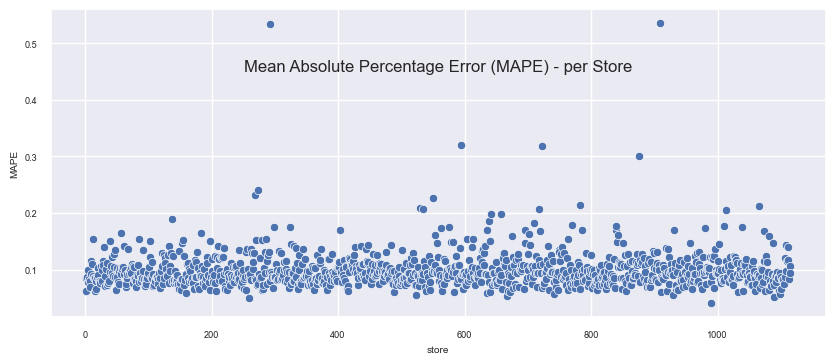

In [195]:
# 9.1. ERROR TRANSLATION - Business Performance
plt.figure( figsize=(10, 4) )
sns.scatterplot( x='store', y='MAPE', data=df92 );
plt.annotate( 'Mean Absolute Percentage Error (MAPE) - per Store', xy=(0.25, 0.80), xycoords='axes fraction', size=12 );


## 9.2. Total Performance

In [196]:
# 9.2. ERROR TRANSLATION - Total Performance

# df92[['predictions', 'worst_scenario', 'best_scenario']].sum()
df93 = (df92[['predictions', 'worst_scenario', 'best_scenario']]
        .apply( lambda x: np.sum( x ), axis=0 )
        .reset_index()
        .rename(columns={'index': 'Scenario', 0: 'Values'}))

df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

Scenario            Values
0     predictions  R$287,462,400.00
1  worst_scenario  R$259,602,862.81
2   best_scenario  R$315,321,945.14

## 9.3. Machine Learning Performance

In [197]:
# 9.3. ERROR TRANSLATION - Machine Learning Performance

df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']


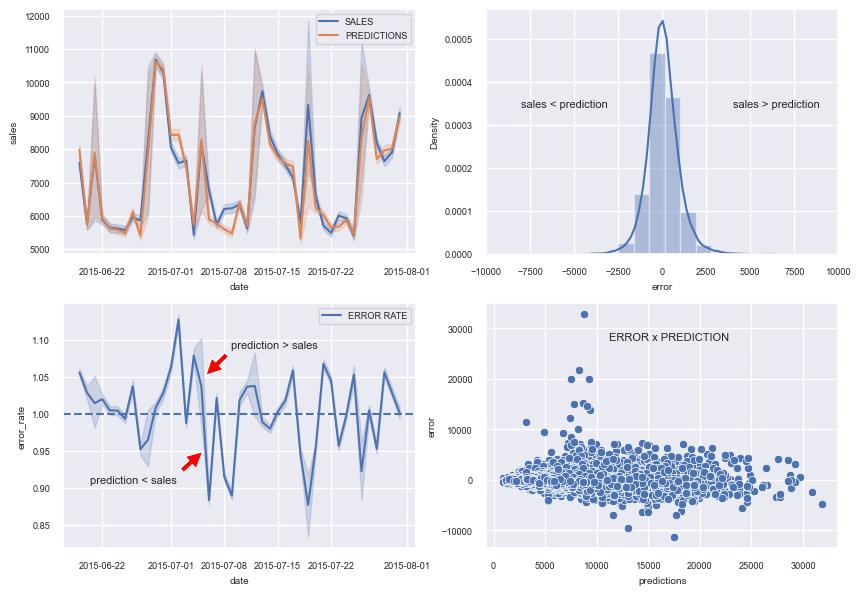

In [198]:
plt.figure( figsize=(10, 7) )
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )
#plt.title('SALES & PREDICTIONS')

plt.subplot( 2, 2, 3 )
sns.lineplot( x='date', y='error_rate', data=df9, label='ERROR RATE' )
plt.axhline( 1, linestyle='--' )

plt.annotate( 'prediction > sales', xy=(0.4, 0.7), xycoords='axes fraction', 
              xytext=(0.6, 0.85), textcoords='axes fraction', size=8,
              arrowprops=dict(facecolor='red', shrink=0.05),
              horizontalalignment='center', verticalalignment='top' );

plt.annotate( 'prediction < sales', xy=(0.4, 0.4), xycoords='axes fraction', 
              xytext=(0.2, 0.3), textcoords='axes fraction', size=8,
              arrowprops=dict(facecolor='red', shrink=0.05),
              horizontalalignment='center', verticalalignment='top' );

plt.subplot( 2, 2, 2 )
sns.distplot( df9['error'] );
plt.xlim(-10000, 10000)
plt.annotate( 'sales > prediction', xy=(0.7, 0.6), xycoords='axes fraction', size=8 );
plt.annotate( 'sales < prediction', xy=(0.1, 0.6), xycoords='axes fraction', size=8 );

plt.subplot( 2, 2, 4 )
sns.scatterplot( x=df9['predictions'], y=df9['error'] );
plt.annotate( 'ERROR x PREDICTION', xy=(0.35, 0.85), xycoords='axes fraction', size=8 );


# STEP 10. DEPLOY MODEL TO PRODUCTION

## 10.0. Initial procedure

In [199]:
# Saving trained model
# this file will be used by the API, in production.
pickle.dump( model_xgb_tuned, open( '../webapp/model/model_rossmann.pkl', 'wb' ) )


## 10.1. Rossmann Prediction Class

In [200]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path = 'c:/MeusEstudos/CURSOS TI/Em 2023 - ComunidadeDS/F2.D2 - DS.Prod/Projeto/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb' ) )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb' ) )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb' ) )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb' ) )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb' ) )


    def data_cleaning(self, df1):
        # Copied from STEP-1, items 1.2, 1.4, 1.6 and 1.7

        # 1.2. RENAME COLUMNS
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval' ]

        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        # 1.4. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        # 1.6. FILLOUT NA

        # competition_distance
        df1['competition_distance'] = (df1['competition_distance']
                                       .apply( lambda x: 200000.0 if math.isnan( x ) else x ))

        # competition_open_since_month
        df1['competition_open_since_month'] = (
            df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
        )

        # competition_open_since_year
        df1['competition_open_since_year'] = (
            df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )
        )

        # promo2_since_week
        df1['promo2_since_week'] = (
            df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
        )

        # promo2_since_year
        df1['promo2_since_year'] = (
            df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )
        )

        # promo_interval
        df1['promo_interval'].fillna( 0, inplace=True )

        # 1.7. CHANGE TYPES
        # From FLOAT to INT
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( np.int64 )
        df1['promo2_since_week']          = df1['promo2_since_week'].astype( np.int64 )
        df1['promo2_since_year']         = df1['promo2_since_year'].astype( np.int64 )

        return df1

    def feature_engineering(self, df2):
        # Copied from STEP-2, items 2.4.1 to 2.4.5, 3.1 and 3.2

        # 2.4.1 Attributes derived from 'PROMO2'

        # Attribute PROMO2: force to ZERO if date < (promo2_since_week + promo2_since_year)
        # PS: this is necessary because 'promo2' is originally a STORE.CSV attribute, not a TRAIN.CSV attribute
        # Example: STORE-28 started its 'promo2' only in 2015, 6th week. Before this week, promo2 should be ZERO.
        df2['promo2aux'] = df2.apply( lambda x: 0 if x['promo2'] == 0 
                                                    or x['date'].year < x['promo2_since_year'] 
                                                    or (x['date'].year == x['promo2_since_year'] and x['date'].week < x['promo2_since_week']) 
                                                else 1, axis=1 )

        # Attribute "IS_PROMO2"
        # From "promo2" & "promo_interval", create "is_promo2" attribute

        month_map = { 1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec' }

        df2['month_map'] = df2['date'].dt.month.map( month_map )

        df2['is_promo2'] = ( df2[['promo_interval', 'promo2aux', 'month_map']]
                            .apply( lambda x: 0 if x['promo2aux'] == 0 
                                                else 1 if x['month_map'] in x['promo_interval'].split( ',' ) 
                                                else 0, axis=1 ) )
        # Attribute PROMO2_SINCE
        # PS: using features: "promo2", "since_week" and "since_year"
        df2['promo2_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo2_since'] = df2['promo2_since'].apply( 
            lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) 
        )

        # Attribute PROMO2_TIME_WEEK
        df2['promo2_time_week'] = ( ( df2['date'] - df2['promo2_since'] )/7 ).apply( lambda x: x.days ).astype( np.int64 )
        df2['promo2_time_week'] = df2.apply( lambda x: 0.0 if x['promo2_time_week'] < 0 else x['promo2_time_week'], axis=1 )

        # 2.4.2 Attributes derived from 'COMPETITION'

        # Attribute HAS_COMPETITION: =ZERO in the days before CompetitionOpenSince[month/year].
        #                            =ONE after that date.
        df2['has_competition'] = ( df2
            .apply( lambda x: 0 if x['date'].year < x['competition_open_since_year'] 
                                or (x['date'].year == x['competition_open_since_year'] and x['date'].month < x['competition_open_since_month']) 
                                else 1, axis=1 ) )

        # Attribute COMPETITION_DISTANCE
        df2['competition_distance'] = df2.apply( lambda x: 200000.0 if x['has_competition'] == 0 else x['competition_distance'], axis=1 )

        # Attribute COMPETITION_SINCE
        # PS: info separated in MONTH & YEAR. Join them and calculate date difference to current date
        df2['competition_since'] = df2.apply( 
            lambda x: datetime.datetime( 
                year=x['competition_open_since_year'], 
                month=x['competition_open_since_month'], day=1 ), 
            axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( np.int64 )
        df2['competition_time_month'] = df2.apply( lambda x: 0.0 if x['competition_time_month'] < 0 else x['competition_time_month'], axis=1 )

        # 2.4.3 Attributes: time periodicity

        # year
        df2['year'] = df2['date'].dt.year
        # month
        df2['month'] = df2['date'].dt.month
        # day
        df2['day'] = df2['date'].dt.day

        # semester
        df2['semester'] = df2['month'].apply( lambda x: 0 if x < 7 else 1 ).astype( np.int64 )

        # quarter
        df2['quarter'] = df2['month'].apply( lambda x: 1 if x < 4 
                                                else 2 if x < 7 
                                                else 3 if x < 10 
                                                else 4 ).astype( np.int64 )
        # two months
        df2['2months'] = df2['month'].apply( lambda x: 1 if x < 3 
                                                else 2 if x < 5 
                                                else 3 if x < 7 
                                                else 4 if x < 9 
                                                else 5 if x < 11 
                                                else 6 ).astype( np.int64 )
        # fortnight
        df2['fortnight_of_year'] = df2.apply( lambda x: (2* x['month']) if x['day'] > 15 
                                                else (2* x['month'] -1), axis=1 ).astype( np.int64 )
        df2['fortnight_of_month'] = df2.apply( lambda x: 1 if x['day'] > 15 else 0, axis=1)

        # week of year
        # PS: function "weekofyear" didn't work. Replaced for the following:
        # REF: https://saturncloud.io/blog/how-to-convert-a-pandas-date-to-week-number-in-python/
        #df2['week_of_year'] = df2['date'].dt.weekofyear
        df2['week_of_year'] = df2['date'].dt.strftime('%U').astype(int) + 1

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # 2.4.4 Attributes: "assortment" & "state_holiday"

        # assortment: a=basic, b=extra, c=extended
        df2['assortment'] = ( df2['assortment']
                             .apply( lambda x: 'basic' if x == 'a' 
                                          else 'extra' if x == 'b' 
                                          else 'extended' ) )

        # state holiday
        # a=public holiday, b=Easter holiday, c=Christmas, 0=regular working day
        df2['state_holiday'] = df2['state_holiday'].apply( 
            lambda x: 'public_holiday' if x == 'a' else 
                    'easter_holiday' if x == 'b' else 
                    'christmas' if x == 'c' else 
                    'regular_day' )

        # 2.4.5 Attribute: "sales_per_customer"
        df2['sales_per_customer'] = (df2
                        .apply( lambda x: 0 if x['customers'] == 0 
                                          else x['sales'] / x['customers'], axis=1 ) )

        # 3.1. ROWS FILTERING
        df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]

        # 3.2. COLUMNS FILTERING
        cols_drop = [ 'open', 'promo_interval', 'month_map', 'promo2aux' ]
        df2 = df2.drop( cols_drop, axis=1 )

        return df2

    def data_preparetion(self, df5):
        # Code copied from STEP-5/6, items 5.1, 5.2, 5.3, 6.3

        # 5.1. Response Variable Normalization
        df5['sales'] = np.log1p( df5['sales'] )

        # 5.2. DATA PREPARATION - Rescaling
        # promo2_time_week
        df5['promo2_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo2_time_week']].values )
        # competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
        # competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # 5.3.1 Encoding
        # Categorical feature: state_holiday - one hot encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )
        # Categorical feature: store_type - label encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] ).astype( np.int64 )
        # Categorical feature: assortment (basic, extra, extended) - Ordinal encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        # 5.3.2 Nature Transformation
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )
        # CYCLICAL NATURE FEATURES:
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )
        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/31 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/31 ) ) )
        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52.5 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52.5 ) ) )
        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )
        # quarter
        df5['quarter_sin'] = df5['quarter'].apply( lambda x: np.sin( x * ( 2. * np.pi/4 ) ) )
        df5['quarter_cos'] = df5['quarter'].apply( lambda x: np.cos( x * ( 2. * np.pi/4 ) ) )
        # 2-months
        df5['2months_sin'] = df5['2months'].apply( lambda x: np.sin( x * ( 2. * np.pi/6 ) ) )
        df5['2months_cos'] = df5['2months'].apply( lambda x: np.cos( x * ( 2. * np.pi/6 ) ) )
        # fortnight_of_year
        df5['fortnight_of_year_sin'] = df5['fortnight_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/4 ) ) )
        df5['fortnight_of_year_cos'] = df5['fortnight_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/4 ) ) )

        # 6.3. Features from Boruta
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance',
            'competition_open_since_month', 'competition_open_since_year', 'promo2',
            'promo2_since_week', 'promo2_since_year', 'competition_time_month',
            'promo2_time_week', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
            'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos' ]

        return df5[ cols_selected ]

    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict( test_data )

        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )

        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. Test of Forecasting API

In [201]:
# load test dataset
#import pandas as pd
#import json
#filepath = "c:/MeusEstudos/CURSOS TI/Em 2023 - ComunidadeDS/F2.D2 - DS.Prod/Projeto/data/test.csv"
#df10 = pd.read_csv( filepath )

MyCSV = 'http://menezes.mendonca.nom.br/datasets/rossmann/test.csv'
df10 = pd.read_csv( MyCSV, low_memory=False )

#MyCSV = 'http://menezes.mendonca.nom.br/datasets/rossmann/store.csv'
#df_store_raw = pd.read_csv( MyCSV, low_memory=False )


In [202]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose one store for prediction
df_test = df_test[ df_test['Store'].isin( [14] ) ]

# remove closed days, nulls, remove 'ID'
df_test = df_test[ df_test['Open'] != 0 ]
df_test = df_test[ ~df_test['Open'].isnull() ]
df_test = df_test.drop( 'Id', axis=1 )

In [203]:
# Convert Dataframe to Json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [204]:
json_formatted_str = json.dumps( df_test.to_dict( orient='records' ), indent=2 )
print( json_formatted_str )

[
  {
    "Store": 14,
    "DayOfWeek": 4,
    "Date": "2015-09-17",
    "Open": 1.0,
    "Promo": 1,
    "StateHoliday": "0",
    "SchoolHoliday": 0,
    "StoreType": "a",
    "Assortment": "a",
    "CompetitionDistance": 1300.0,
    "CompetitionOpenSinceMonth": 3.0,
    "CompetitionOpenSinceYear": 2014.0,
    "Promo2": 1,
    "Promo2SinceWeek": 40.0,
    "Promo2SinceYear": 2011.0,
    "PromoInterval": "Jan,Apr,Jul,Oct"
  },
  {
    "Store": 14,
    "DayOfWeek": 3,
    "Date": "2015-09-16",
    "Open": 1.0,
    "Promo": 1,
    "StateHoliday": "0",
    "SchoolHoliday": 0,
    "StoreType": "a",
    "Assortment": "a",
    "CompetitionDistance": 1300.0,
    "CompetitionOpenSinceMonth": 3.0,
    "CompetitionOpenSinceYear": 2014.0,
    "Promo2": 1,
    "Promo2SinceWeek": 40.0,
    "Promo2SinceYear": 2011.0,
    "PromoInterval": "Jan,Apr,Jul,Oct"
  },
  {
    "Store": 14,
    "DayOfWeek": 2,
    "Date": "2015-09-15",
    "Open": 1.0,
    "Promo": 1,
    "StateHoliday": "0",
    "SchoolHolida

In [205]:
# Before calling the API (next step), go to terminal, change path and run the handler...

# cd C:\MeusEstudos\CURSOS TI\Em 2023 - ComunidadeDS\Projetos do Aluno\PA.04 Rossmann temp1\webapp

# > python handler.py

# stopping...
xxx

NameError: name 'xxx' is not defined

In [ ]:
from flask import Flask, request, Response

# API Call
url = 'http://127.0.0.1:5000/rossmann/predict'
#url = 'https://teste-rossmann-priv2.onrender.com/rossmann/predict'
header = { 'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [ ]:
# Convert API results to a Dataframe
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
r.json()

[{'store': 14,
  'day_of_week': 4,
  'date': '2015-09-17T00:00:00.000',
  'open': 1.0,
  'promo': 1,
  'state_holiday': 'regular_day',
  'school_holiday': 0,
  'store_type': 'a',
  'assortment': 'basic',
  'competition_distance': 1300.0,
  'competition_open_since_month': 3,
  'competition_open_since_year': 2014,
  'promo2': 1,
  'promo2_since_week': 40,
  'promo2_since_year': 2011,
  'promo_interval': 'Jan,Apr,Jul,Oct',
  'promo2aux': 1,
  'month_map': 'Sept',
  'is_promo2': 0,
  'promo2_since': '2011-09-26T00:00:00.000',
  'promo2_time_week': 207,
  'has_competition': 1,
  'competition_since': '2014-03-01T00:00:00.000',
  'competition_time_month': 18,
  'year': 2015,
  'month': 9,
  'day': 17,
  'semester': 1,
  'quarter': 3,
  '2months': 5,
  'fortnight_of_year': 18,
  'fortnight_of_month': 1,
  'week_of_year': 38,
  'year_week': '2015-37',
  'prediction': 5270.9174804688},
 {'store': 14,
  'day_of_week': 3,
  'date': '2015-09-16T00:00:00.000',
  'open': 1.0,
  'promo': 1,
  'state_h

In [ ]:
d1.head().T

0  \
store                                              14   
day_of_week                                         4   
date                          2015-09-17T00:00:00.000   
open                                              1.0   
promo                                               1   
state_holiday                             regular_day   
school_holiday                                      0   
store_type                                          a   
assortment                                      basic   
competition_distance                           1300.0   
competition_open_since_month                        3   
competition_open_since_year                      2014   
promo2                                              1   
promo2_since_week                                  40   
promo2_since_year                                2011   
promo_interval                        Jan,Apr,Jul,Oct   
promo2aux                                           1   
month_map                                        Sept   
is_promo2                                           0   
promo2_since                  2011-09-26T00:00:00.000   
promo2_time_week                                  207   
has_competition                                     1   
competition_since             2014-03-01T00:00:00.000   
competition_time_month                             18   
year                                             2015   
month                                               9   
day                                                17   
semester                                            1   
quarter                                             3   
2months                                             5   
fortnight_of_year                                  18   
fortnight_of_month                                  1   
week_of_year                                       38   
year_week                                     2015-37   
prediction                                 5270.91748   

                                                    1  \
store                                              14   
day_of_week                                         3   
date                          2015-09-16T00:00:00.000   
open                                              1.0   
promo                                               1   
state_holiday                             regular_day   
school_holiday                                      0   
store_type                                          a   
assortment                                      basic   
competition_distance                           1300.0   
competition_open_since_month                        3   
competition_open_since_year                      2014   
promo2                                              1   
promo2_since_week                                  40   
promo2_since_year                                2011   
promo_interval                        Jan,Apr,Jul,Oct   
promo2aux                                           1   
month_map                                        Sept   
is_promo2                                           0   
promo2_since                  2011-09-26T00:00:00.000   
promo2_time_week                                  207   
has_competition                                     1   
competition_since             2014-03-01T00:00:00.000   
competition_time_month                             18   
year                                             2015   
month                                               9   
day                                                16   
semester                                            1   
quarter                                             3   
2months                                             5   
fortnight_of_year                                  18   
fortnight_of_month                                  1   
week_of_year                                       38   
year_week                                     2015-37   
pred

In [ ]:
# Let's see the forecast revenue after six weeks
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
        d2.loc[i, 'store'],
        d2.loc[i, 'prediction']
    ) )

Store Number 14 will sell R$196,926.83 in the next 6 weeks


## 10.3. API Handler

In [ ]:
# STOP RUNNING HERE (Next code is for web-api)
xxx

In [ ]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( 'c:/MeusEstudos/CURSOS TI/Em 2023 - ComunidadeDS/F2.D2 - DS.Prod/Projeto/parameter/model_rossmann.pkl', 'rb' ) )

# init API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance( test_json, dict ):
            test_raw = pd.DataFrame( test_json, index=[0] )
        else:
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )

        # Instantiate Rossmann class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )

        return df_response

    else:
        return Response( '{}', status=200, mimetype='application/json' )


if __name__ == '__main__':
    app.run( '0.0.0.0' )    # running at "localhost"
